In [1]:
# Standard libraries
import time
from statistics import mode
from collections import Counter
import math

# External libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import cross_val_predict

# Imbalanced-learn modules
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Other modules
from scipy.stats import uniform



# **ML Project**


* [1. Importing data](#import_data)
* [2. Pre processing pipelines](#pipelines)
* [3. Exploring Training Data Before the Preprocessing Pipeline](#explore_1)
* [4. Applying the pipelines to the training, validation, and test sets](#app_pipelines)
* [5. Exploring Training Data After Preprocessing Pipeline](#explore_2)
* [6. Training and evaluating the models (Cross validation)](#models)
* [7. Predicitions on the test data](#pred_test)
* [8. Comparing with my best submission](#comp_sub)
* [9. Writing to a csv file (to submit to kaggle)](#csv_file)
* [10. Importing Data (Multiclass)](#m_1)
* [11. Data Exploration (Multiclass)](#m_2)
* [12. Applying the pipelines to the training, validation, and test sets (Multiclass)](#m_3)
* [13. Exploring high cardinality features (Multiclass)](#m_4)
* [14. Training and Evaluating Models (Multiclass)](#m_5)
* [15. Predictions on the testing data (Multiclass)](#m_6)

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="pipelines">

## **1. Importing data**

</a>
</div>

Importing test and training data sets

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [3]:
train_df.shape

(71236, 31)

Splitting the training data into training data and validation data

In [4]:
y_1 = train_df["readmitted_binary"]
y_2 = train_df["readmitted_multiclass"]
X = train_df.drop(["readmitted_binary", "readmitted_multiclass"], axis = 1)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X,y_1, test_size = 0.3, 
                                                  random_state = 0, 
                                                  stratify = y_1, 
                                                  shuffle = True)

Appending the target variable back to the dataset for further exploration.

In [6]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="pipelines">

## **2. Preprocessing Pipelines**

</a>
</div>


### **Pipeline_1:**
1. **Task:** Data Cleaning and Preprocessing.
2. **Operations:**
   - Fill 'a1c_test_result' with 'NotMeasured' where NA.
   - Fill 'glucose_test_result' with 'NotMeasured' where NA.
   - Replace '?' in the data.
   - Fill NA values in 'payer_code' with 'None'.
   - Replace unknown values in 'gender'.
   - Remove columns with a high percentage of missing values.

### **Pipeline_2:**
1. **Task:** Imputing Missing Values.
2. **Operations:**
   - Fill missing values in specified columns using the mode (most frequent value).
   - Columns: ['race', 'age', 'gender', 'admission_type', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']

### **Pipeline_3:**
1. **Task:** Feature Transformation and Cleaning.
2. **Operations:**
   - Transform the 'medication' column.
   - Map categories in the 'admission_source' column using a specified mapping.
   - Map categories for 'primary_diagnosis' using a custom mapper (`ICD9CodeMapper`).
   - Map categories in the 'primary_diagnosis' column using another specified mapping.
   - Map categories in the 'payer_code' column using a specified mapping.
   - Map categories in the 'discharge_disposition' column using a specified mapping.
   - Map categories in the 'admission_type' column using a specified mapping.
   - Transform features based on value counts.
   - Apply a random transformation to the 'age' column.
   - Replace outliers with IQR-based or MinMax-based methods for specified columns.
   - Drop specified columns from the dataset.

### **Transformers** 
Functions to pass to the pre processing pipelines

While some mappings may seem redundant, they are crucial for maintaining consistency during validation and test phases.
 During exploration, thresholds may be applied to retain categories with frequencies above a certain threshold.  However, this approach doesn't hold in the validation and test sets, necessitating the use of separate mappings.

In [7]:
# Mapping for categories in the 'admission_source' column
category_mapping = {
    'Physician Referral': 'Physician Referral',  # Map to 'Physician Referral'
    'Emergency Room': 'Emergency Room',  # Map to 'Emergency Room'
    'Transfer from a hospital': 'Transfer from a hospital',  # Map to 'Transfer from a hospital'
    'Transfer from another health care facility': 'Transfer from another health care facility',  # Map to 'Transfer from another health care facility'
    'Clinic Referral': 'Clinic Referral'  # Map to 'Clinic Referral'
}

# Mapping for categories in the 'primary_diagnosis' column
diagnosis_mapping = {
    'Infectious And Parasitic Diseases': 'Infectious And Parasitic Diseases',
    'Diseases Of The Respiratory System': 'Diseases Of The Respiratory System',
    'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders': 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders',
    'Diseases Of The Musculoskeletal System And Connective Tissue': 'Diseases Of The Musculoskeletal System And Connective Tissue',
    'Diseases Of The Genitourinary System': 'Diseases Of The Genitourinary System',
    'Diseases Of The Circulatory System': 'Diseases Of The Circulatory System',
    'Diseases Of The Digestive System': 'Diseases Of The Digestive System',
    'Mental Disorders': 'Mental Disorders',
    'Symptoms, Signs, And Ill-Defined Conditions': 'Symptoms, Signs, And Ill-Defined Conditions',
    'Injury And Poisoning': 'Injury And Poisoning',
    'Neoplasms': 'Neoplasms',
    'Diseases Of The Skin And Subcutaneous Tissue': 'Diseases Of The Skin And Subcutaneous Tissue'
}


# Mapping for categories in the 'payer_code' column
payer_code_mapping = {
    'None': 'None',
    'MD': 'MD',
    'MC': 'MC',
    'SP': 'SP',
    'BC': 'BC',
    'CP': 'CP',
    'HM': 'HM',
    'UN': 'UN',
    'CM': 'CM',
    'OG': 'OG',
}

# Mapping for categories in the 'discharge_disposition' column
discharge_mapping = {
    'Discharged/transferred to another short term hospital': 'Short Term Hospital',
    'Discharged/transferred to SNF': 'SNF',
    'Discharged to home': 'Home',
    'Other': 'Other',
    'Discharged/transferred to home with home health service': 'Home with Health Service',
    'Expired': 'Expired',
    'Discharged/transferred to another rehab fac including rehab units of a hospital .': 'Rehab Facility',
    'Discharged/transferred to another type of inpatient care institution': 'Other Inpatient Care'
}

# Mapping for categories in the 'admission_type' column
admission_type_mapping = {
    'Emergency': 'Emergency',
    'Elective': 'Elective',
    'Urgent': 'Urgent',
    'Not Available': 'Not Available'
}

def map_icd9_to_chapter(icd9_code):
    if icd9_code[0] == 'V':
        return 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
    elif icd9_code[0] == 'E':
        return 'Supplementary Classification Of External Causes Of Injury And Poisoning'
    
    # Convert the ICD-9 code to an integer for comparison
    try:
        # Attempt to convert the ICD-9 code to a float
        icd9_float = float(icd9_code)
        icd9_int = int(icd9_float)
    except ValueError:
        return 'Unknown'
    
    if 1 <= icd9_int <= 139:
        return 'Infectious And Parasitic Diseases'
    elif 140 <= icd9_int <= 239:
        return 'Neoplasms'
    elif 240 <= icd9_int <= 279:
        return 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'
    elif 280 <= icd9_int <= 289:
        return 'Diseases Of The Blood And Blood-Forming Organs'
    elif 290 <= icd9_int <= 319:
        return 'Mental Disorders'
    elif 320 <= icd9_int <= 389:
        return 'Diseases Of The Nervous System And Sense Organs'
    elif 390 <= icd9_int <= 459:
        return 'Diseases Of The Circulatory System'
    elif 460 <= icd9_int <= 519:
        return 'Diseases Of The Respiratory System'
    elif 520 <= icd9_int <= 579:
        return 'Diseases Of The Digestive System'
    elif 580 <= icd9_int <= 629:
        return 'Diseases Of The Genitourinary System'
    elif 630 <= icd9_int <= 679:
        return 'Complications Of Pregnancy, Childbirth, And The Puerperium'
    elif 680 <= icd9_int <= 709:
        return 'Diseases Of The Skin And Subcutaneous Tissue'
    elif 710 <= icd9_int <= 739:
        return 'Diseases Of The Musculoskeletal System And Connective Tissue'
    elif 740 <= icd9_int <= 759:
        return 'Congenital Anomalies'
    elif 760 <= icd9_int <= 779:
        return 'Certain Conditions Originating In The Perinatal Period'
    elif 780 <= icd9_int <= 799:
        return 'Symptoms, Signs, And Ill-Defined Conditions'
    elif 800 <= icd9_int <= 999:
        return 'Injury And Poisoning'
    
    # If the code doesn't match any known chapter range, return 'Unknown'
    return 'Unknown'



Transformers

In [8]:
class FillNAWithNotMeasured(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        # This transformer doesn't need fitting, so we return self
        return self

    def transform(self, X):
        # Create a new DataFrame to avoid modifying the original data
        X_transformed = X.copy()
        # Fill NaN values in the specified column with "Not measured"
        X_transformed[self.column] = X_transformed[self.column].fillna("Not measured")
        return X_transformed

class FillNAWithNone(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        # This transformer doesn't need fitting, so we return self
        return self

    def transform(self, X):
        # Create a new DataFrame to avoid modifying the original data
        X_transformed = X.copy()
        # Fill NaN values in the specified column with "Not measured"
        X_transformed[self.column] = X_transformed[self.column].fillna("None")
        return X_transformed

class RandomAgeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, age_column):
        self.age_column = age_column

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.age_column] = X_copy[self.age_column].map(self._generate_random_age)
        X_copy[self.age_column] = pd.to_numeric(X_copy[self.age_column], errors='coerce')
        return X_copy

    def _generate_random_age(self, interval):
        if pd.notna(interval) and '[' in interval:
            lower_bound = int(interval.split('-')[0][1:])
            upper_bound = int(interval.split('-')[1][:-1])
            return np.random.randint(lower_bound, upper_bound)
        else:
            return np.nan

class Replace_qm(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy.replace("?", np.nan)
        return X_copy

class Replace_unknown(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy["gender"] = X_copy["gender"].replace("Unknown/Invalid", np.nan)
        return X_copy

class RemoveHighMissingColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        total_rows = len(X)
        columns_to_remove = []

        for column in X.columns:
            missing_count = X[column].isnull().sum()
            missing_percentage = missing_count / total_rows

            if missing_percentage > self.threshold:
                columns_to_remove.append(column)

        # Drop the columns with a high percentage of missing values
        X_transformed = X.drop(columns=columns_to_remove)
        return X_transformed

class FillNaWithMode(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.imputer = SimpleImputer(strategy='most_frequent')

    def fit(self, X, y=None):
        self.imputer.fit(X[self.columns])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = self.imputer.transform(X[self.columns])
        return X_copy

class FillNaWithDistribution(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        # Store the distribution of each specified column
        self.distributions = {}
        for column in self.columns:
            # Calculate the distribution of the non-missing values
            value_counts = X[column].dropna().value_counts(normalize=True)
            if not value_counts.empty:
                self.distributions[column] = {
                    'values': value_counts.index.tolist(),
                    'probabilities': value_counts.values.tolist()
                }
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column, distribution in self.distributions.items():
            missing_indices = X_copy[X_copy[column].isna()].index
            if not missing_indices.empty:
                imputed_values = np.random.choice(
                    distribution['values'], 
                    size=len(missing_indices), 
                    p=distribution['probabilities']
                )
                X_copy.loc[missing_indices, column] = imputed_values
        return X_copy

class MapCategories(BaseEstimator, TransformerMixin):
    def __init__(self, column, category_mapping):
        self.column = column
        self.category_mapping = category_mapping

    def fit(self, X, y=None):
        # No need to fit for this transformer
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Apply the category mapping to the specified column
        X_copy[self.column] = X_copy[self.column].str.strip().map(self.category_mapping).fillna('Other')

        return X_copy


class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        # No need to fit for this transformer
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Drop the specified columns
        X_copy = X_copy.drop(columns=self.columns_to_drop)

        return X_copy


class ReplaceOutliersWithIQRMinMax(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        # Store the IQR min and max for each specified column
        self.iqr_min_values = X[self.columns].quantile(0.25) - 1.5 * (X[self.columns].quantile(0.75) - X[self.columns].quantile(0.25))
        self.iqr_max_values = X[self.columns].quantile(0.75) + 1.5 * (X[self.columns].quantile(0.75) - X[self.columns].quantile(0.25))
        return self

    def transform(self, X):
        X_copy = X.copy()

        # Replace values below the IQR min with the IQR min
        for column in self.columns:
            X_copy[column] = X_copy[column].apply(lambda x: self.iqr_min_values[column] if x < self.iqr_min_values[column] else x)

        # Replace values above the IQR max with the IQR max
        for column in self.columns:
            X_copy[column] = X_copy[column].apply(lambda x: self.iqr_max_values[column] if x > self.iqr_max_values[column] else x)

        return X_copy


class ICD9CodeMapper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1000):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create a new column 'primary_diagnosis_2' by mapping 'primary_diagnosis' using map_icd9_to_chapter
        X['primary_diagnosis'] = X['primary_diagnosis'].map(map_icd9_to_chapter)
        X['secondary_diagnosis'] = X['secondary_diagnosis'].map(map_icd9_to_chapter)
        X['additional_diagnosis'] = X['additional_diagnosis'].map(map_icd9_to_chapter)
        
        return X

class ValueCountTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        X_transformed['patient_id_count'] = X_transformed['patient_id'].map(X_transformed['patient_id'].value_counts())
        return X_transformed

class MedicationTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['medication_1'] = X_copy['medication'].apply(eval)  # Use eval to convert string to list
        X_copy['medication_length'] = X_copy['medication_1'].apply(len)
        return X_copy.drop('medication_1', axis=1)



### **Pipeline 1**
1. Fill missing values in 'a1c_test_result' with 'NotMeasured'.
2. Fill missing values in 'glucose_test_result' with 'NotMeasured'.
3. Replace occurrences of '?' in the dataset.
4. Fill missing values in 'payer_code' with 'None'.
5. Replace unknown values in the 'gender' column.
6. Remove columns with a high percentage of missing values. missing values.



In [9]:
pipeline_1 = Pipeline(steps=[
    # Fill 'a1c_test_result' with 'NotMeasured' where NA
    ('fill_a1c_test', FillNAWithNotMeasured(column='a1c_test_result')),
    
    # Fill 'glucose_test_result' with 'NotMeasured' where NA
    ('fill_glucose_test', FillNAWithNotMeasured(column='glucose_test_result')),
    
    # Replace '?' in the data with NA
    ('replace_qm', Replace_qm()),
    
    # Fill NA values in 'payer_code' with 'None'
    ('fill_payer_code_na', FillNAWithNone(column='payer_code')),
    
    # Replace unknown values in 'gender' with the mode value
    ('replace_gender_unknown', Replace_unknown()),
    
    # Remove columns with high missing values above 30%
    ('remove_high_missing_columns', RemoveHighMissingColumns())
])



### **Pipeline 2**

1. Fill missing values in specified columns (['race', 'age', 'gender', 'admission_type', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']) using the mode (most frequent value) for each respective column.

In [10]:
pipeline_2 = Pipeline(steps=[
    # Fill missing values with mode for specified columns
    ('fillna_mode', FillNaWithMode(
        columns=['race', 'age', 'gender', 'admission_type', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis']
    )),
])

pipeline_2_m = Pipeline(steps=[
    # Fill missing values for specified columns
    ('fillna_distribution', FillNaWithDistribution(
        columns=['race', 'age', 'gender', 'admission_type', 'discharge_disposition', 
                 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 
                 'additional_diagnosis']
    )),
])

### **Pipeline 3**
1. Transform the 'medication' column.
2. Map categories in the 'admission_source' column using a specified mapping.
3. Map categories for 'primary_diagnosis' using a custom mapper (ICD9CodeMapper).
4. Map categories in the 'primary_diagnosis' column using another specified mapping.
5. Map categories in the 'payer_code' column using a specified mapping.
6. Map categories in the 'discharge_disposition' column using a specified mapping.
7. Map categories in the 'admission_type' column using a specified mapping.
8. Transform features based on value counts.
9. Apply a random transformation to the 'age' column.
10. Replace outliers with IQR methods for specified columns.
11. Drop specified columns from the dataset.

In [11]:
# Columns to drop from the dataset
columns_to_drop = ["encounter_id", "country", "secondary_diagnosis", "additional_diagnosis", "medication"]

pipeline_3 = Pipeline(steps=[
    # Transform the 'medication' column
    ('medication_column_length', MedicationTransformer()),
    
    # Map categories in the 'admission_source' column
    ('map_admission_source', MapCategories(column='admission_source', category_mapping=category_mapping)),
    
    # Map categories for 'primary_diagnosis' using custom mapping
    ("map_diagnosis", ICD9CodeMapper()),
    
    # Map categories in the 'primary_diagnosis' column
    ('map_diagnosis_2', MapCategories(column='primary_diagnosis', category_mapping=diagnosis_mapping)),
    
    # Map categories in the 'payer_code' column
    ('map_payer_code', MapCategories(column='payer_code', category_mapping=payer_code_mapping)),
    
    # Map categories in the 'discharge_disposition' column
    ('map_discharge', MapCategories(column='discharge_disposition', category_mapping=discharge_mapping)),
    
    # Map categories in the 'admission_type' column
    ('map_admission_type', MapCategories(column='admission_type', category_mapping=admission_type_mapping)),
    
    # Transform features based on value counts
    ('value_counts_transformer', ValueCountTransformer()),
    
    # Apply random transformation to the 'age' column
    ('random_age_transformer', RandomAgeTransformer(age_column='age')),
    
    # Replace outliers with IQR-based or MinMax-based methods for specified columns
    ('replace_outliers', ReplaceOutliersWithIQRMinMax(['length_of_stay_in_hospital', 'number_lab_tests','non_lab_procedures', 'number_of_medications', 'number_diagnoses'])),
    
    # Drop specified columns from the dataset
    ('drop_columns', DropColumns(columns_to_drop))
])


<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="explore_1">

## **3. Exploring Training Data Before the Preprocessing Pipeline**

</a>
</div>

### **1. Overview of the Dataset**
- Gain insights into the entire dataset.
### **2. Analysis of Patient IDs**
- Examine the characteristics of the patient_id column.
### **3. Exploration of Numerical Features**
- Investigate key aspects of numerical data.
### **4. Analysis of Categorical Features**
- Low Cardinality Categories
    - Explore features with a limited number of unique values.
- High Cardinality Categories
    - Examine features with a large number of unique values.

### **Overview of the Dataset**

In [12]:
train_df_original = train_df.copy()

In [13]:
train_df.head()

encounter_id country  patient_id             race  gender      age  \
58848        937418     USA   114880248        Caucasian  Female  [50-60)   
69977        480621     USA    44570664        Caucasian  Female  [40-50)   
70394        858672     USA     9482238        Caucasian  Female  [80-90)   
34010        845093     USA    73624023        Caucasian  Female  [50-60)   
17436        815880     USA     3244851  AfricanAmerican  Female  [60-70)   

      weight payer_code  outpatient_visits_in_previous_year  \
58848      ?          ?                                   0   
69977      ?         MD                                   0   
70394      ?          ?                                   0   
34010      ?          ?                                   0   
17436      ?          ?                                   0   

       emergency_visits_in_previous_year  ...  primary_diagnosis  \
58848                                  0  ...                357   
69977                                  0  ...                 38   
70394                                  0  ...                482   
34010                                  0  ...              250.8   
17436                                  0  ...                724   

      secondary_diagnosis additional_diagnosis  number_diagnoses  \
58848                 428                  453                 9   
69977                 590                  995                 9   
70394                 518                  786                 6   
34010                 413                  428                 9   
17436                 250                  401                 5   

      glucose_test_result a1c_test_result  \
58848                 NaN             NaN   
69977                 NaN             NaN   
70394                 NaN             NaN   
34010                 NaN             NaN   
17436                 NaN             NaN   

       change_in_meds_during_hospitalization  prescribed_diabetes_meds  \
58848                                     Ch                       Yes   
69977                                     Ch                       Yes   
70394                                     No                        No   
34010                                     No                       Yes   
17436                                     No                       Yes   

                     medication  readmitted_binary  
58848  ['glipizide', 'insulin']                 No  
69977  ['metformin', 'insulin']                 No  
70394                        []                 No  
34010               ['insulin']                 No  
17436             ['metformin']                Yes  

[5 rows x 30 columns]

Checking for missing values

In [14]:
train_df.isna().sum()

encounter_id                                 0
country                                      0
patient_id                                   0
race                                      2460
gender                                       0
age                                       2511
weight                                       0
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            2595
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                     1800
admission_source                          3343
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_dia

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49865 entries, 58848 to 63400
Data columns (total 30 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   encounter_id                           49865 non-null  int64 
 1   country                                49865 non-null  object
 2   patient_id                             49865 non-null  int64 
 3   race                                   47405 non-null  object
 4   gender                                 49865 non-null  object
 5   age                                    47354 non-null  object
 6   weight                                 49865 non-null  object
 7   payer_code                             49865 non-null  object
 8   outpatient_visits_in_previous_year     49865 non-null  int64 
 9   emergency_visits_in_previous_year      49865 non-null  int64 
 10  inpatient_visits_in_previous_year      49865 non-null  int64 
 11  admission_type  

### **"patient_id" Column** 

Checking for repeated patient id's

In [16]:
train_df["patient_id"].value_counts()

patient_id
88785891     25
1660293      17
84428613     16
88227540     13
89472402     13
             ..
91855917      1
143810771     1
492120        1
23232294      1
9196353       1
Name: count, Length: 40246, dtype: int64

Creating a column the the frequency of each patient id

In [17]:
train_df['patient_id_count'] = train_df['patient_id'].map(train_df['patient_id'].value_counts())

Visualizing the newly created column

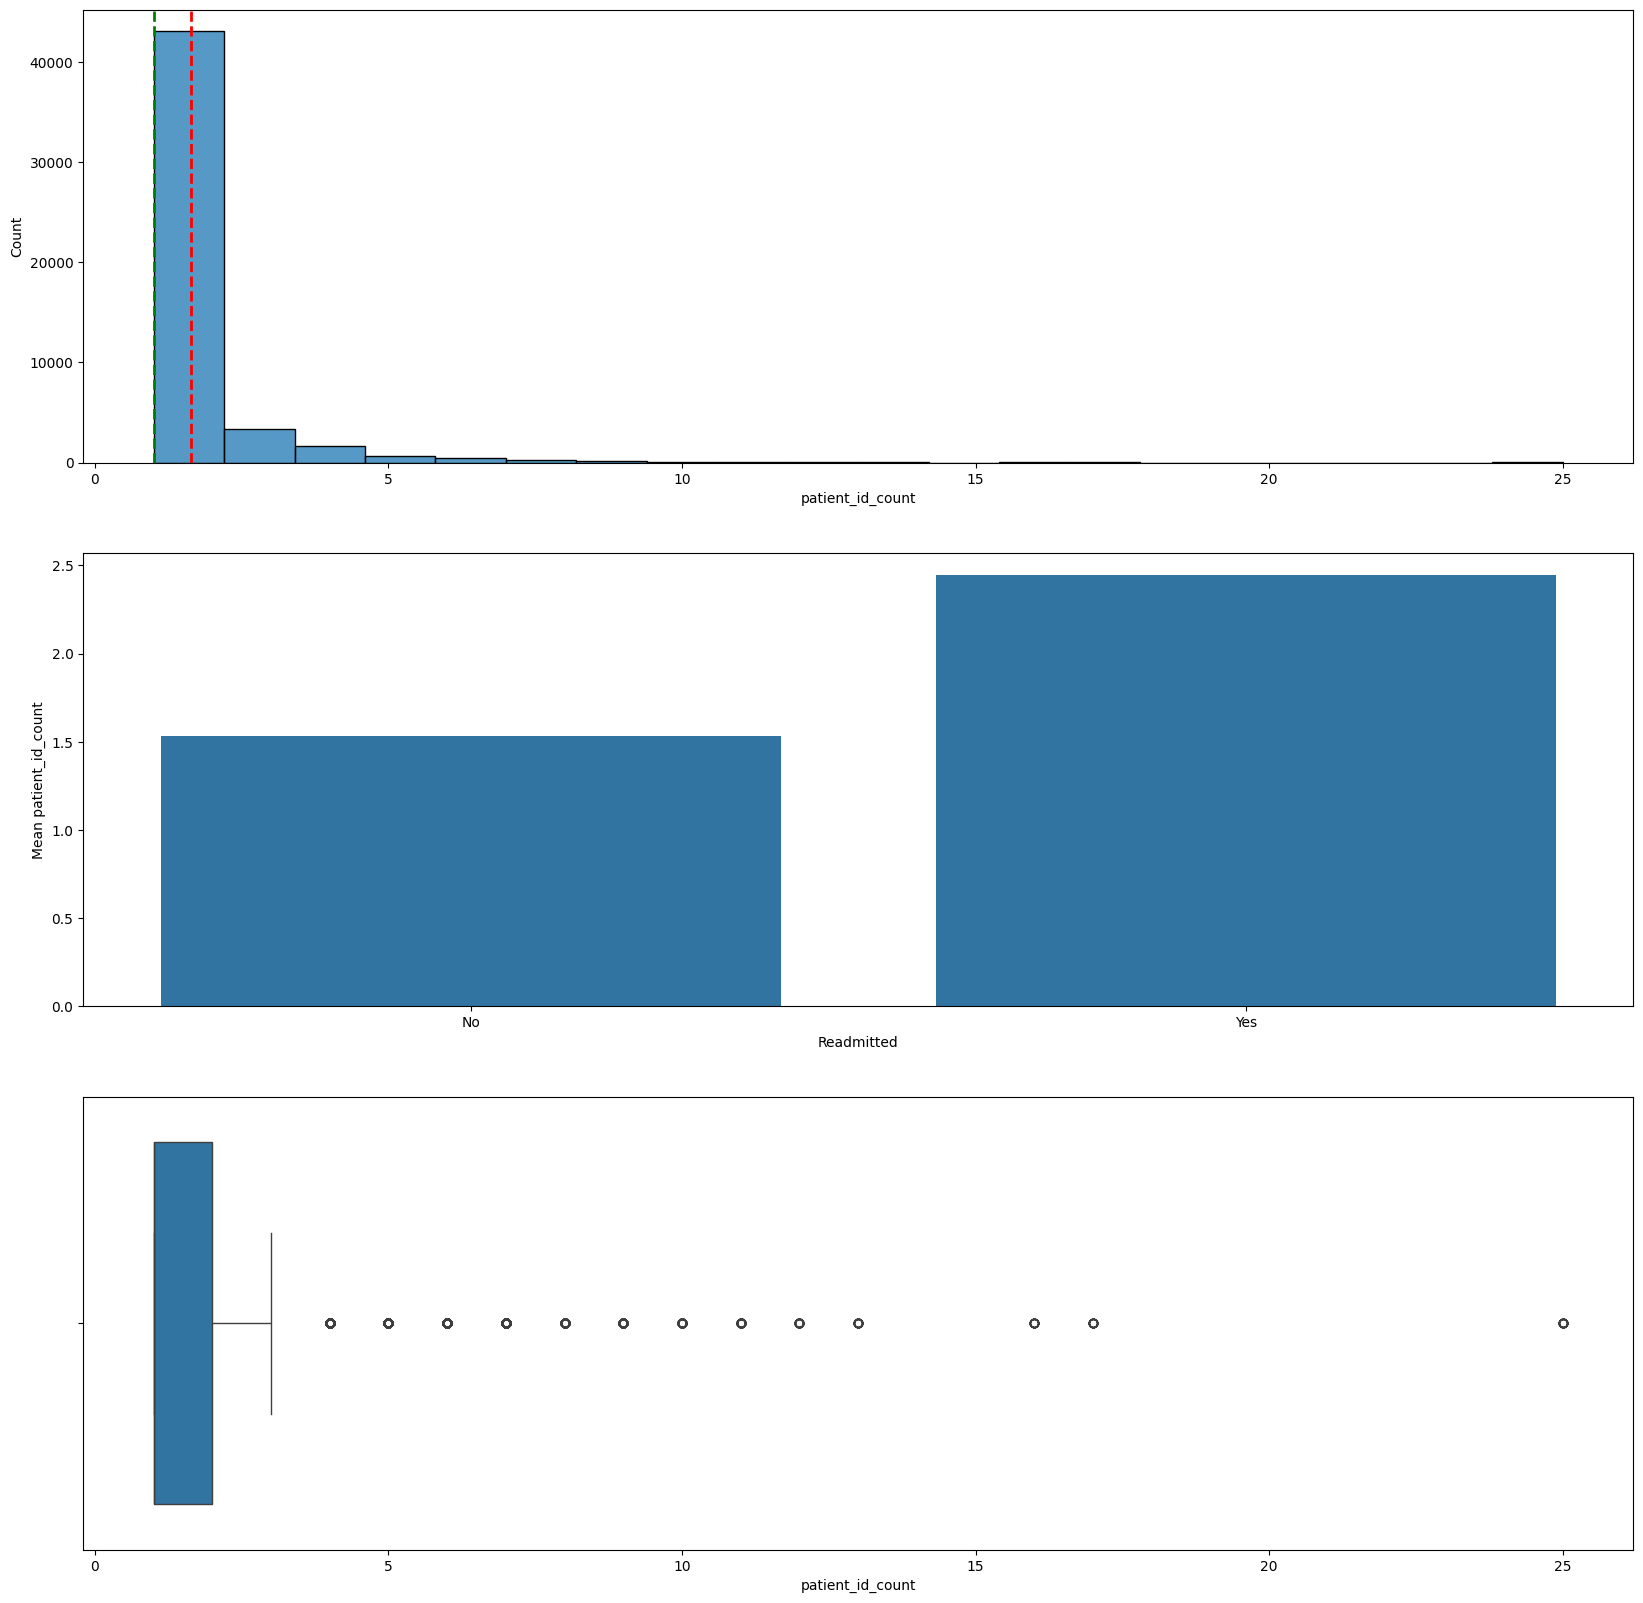

In [18]:
plt.figure(figsize = (20, 20))

plt.subplot(3, 1, 1)
sns.histplot(x = train_df["patient_id_count"], kde = False, bins=20)
plt.axvline(train_df["patient_id_count"].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df["patient_id_count"].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(3, 1, 2)
sns.barplot(x='readmitted_binary', y="patient_id_count", data=train_df, errorbar=None)
plt.xlabel('Readmitted')
plt.ylabel('Mean ' + "patient_id_count")

plt.subplot(3, 1, 3)
sns.boxplot(x=train_df['patient_id_count'])

plt.show()

### **Numeric Features**
- Looks like readmitted patients tend to make more visits to the hospital, this effect is more noticeable in the inpatient vistis
- Summing all the visits into one column "total_visits" looks like it isn´t as good as the inpatient visits column
- Some columns appear to have a lot of outliers but we will let them be for now

In [19]:
num_features = train_df.drop(['encounter_id', 'patient_id'], axis=1).select_dtypes(include=['number']).columns
print(num_features)

Index(['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses', 'patient_id_count'],
      dtype='object')


__`OBS 1`__ **Numerical data distribuition**
- Number_of_lab_tests has a weird distribuiton, a lot of observations with values around 0
- The visits features have a very right skewed distribuition

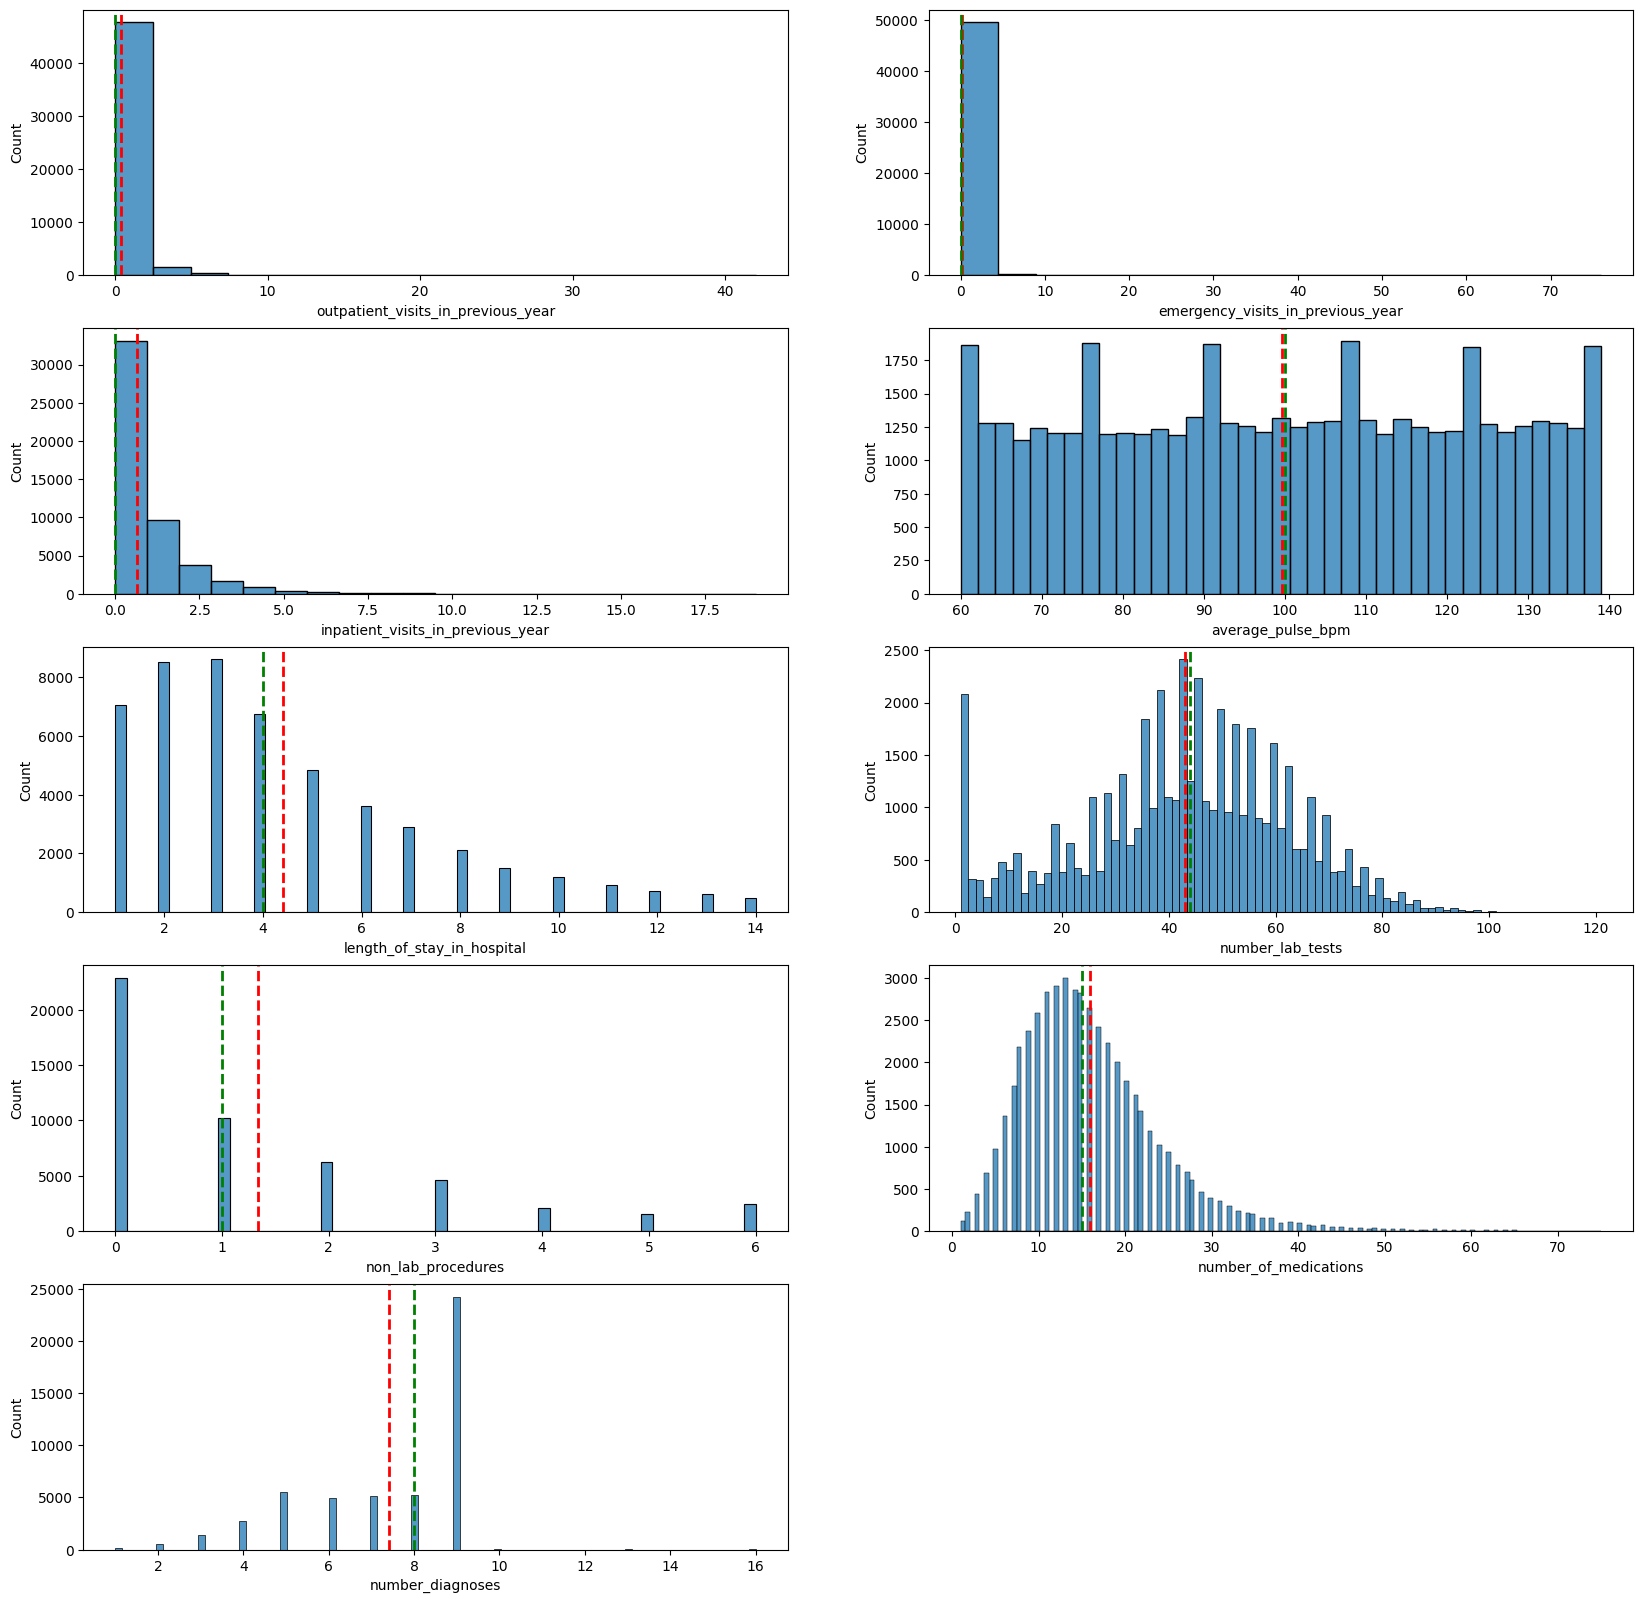

In [20]:
plt.figure(figsize = (20, 20))

plt.subplot(5, 2, 1)
sns.histplot(x = train_df['outpatient_visits_in_previous_year'], kde = False)
plt.axvline(train_df['outpatient_visits_in_previous_year'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['outpatient_visits_in_previous_year'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 2)
sns.histplot(x = train_df['emergency_visits_in_previous_year'], kde = False)
plt.axvline(train_df['emergency_visits_in_previous_year'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['emergency_visits_in_previous_year'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 3)
sns.histplot(x = train_df['inpatient_visits_in_previous_year'], kde = False, bins=20)
plt.axvline(train_df['inpatient_visits_in_previous_year'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['inpatient_visits_in_previous_year'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 4)
sns.histplot(x = train_df['average_pulse_bpm'], kde = False)
plt.axvline(train_df['average_pulse_bpm'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['average_pulse_bpm'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 5)
sns.histplot(x = train_df['length_of_stay_in_hospital'], kde = False)
plt.axvline(train_df['length_of_stay_in_hospital'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['length_of_stay_in_hospital'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 6)
sns.histplot(x = train_df['number_lab_tests'], kde = False)
plt.axvline(train_df['number_lab_tests'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['number_lab_tests'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 7)
sns.histplot(x = train_df['non_lab_procedures'], kde = False)
plt.axvline(train_df['non_lab_procedures'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['non_lab_procedures'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 8)
sns.histplot(x = train_df['number_of_medications'], kde = False)
plt.axvline(train_df['number_of_medications'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['number_of_medications'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 9)
sns.histplot(x = train_df['number_diagnoses'], kde = False)
plt.axvline(train_df['number_diagnoses'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['number_diagnoses'].median(), color='g', linestyle='dashed', linewidth=2)

#plt.savefig('numerical_features_dist.png')
plt.show()

__`OBS 2`__ **Boxplots and outliers**
- Some features seem to have outliers, but these may not be attributable to the quantity of individual data points considered as outliers

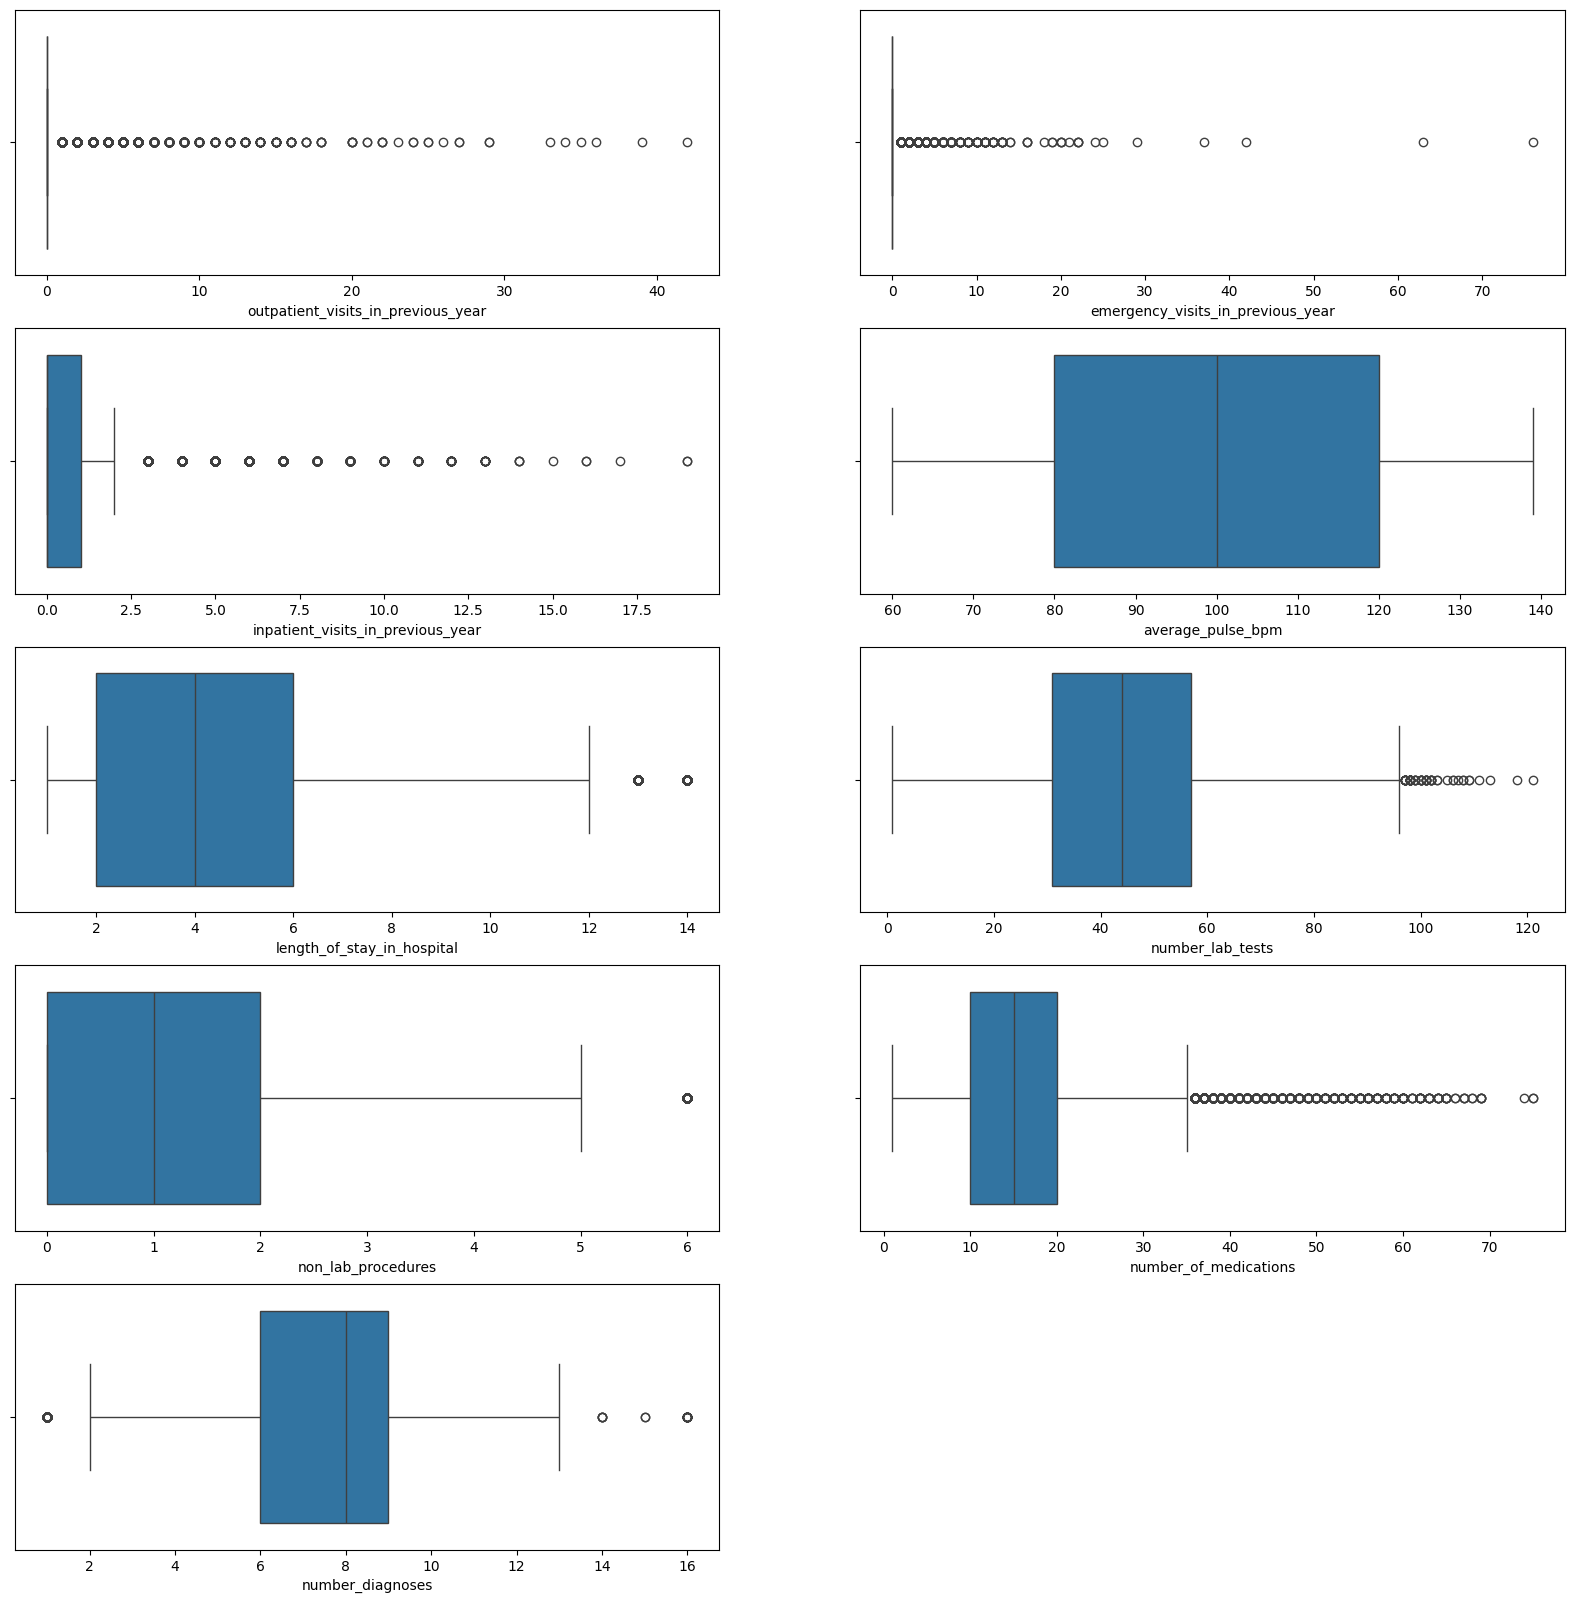

In [21]:
plt.figure(figsize=(20, 20))

plt.subplot(5, 2, 1)
sns.boxplot(x=train_df['outpatient_visits_in_previous_year'])

plt.subplot(5, 2, 2)
sns.boxplot(x=train_df['emergency_visits_in_previous_year'])

plt.subplot(5, 2, 3)
sns.boxplot(x=train_df['inpatient_visits_in_previous_year'])

plt.subplot(5, 2, 4)
sns.boxplot(x=train_df['average_pulse_bpm'])

plt.subplot(5, 2, 5)
sns.boxplot(x=train_df['length_of_stay_in_hospital'])

plt.subplot(5, 2, 6)
sns.boxplot(x=train_df['number_lab_tests'])

plt.subplot(5, 2, 7)
sns.boxplot(x=train_df['non_lab_procedures'])

plt.subplot(5, 2, 8)
sns.boxplot(x=train_df['number_of_medications'])

plt.subplot(5, 2, 9)
sns.boxplot(x=train_df['number_diagnoses'])

#plt.savefig('numerical_features_boxplot.png')
plt.show()

Checking the quantity of outliers being identified

In [22]:
# Function to calculate outliers using IQR method
def count_outliers(column, train_df, tolerance=0.1):
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 + tolerance) * IQR
    upper_bound = Q3 + (1.5 + tolerance) * IQR

    outliers = train_df[(train_df[column] < lower_bound) | (train_df[column] > upper_bound)]

    return outliers.shape[0], outliers.shape[0] / train_df.shape[0] * 100

# List of columns to check for outliers
columns_to_check = ['outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year',
                    'inpatient_visits_in_previous_year', 'average_pulse_bpm',
                    'length_of_stay_in_hospital', 'number_lab_tests',
                    'non_lab_procedures', 'number_of_medications', 'number_diagnoses']

# Create a list to store results
result_data = []

# Create new rows for each column with the count and percentage of outliers
for column in columns_to_check:
    outliers, percentage = count_outliers(column, train_df, tolerance=0.1)  # Set tolerance here
    result_data.append({'name': column, 'count': outliers, 'percentage': percentage})

# Create a DataFrame from the list
result_df = pd.DataFrame(result_data)


In [23]:
result_df

name  count  percentage
0  outpatient_visits_in_previous_year   8132   16.308032
1   emergency_visits_in_previous_year   5581   11.192219
2   inpatient_visits_in_previous_year   3452    6.922691
3                   average_pulse_bpm      0    0.000000
4          length_of_stay_in_hospital   1113    2.232026
5                    number_lab_tests     35    0.070190
6                  non_lab_procedures   2451    4.915271
7               number_of_medications   1100    2.205956
8                    number_diagnoses    148    0.296801

Now we will try to cap these outliers to see the impact on the distribuition

In [24]:
# List of columns to cap outliers
columns_to_cap = ['number_lab_tests', 'number_of_medications', 'number_diagnoses']

# Function to cap outliers based on IQR
def cap_outliers(column, train_df):
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values below the lower bound
    train_df[column] = np.where(train_df[column] < lower_bound, lower_bound, train_df[column])

    # Cap values above the upper bound
    train_df[column] = np.where(train_df[column] > upper_bound, upper_bound, train_df[column])

    return train_df

# Cap outliers for each specified column
for column in columns_to_cap:
    train_df = cap_outliers(column, train_df)

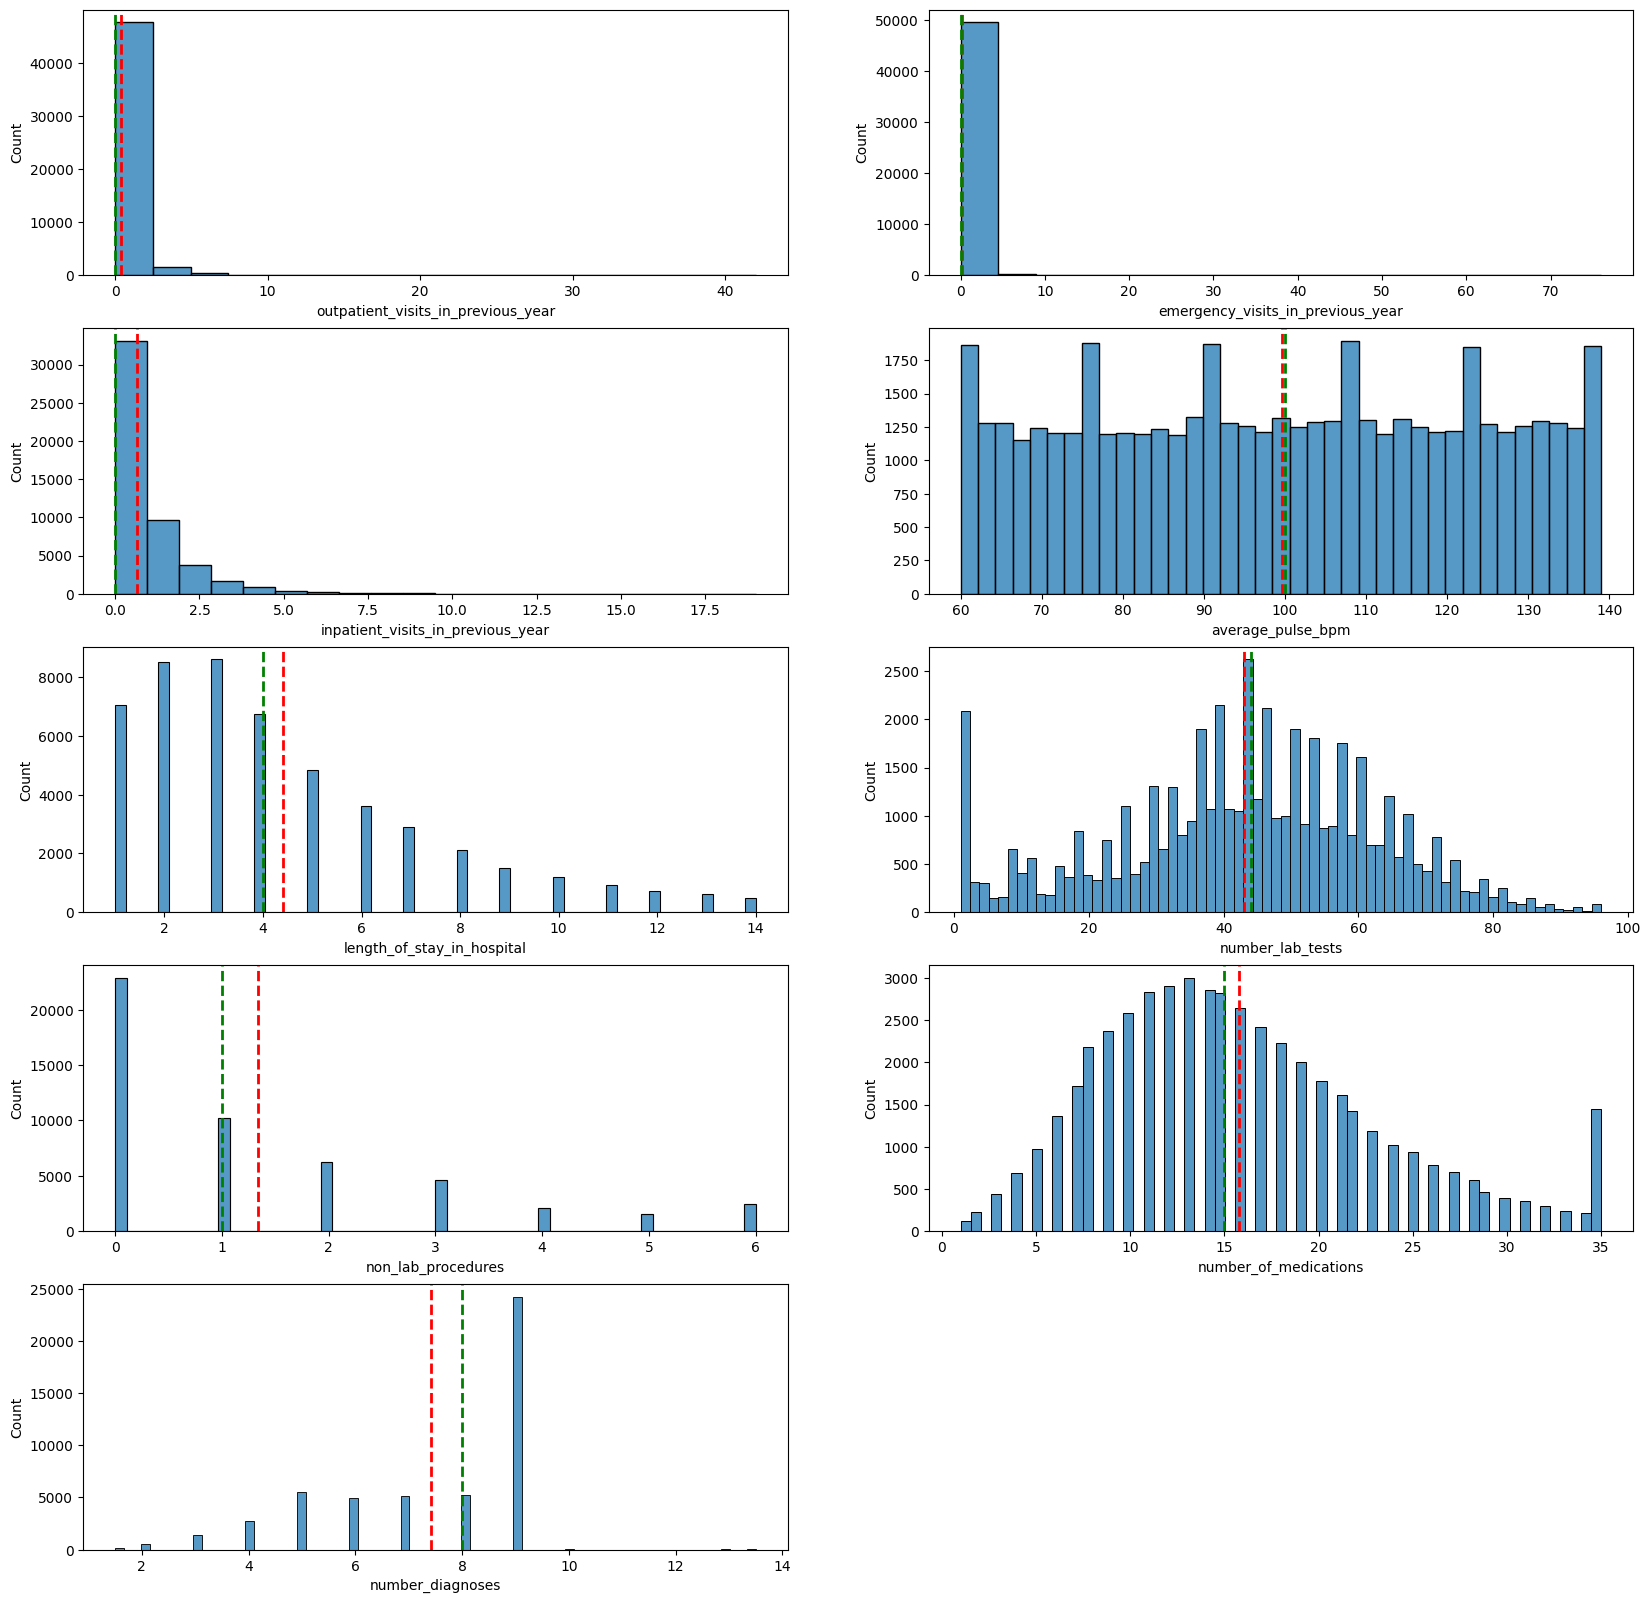

In [25]:
plt.figure(figsize = (20, 20))

plt.subplot(5, 2, 1)
sns.histplot(x = train_df['outpatient_visits_in_previous_year'], kde = False)
plt.axvline(train_df['outpatient_visits_in_previous_year'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['outpatient_visits_in_previous_year'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 2)
sns.histplot(x = train_df['emergency_visits_in_previous_year'], kde = False)
plt.axvline(train_df['emergency_visits_in_previous_year'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['emergency_visits_in_previous_year'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 3)
sns.histplot(x = train_df['inpatient_visits_in_previous_year'], kde = False, bins=20)
plt.axvline(train_df['inpatient_visits_in_previous_year'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['inpatient_visits_in_previous_year'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 4)
sns.histplot(x = train_df['average_pulse_bpm'], kde = False)
plt.axvline(train_df['average_pulse_bpm'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['average_pulse_bpm'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 5)
sns.histplot(x = train_df['length_of_stay_in_hospital'], kde = False)
plt.axvline(train_df['length_of_stay_in_hospital'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['length_of_stay_in_hospital'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 6)
sns.histplot(x = train_df['number_lab_tests'], kde = False)
plt.axvline(train_df['number_lab_tests'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['number_lab_tests'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 7)
sns.histplot(x = train_df['non_lab_procedures'], kde = False)
plt.axvline(train_df['non_lab_procedures'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['non_lab_procedures'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 8)
sns.histplot(x = train_df['number_of_medications'], kde = False)
plt.axvline(train_df['number_of_medications'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['number_of_medications'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(5, 2, 9)
sns.histplot(x = train_df['number_diagnoses'], kde = False)
plt.axvline(train_df['number_diagnoses'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['number_diagnoses'].median(), color='g', linestyle='dashed', linewidth=2)

#plt.savefig('numerical_features_dist.png')
plt.show()

__`OBS 3`__ **Correlation between numerical features**
- The numerical feature are not highly correlated

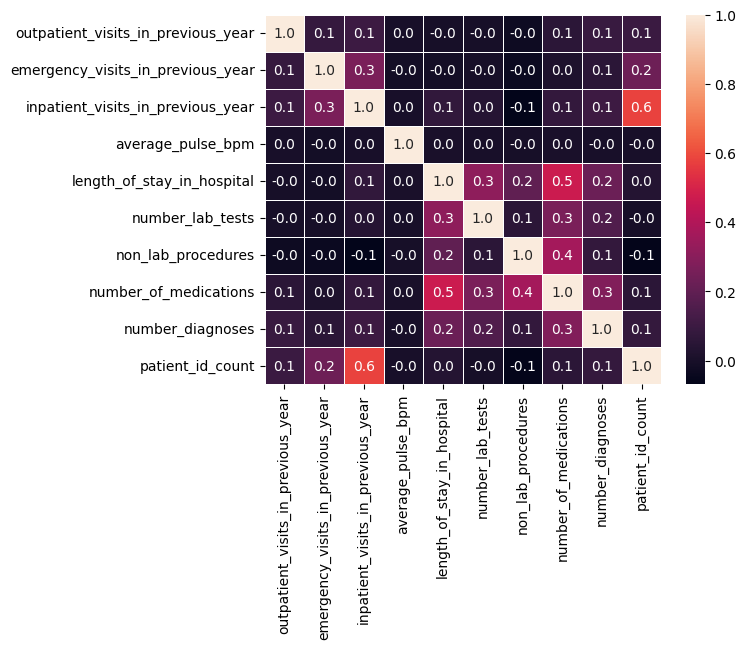

In [26]:
sns.heatmap(train_df[num_features].corr(), annot=True, linewidth=.5, fmt=".1f")
#plt.savefig('numerical_features_corr.png')
plt.show()

__`OBS 4`__ **Bivariate analysis**
- Some features look like they have not a strong relation with the target variable ('average_pulse_bpm','number_lab_tests')

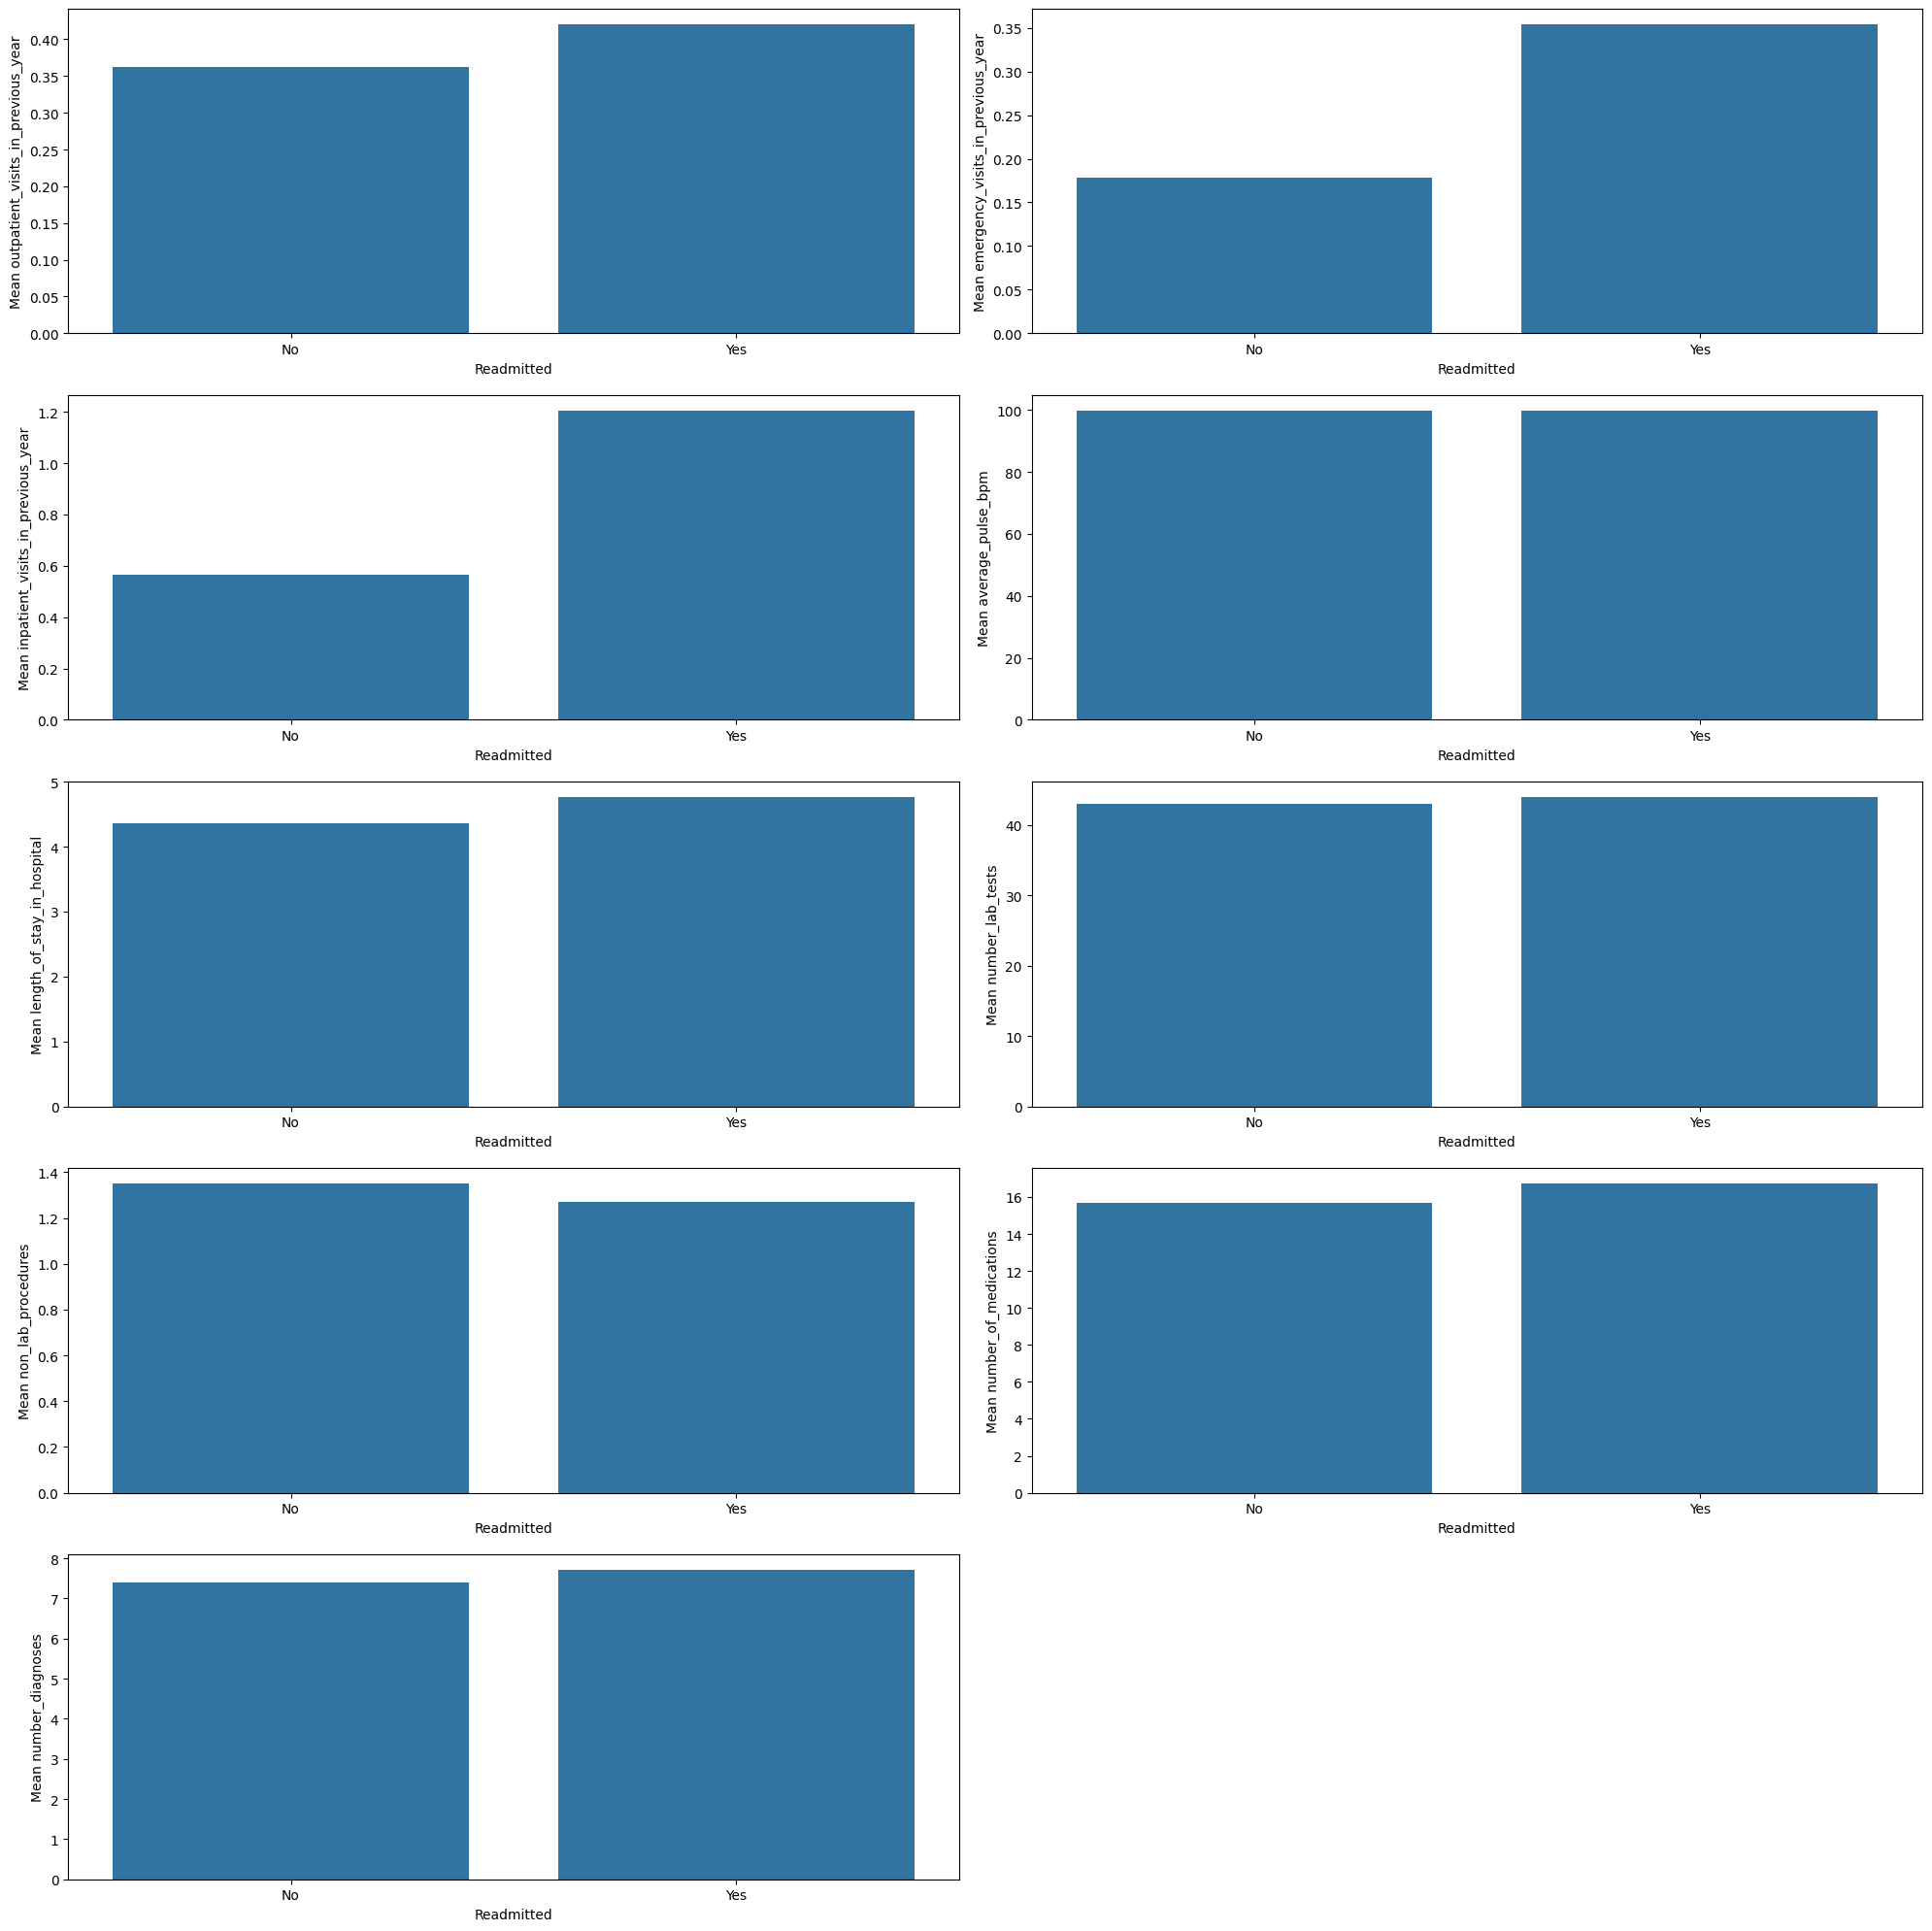

In [27]:
plt.figure(figsize=(20, 20))

features = [
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'average_pulse_bpm',
    'length_of_stay_in_hospital',
    'number_lab_tests',
    'non_lab_procedures',
    'number_of_medications',
    'number_diagnoses'
]

for i, feature in enumerate(features, start=1):
    plt.subplot(5, 2, i)
    sns.barplot(x='readmitted_binary', y=feature, data=train_df, errorbar=None)
    plt.xlabel('Readmitted')
    plt.ylabel('Mean ' + feature)

plt.tight_layout()
#plt.savefig('numerical_features_tv.png')
plt.show()




__`OBS 5`__ **Is it worth it creating a total_visits column?**
- It looks like it isn´t any better than just using the inpatient_visits column

In [28]:
train_df["total_visits"] = (train_df['outpatient_visits_in_previous_year'] + train_df['emergency_visits_in_previous_year'] + train_df[ 'inpatient_visits_in_previous_year'])

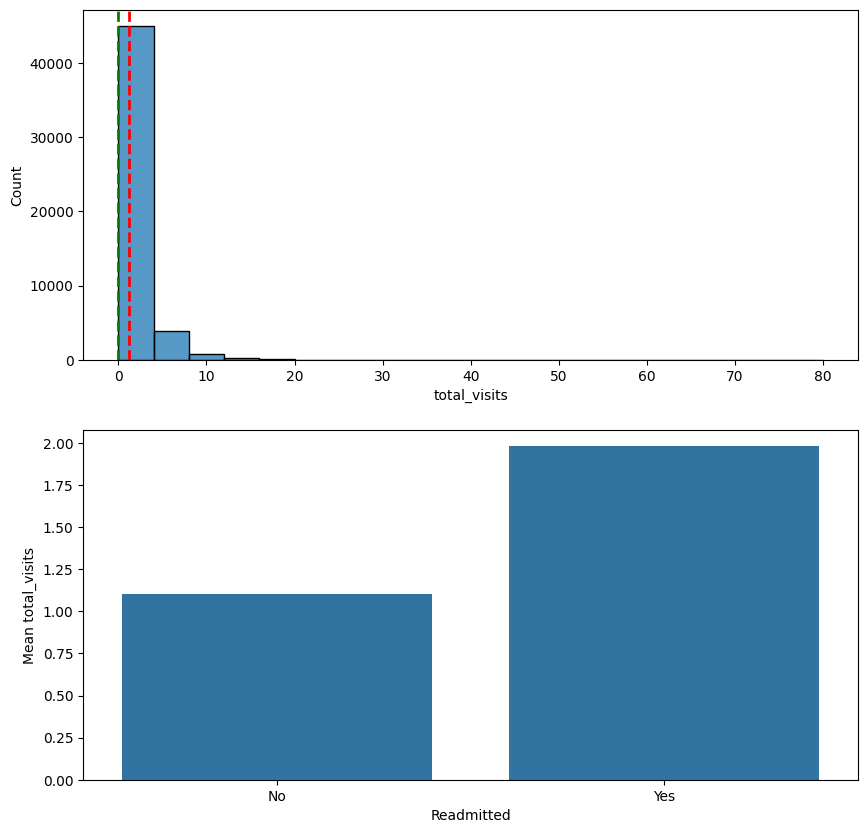

In [29]:
plt.figure(figsize = (10, 10))

plt.subplot(2, 1, 1)
sns.histplot(x = train_df['total_visits'], kde = False, bins=20)
plt.axvline(train_df['total_visits'].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df['total_visits'].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(2, 1, 2)
sns.barplot(x='readmitted_binary', y='total_visits', data=train_df, errorbar=None)
plt.xlabel('Readmitted')
plt.ylabel('Mean ' + 'total_visits')

plt.show()

### **Categorical Features**  🛠️
- None of the categorical features appear to have a abnormal relation with the target variable

__`OBS 5`__ **Chekcing the cardinality of the categorical features**

In [30]:
object_features = train_df.drop(['readmitted_binary'], axis=1).select_dtypes(include=['object']).columns
print(object_features)

Index(['country', 'race', 'gender', 'age', 'weight', 'payer_code',
       'admission_type', 'medical_specialty', 'discharge_disposition',
       'admission_source', 'primary_diagnosis', 'secondary_diagnosis',
       'additional_diagnosis', 'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication'],
      dtype='object')


In [31]:
data = []

# Populate the list with dictionaries containing column names and their cardinality
for column in object_features:
    cardinality = train_df[column].nunique()
    data.append({'Column Name': column, 'Cardinality': cardinality})

# Create a DataFrame from the list of dictionaries
cardinality_table = pd.DataFrame(data)
cardinality_table

Column Name  Cardinality
0                                 country            1
1                                    race            6
2                                  gender            3
3                                     age           10
4                                  weight           10
5                              payer_code           18
6                          admission_type            7
7                       medical_specialty           68
8                   discharge_disposition           24
9                        admission_source           16
10                      primary_diagnosis          648
11                    secondary_diagnosis          657
12                   additional_diagnosis          698
13                    glucose_test_result            3
14                        a1c_test_result            3
15  change_in_meds_during_hospitalization            2
16               prescribed_diabetes_meds            2
17                             medication          275

Splitting the categorical features based on the cardinality

In [32]:
low_cardinality = ['country', 'race','gender','age','admission_type','glucose_test_result','a1c_test_result','change_in_meds_during_hospitalization','prescribed_diabetes_meds']
high_cardinality = ['payer_code', 'medical_specialty', 'discharge_disposition', 'admission_source', 'primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis', 'medication']

#### **Low Cardinality**
- The column country only has 1 value, we can delete this column
- This dataset has a lot of diabetes patients

__`OBS 6`__ **Distribuition of the low cardinality categorical features**
- Some features have wierd values like "?"

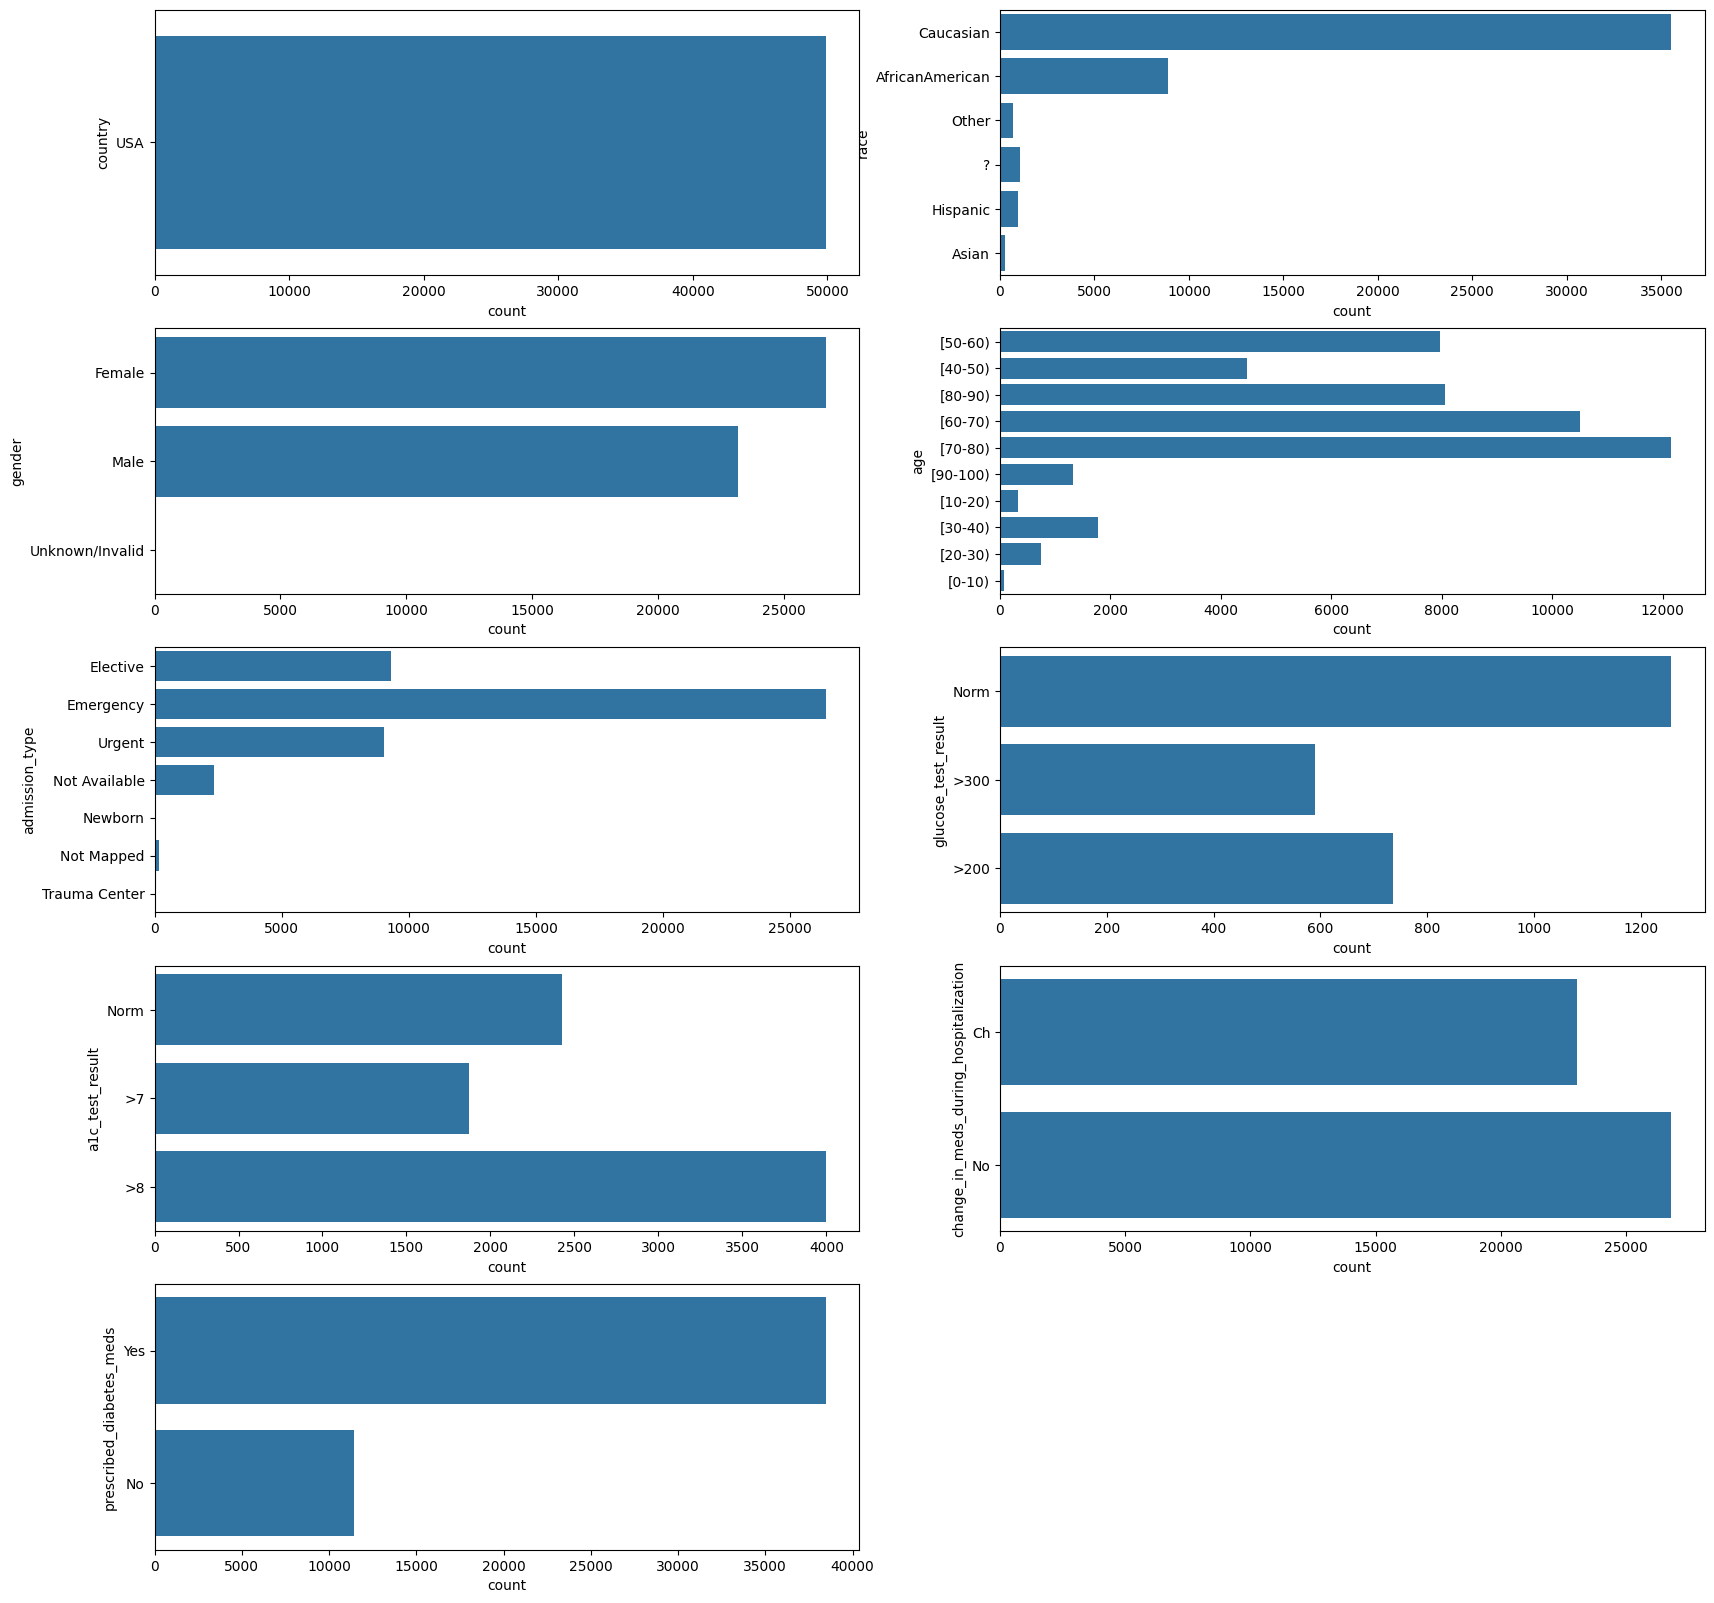

In [33]:
plt.figure(figsize=(20, 20))

plt.subplot(5, 2, 1)
sns.countplot(data = train_df, y = 'country')

plt.subplot(5, 2, 2)
sns.countplot(data = train_df, y = 'race')

plt.subplot(5, 2, 3)
sns.countplot(data = train_df, y = 'gender')

plt.subplot(5, 2, 4)
sns.countplot(data = train_df, y = 'age')

plt.subplot(5, 2, 5)
sns.countplot(data = train_df, y = 'admission_type')

plt.subplot(5, 2, 6)
sns.countplot(data = train_df, y = 'glucose_test_result')

plt.subplot(5, 2, 7)
sns.countplot(data = train_df, y = 'a1c_test_result')

plt.subplot(5, 2, 8)
sns.countplot(data = train_df, y = 'change_in_meds_during_hospitalization')

plt.subplot(5, 2, 9)
sns.countplot(data = train_df, y = 'prescribed_diabetes_meds')

#plt.savefig("low_card_barplot.png")
plt.show()

__`OBS 7`__ **Replacing weird and unusual values ("race", "gender")**

In [34]:
train_df['race'] = train_df['race'].replace('?', 'Other')
train_df['gender'] = train_df['gender'].replace('Unknown/Invalid', 'Female')

In [35]:
train_df[low_cardinality].isna().sum()

country                                      0
race                                      2460
gender                                       0
age                                       2511
admission_type                            2595
glucose_test_result                      47281
a1c_test_result                          41570
change_in_meds_during_hospitalization        0
prescribed_diabetes_meds                     0
dtype: int64

__`OBS 8`__ **'glucose_test_result' and 'a1c_test_result' missing values represent "Not measured"**

In [36]:
columns_to_fill = ['glucose_test_result', 'a1c_test_result']
fill_value = 'Not Measured'

# Fill missing values with 'Not Measured' for the specified columns
train_df[columns_to_fill] = train_df[columns_to_fill].fillna(fill_value)

__`OBS 9`__ **Filling missing values with the mode**

In [37]:
# Assuming 'race', 'gender', 'age', and 'admission_type' are the columns you want to modify
columns_to_fill = ['race', 'gender', 'age', 'admission_type']

# Fill missing values with the mode for the specified columns
for column in columns_to_fill:
    mode_value = train_df[column].mode().iloc[0]
    train_df[column] = train_df[column].fillna(mode_value)

In [38]:
train_df[low_cardinality].isna().sum()

country                                  0
race                                     0
gender                                   0
age                                      0
admission_type                           0
glucose_test_result                      0
a1c_test_result                          0
change_in_meds_during_hospitalization    0
prescribed_diabetes_meds                 0
dtype: int64

__`OBS 10`__ **Checking the distribuition after missing values imputation**

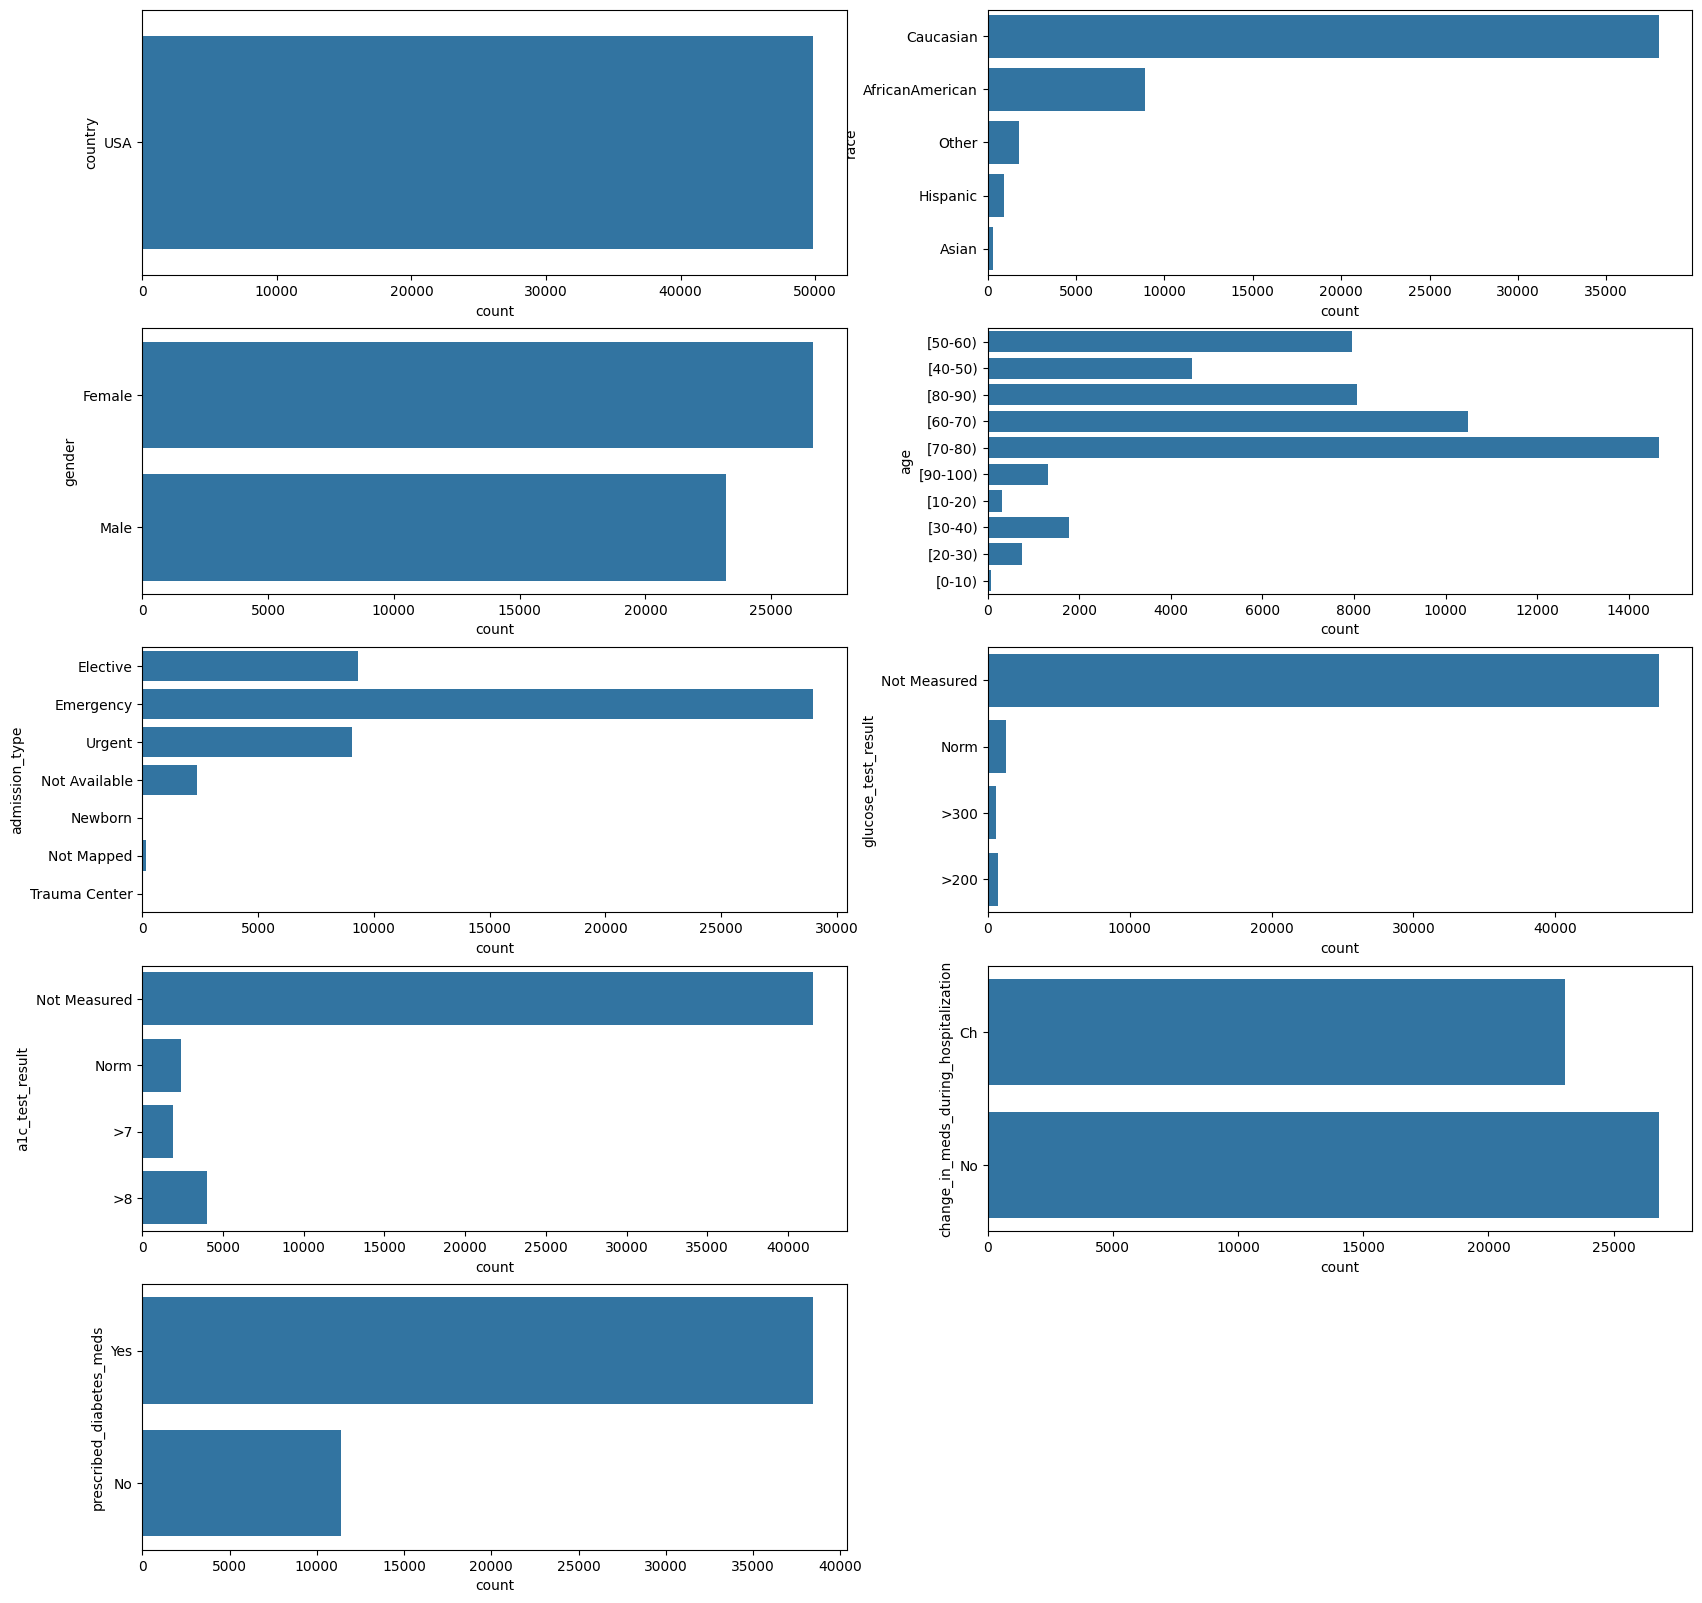

In [39]:
plt.figure(figsize=(20, 20))

plt.subplot(5, 2, 1)
sns.countplot(data = train_df, y = 'country')

plt.subplot(5, 2, 2)
sns.countplot(data = train_df, y = 'race')

plt.subplot(5, 2, 3)
sns.countplot(data = train_df, y = 'gender')

plt.subplot(5, 2, 4)
sns.countplot(data = train_df, y = 'age')

plt.subplot(5, 2, 5)
sns.countplot(data = train_df, y = 'admission_type')

plt.subplot(5, 2, 6)
sns.countplot(data = train_df, y = 'glucose_test_result')

plt.subplot(5, 2, 7)
sns.countplot(data = train_df, y = 'a1c_test_result')

plt.subplot(5, 2, 8)
sns.countplot(data = train_df, y = 'change_in_meds_during_hospitalization')

plt.subplot(5, 2, 9)
sns.countplot(data = train_df, y = 'prescribed_diabetes_meds')

#plt.savefig("low_cardinality_barplots_2")
plt.show()

__`OBS 11`__ **Bivariate analysis**
- None of the categorical features have a abnormal influence on the target variable

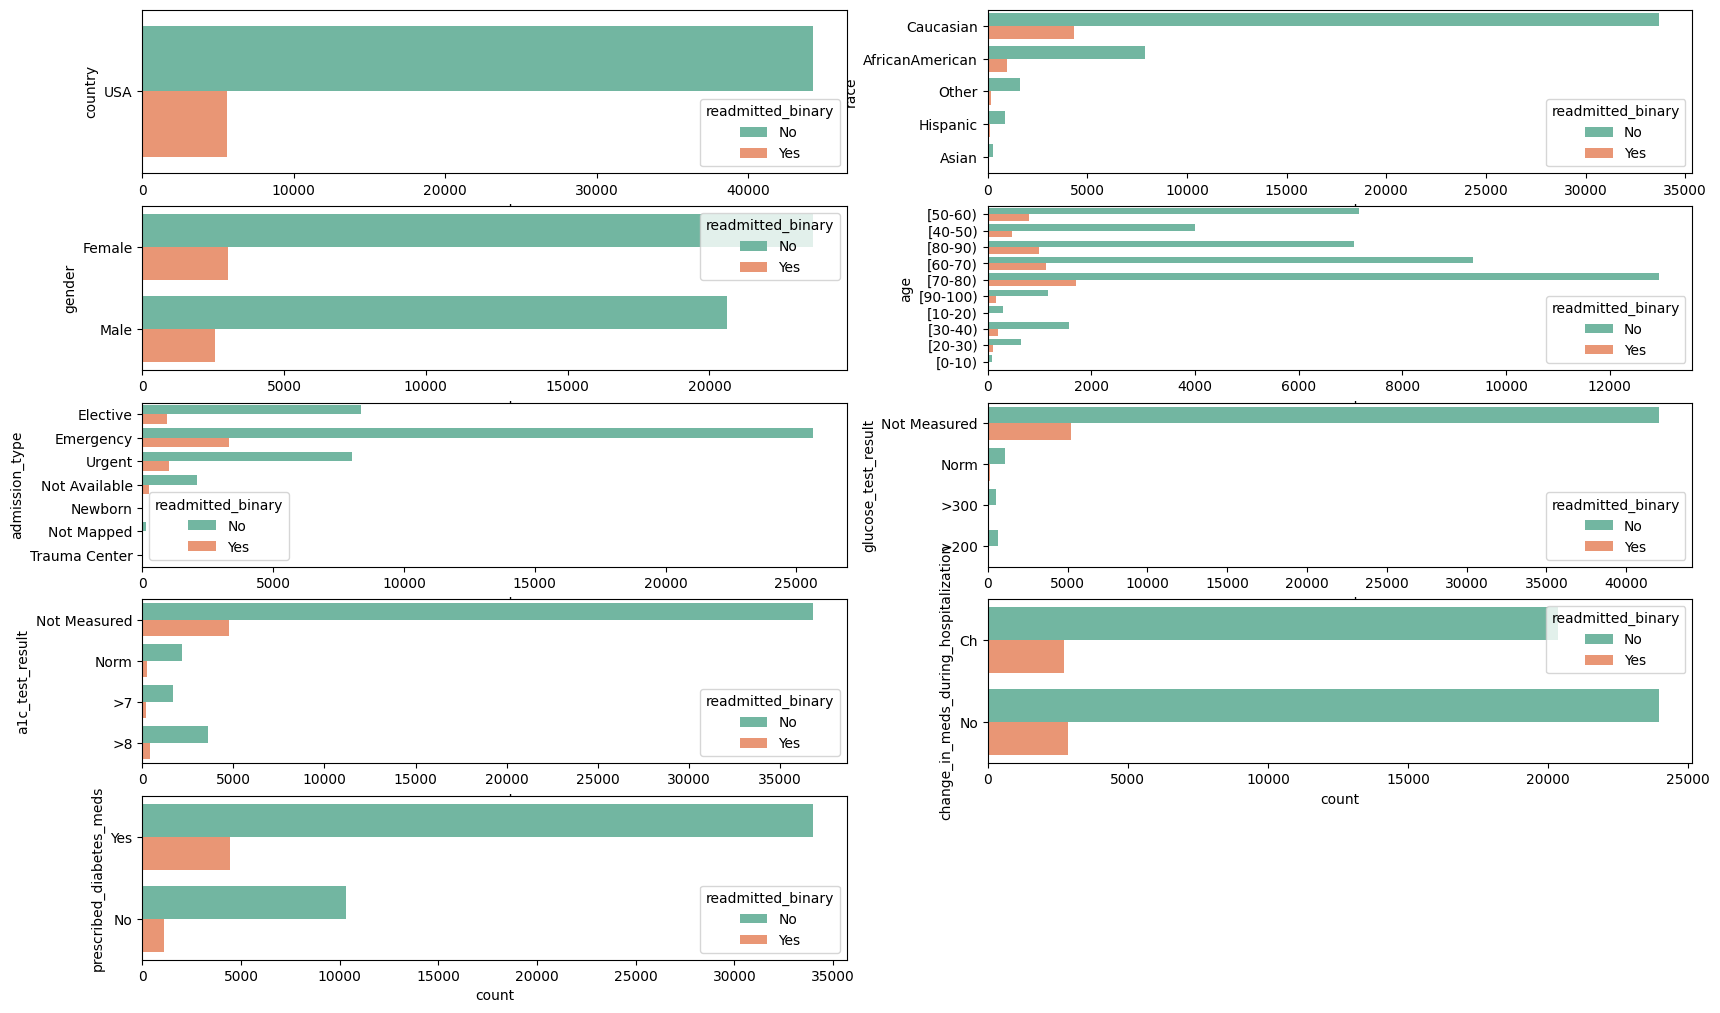

In [40]:
plt.figure(figsize=(20, 20))

plt.subplot(8, 2, 1)
sns.countplot(y = 'country', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(8, 2, 2)
sns.countplot(y = 'race', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(8, 2, 3)
sns.countplot(y = 'gender', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(8, 2, 4)
sns.countplot(y = 'age', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(8, 2, 5)
sns.countplot(y = 'admission_type', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(8, 2, 6)
sns.countplot(y = 'glucose_test_result', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(8, 2, 7)
sns.countplot(y = 'a1c_test_result', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(8, 2, 8)
sns.countplot(y = 'change_in_meds_during_hospitalization', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(8, 2, 9)
sns.countplot(y = 'prescribed_diabetes_meds', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.show()

__`OBS 12`__ **Looking at the proportions of each class**
- The age appears to have a little bit of a influence in the readmission proportion
- The rest of the categories dont have a strong influence in the readmission proportion

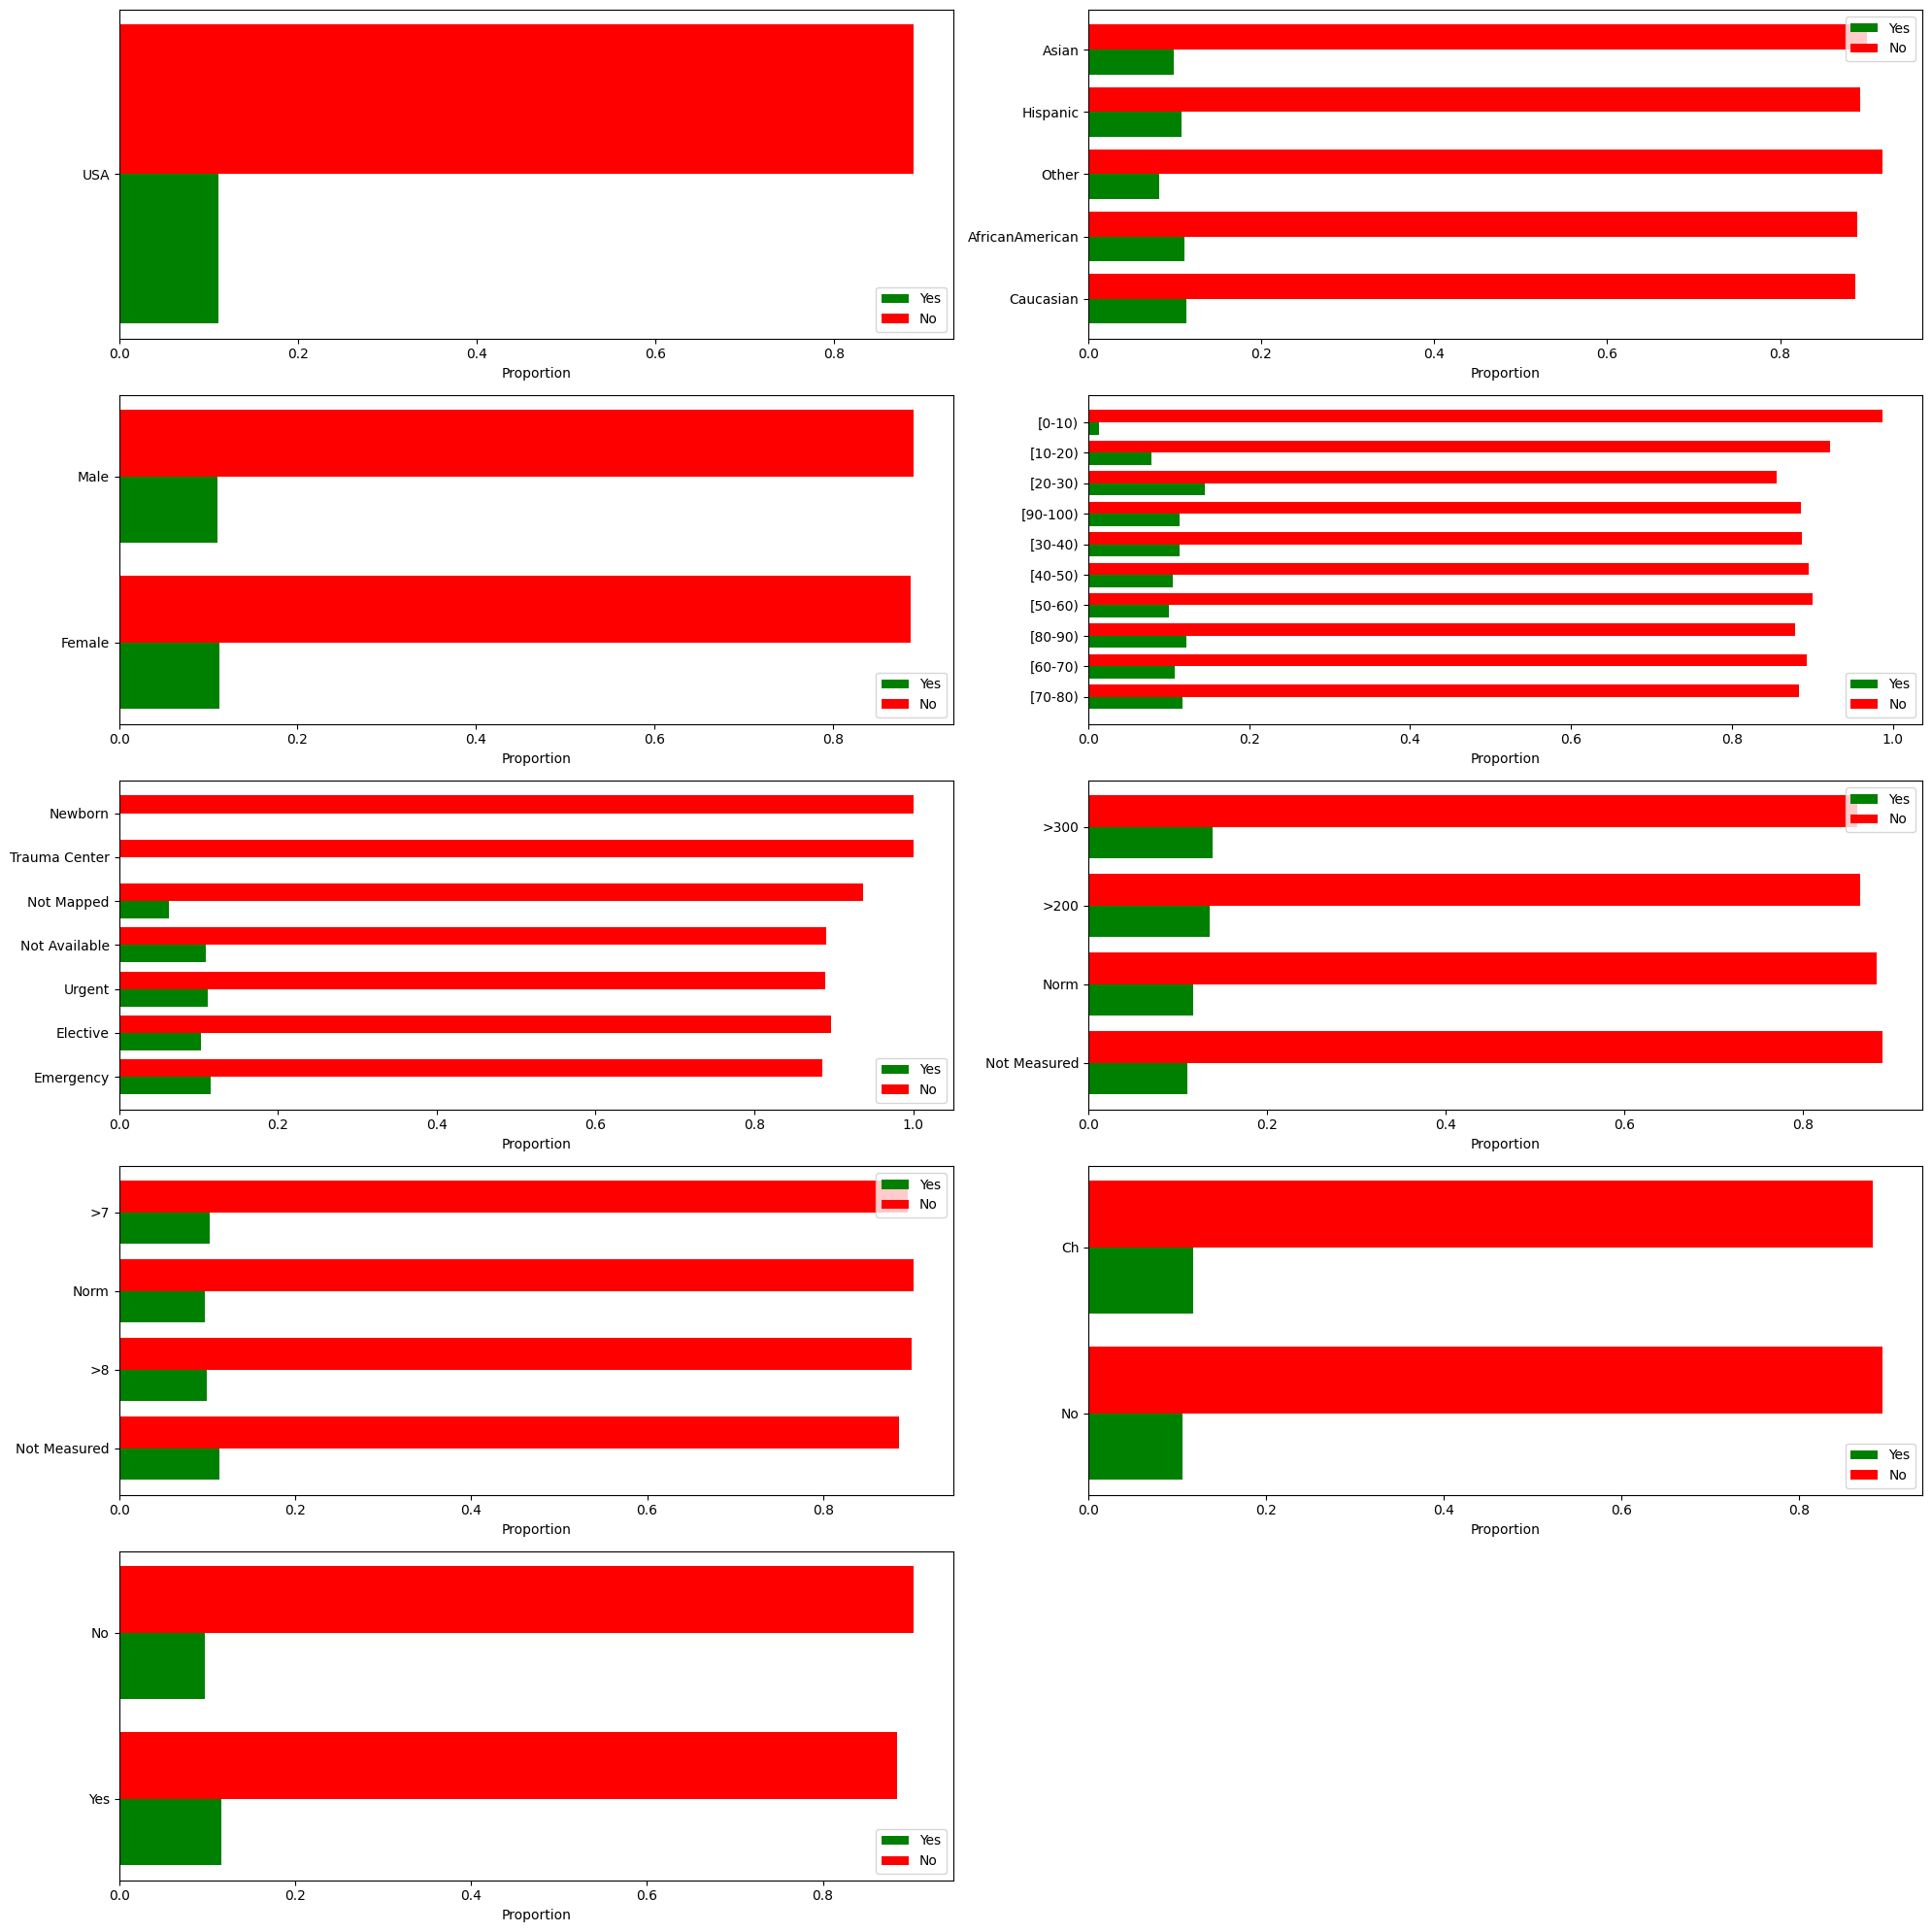

In [41]:
plt.figure(figsize=(20, 20))

def plot_proportions(data, feature, ax):
    counts = data[feature].value_counts()
    total_count = len(data)
    yes_proportions = []
    no_proportions = []
    
    for value in counts.index:
        subset = data[data[feature] == value]
        yes_count = len(subset[subset['readmitted_binary'] == 'Yes'])
        no_count = len(subset[subset['readmitted_binary'] == 'No'])
        
        yes_proportion = yes_count / len(subset)
        no_proportion = no_count / len(subset)
        
        yes_proportions.append(yes_proportion)
        no_proportions.append(no_proportion)
    
    bar_width = 0.4
    positions = np.arange(len(counts))
    
    ax.barh(positions - bar_width/2, yes_proportions, height=bar_width, label='Yes', color='green')
    ax.barh(positions + bar_width/2, no_proportions, height=bar_width, label='No', color='red')
    
    ax.set_yticks(positions)
    ax.set_yticklabels(counts.index)
    ax.set_xlabel('Proportion')
    ax.legend()

plot_proportions(train_df, 'country', plt.subplot(5, 2, 1))
plot_proportions(train_df, 'race', plt.subplot(5, 2, 2))
plot_proportions(train_df, 'gender', plt.subplot(5, 2, 3))
plot_proportions(train_df, 'age', plt.subplot(5, 2, 4))
plot_proportions(train_df, 'admission_type', plt.subplot(5, 2, 5))
plot_proportions(train_df, 'glucose_test_result', plt.subplot(5, 2, 6))
plot_proportions(train_df, 'a1c_test_result', plt.subplot(5, 2, 7))
plot_proportions(train_df, 'change_in_meds_during_hospitalization', plt.subplot(5, 2, 8))
plot_proportions(train_df, 'prescribed_diabetes_meds', plt.subplot(5, 2, 9))

plt.tight_layout()
#plt.savefig("low_cat_prop.png")
plt.show()


__`OBS 13`__ **Feature engineering the age column**
- Instead of having a categorical feature in the 'age' column, you can replace the age intervals with random ages within each interval.

In [42]:
def _generate_random_age(interval):
    if pd.notna(interval) and '[' in interval:
        lower_bound = int(interval.split('-')[0][1:])
        upper_bound = int(interval.split('-')[1][:-1])
        return np.random.randint(lower_bound, upper_bound)
    else:
        return np.nan
        
train_df["age"] = train_df["age"].map(_generate_random_age)
train_df["age"] = pd.to_numeric(train_df["age"], errors='coerce')

In [43]:
column_names = ['original_age', 'modified_age']

age_comparison = pd.concat([train_df_original['age'], train_df['age']], axis=1, keys=column_names)
age_comparison.head()

original_age  modified_age
58848      [50-60)            59
69977      [40-50)            41
70394      [80-90)            84
34010      [50-60)            50
17436      [60-70)            68

__`OBS 14`__ **Taking a Look at the Modified Age Column**
- Taking a look at the modified age column
- Upon examination, it's evident that the majority of the dataset comprises older individuals. However, it's noteworthy that the younger patients are being identified as outliers by the IQR (Interquartile Range) method.
- Surprisingly, the age column doesn't seem to exhibit a significant relationship with the readmission outcome.

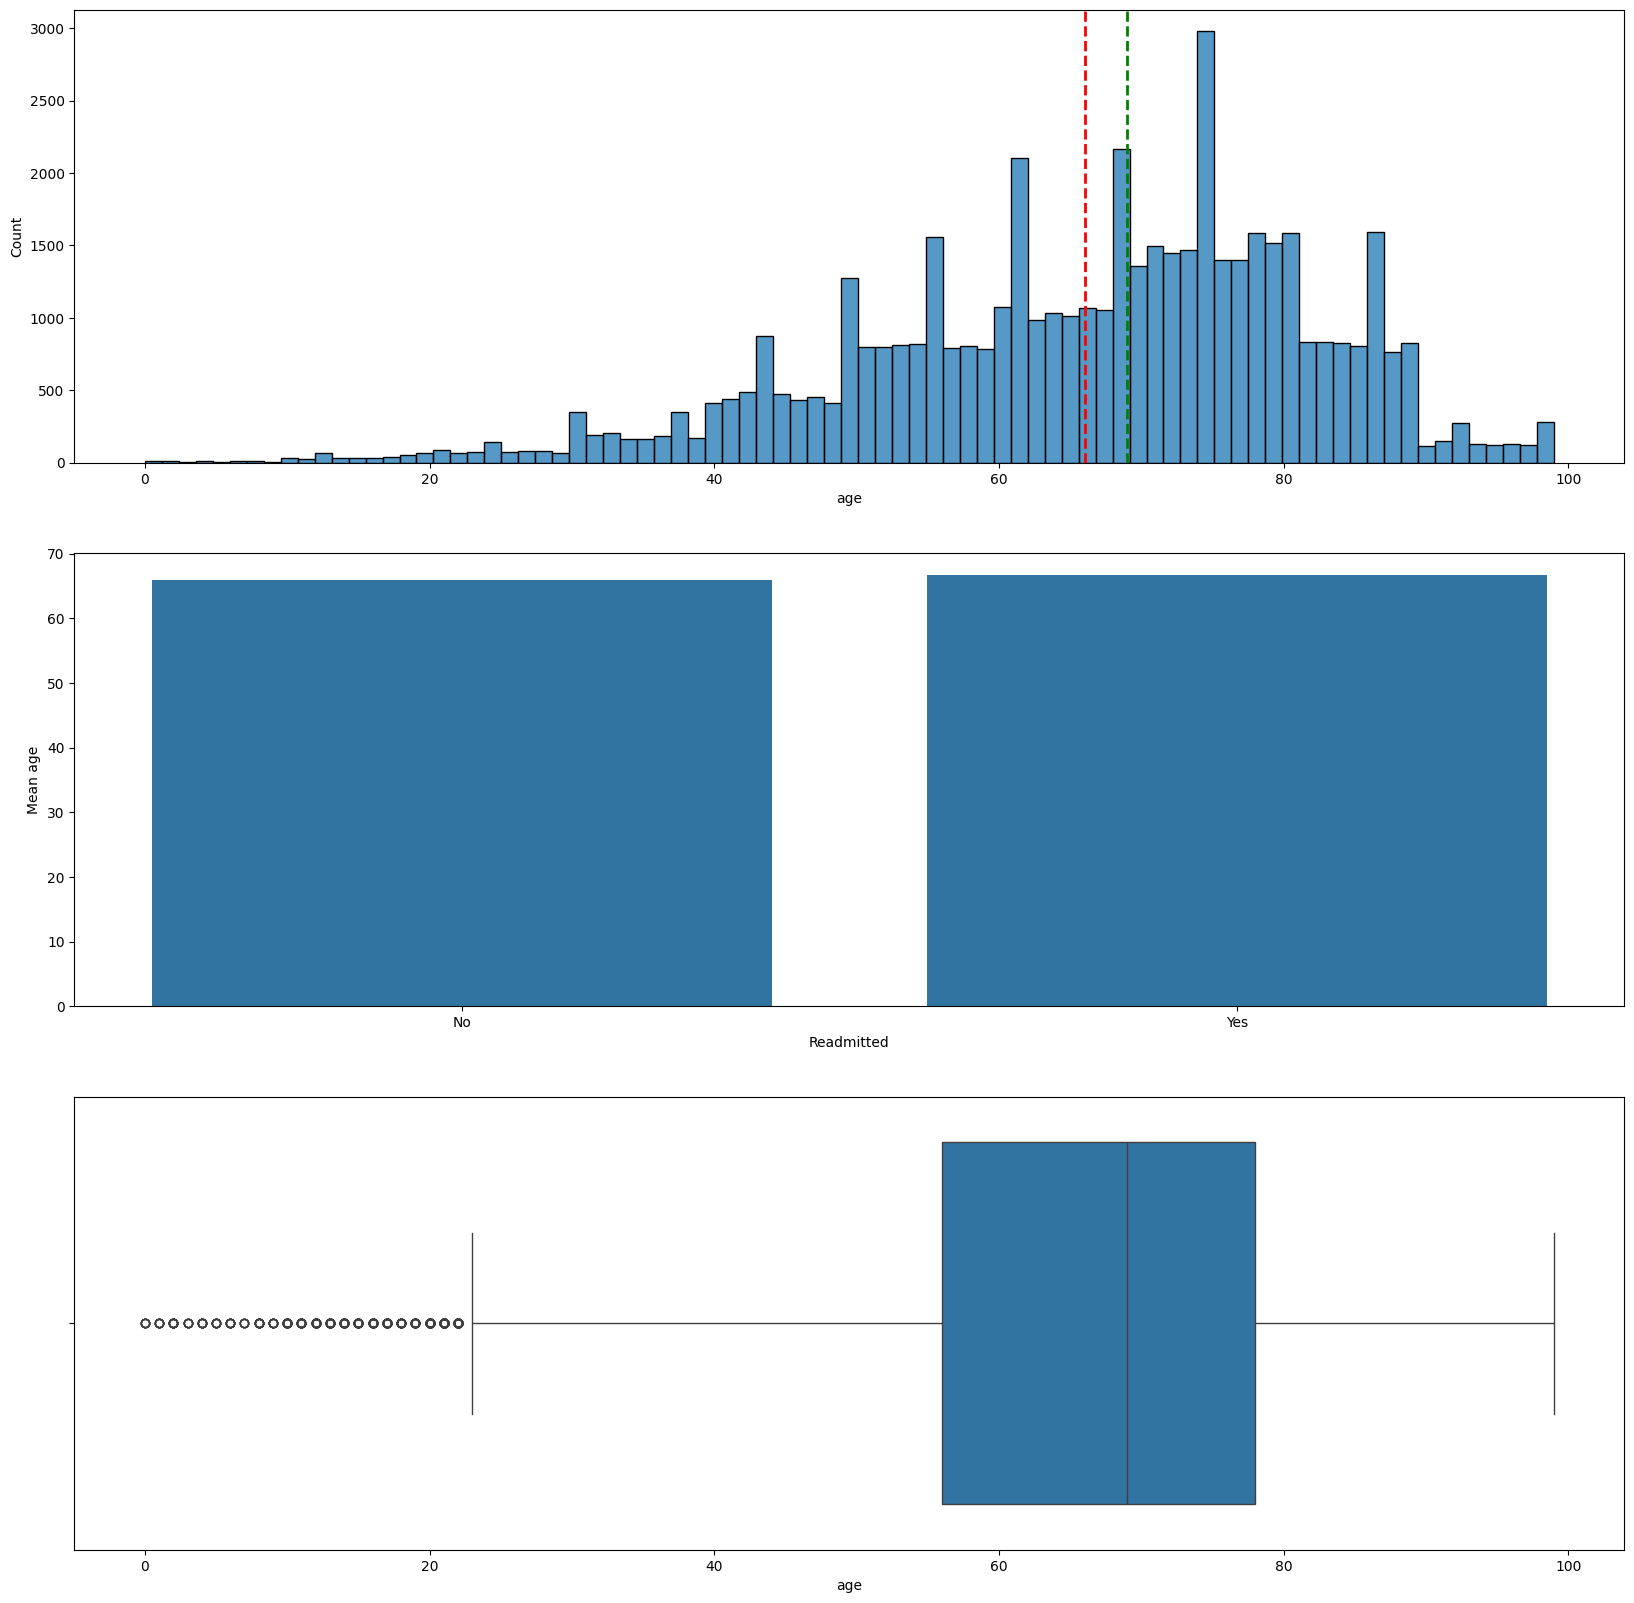

In [44]:
plt.figure(figsize = (20, 20))

plt.subplot(3, 1, 1)
sns.histplot(x = train_df["age"], kde = False)
plt.axvline(train_df["age"].mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(train_df["age"].median(), color='g', linestyle='dashed', linewidth=2)

plt.subplot(3, 1, 2)
sns.barplot(x='readmitted_binary', y="age", data=train_df, errorbar=None)
plt.xlabel('Readmitted')
plt.ylabel('Mean ' + "age")

plt.subplot(3, 1, 3)
sns.boxplot(x=train_df['age'])

plt.show()

#### **High Cardinality** 🛠️

In [45]:
train_df[high_cardinality].isna().sum()

payer_code                  0
medical_specialty           0
discharge_disposition    1800
admission_source         3343
primary_diagnosis           0
secondary_diagnosis         0
additional_diagnosis        0
medication                  0
dtype: int64

__`OBS 15`__ **Filling the missing values with the mode**

In [46]:
columns_to_fill = ['discharge_disposition', 'admission_source']

# Fill missing values with the mode for the specified columns
for column in columns_to_fill:
    mode_value = train_df[column].mode().iloc[0]
    train_df[column] = train_df[column].fillna(mode_value)

In [47]:
train_df[high_cardinality].isna().sum()

payer_code               0
medical_specialty        0
discharge_disposition    0
admission_source         0
primary_diagnosis        0
secondary_diagnosis      0
additional_diagnosis     0
medication               0
dtype: int64

__`OBS 16`__ **Taking a look at the payer code feature**
- Replacing the "?" with "None"

In [48]:
train_df["payer_code"].value_counts()

payer_code
?     19715
MC    15946
HM     2949
SP     2507
BC     2290
MD     1761
CP     1241
UN     1188
CM      945
OG      512
PO      284
DM      272
WC       69
CH       67
OT       46
MP       41
SI       31
FR        1
Name: count, dtype: int64

In [49]:
train_df['payer_code'] = train_df['payer_code'].replace('?', 'None')

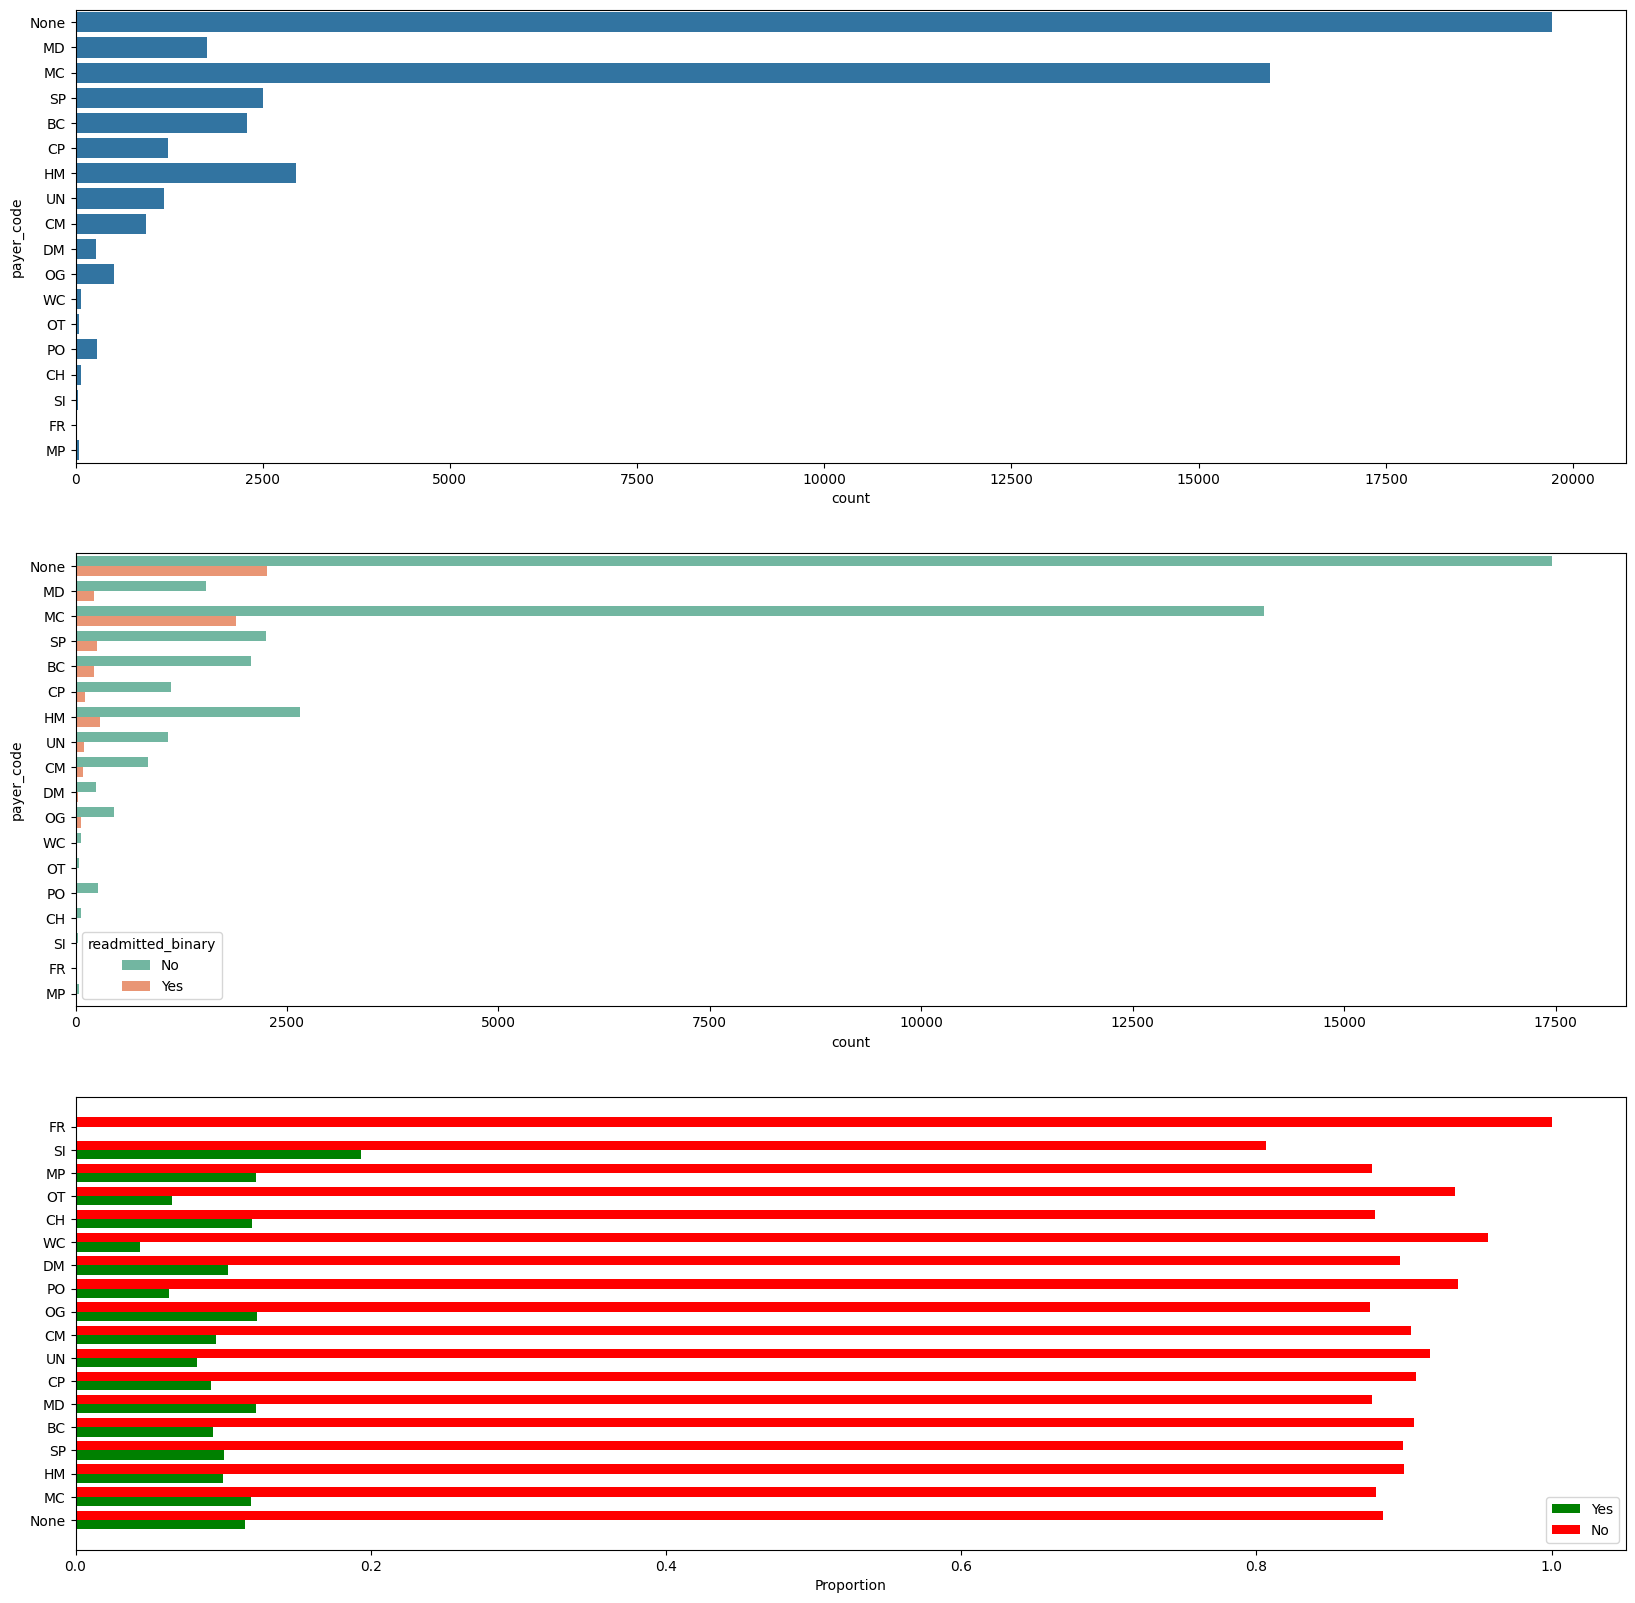

In [50]:
plt.figure(figsize = (20, 20))

plt.subplot(3, 1, 1)
sns.countplot(data = train_df, y = 'payer_code')

plt.subplot(3, 1, 2)
sns.countplot(y = 'payer_code', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plot_proportions(train_df, 'payer_code', plt.subplot(3, 1, 3))

plt.show()

__`OBS 17`__ **Lets try to group some rare categories into a "Others" bin to reduce the cardinality**

In [51]:
threshold = 500
rare_specialties = train_df['payer_code'].value_counts()[train_df['payer_code'].value_counts() < threshold].index
train_df['payer_code_grouped'] = train_df['payer_code'].apply(lambda x: x if x not in rare_specialties else 'Other')

In [52]:
train_df['payer_code_grouped'].unique()

array(['None', 'MD', 'MC', 'SP', 'BC', 'CP', 'HM', 'UN', 'CM', 'Other',
       'OG'], dtype=object)

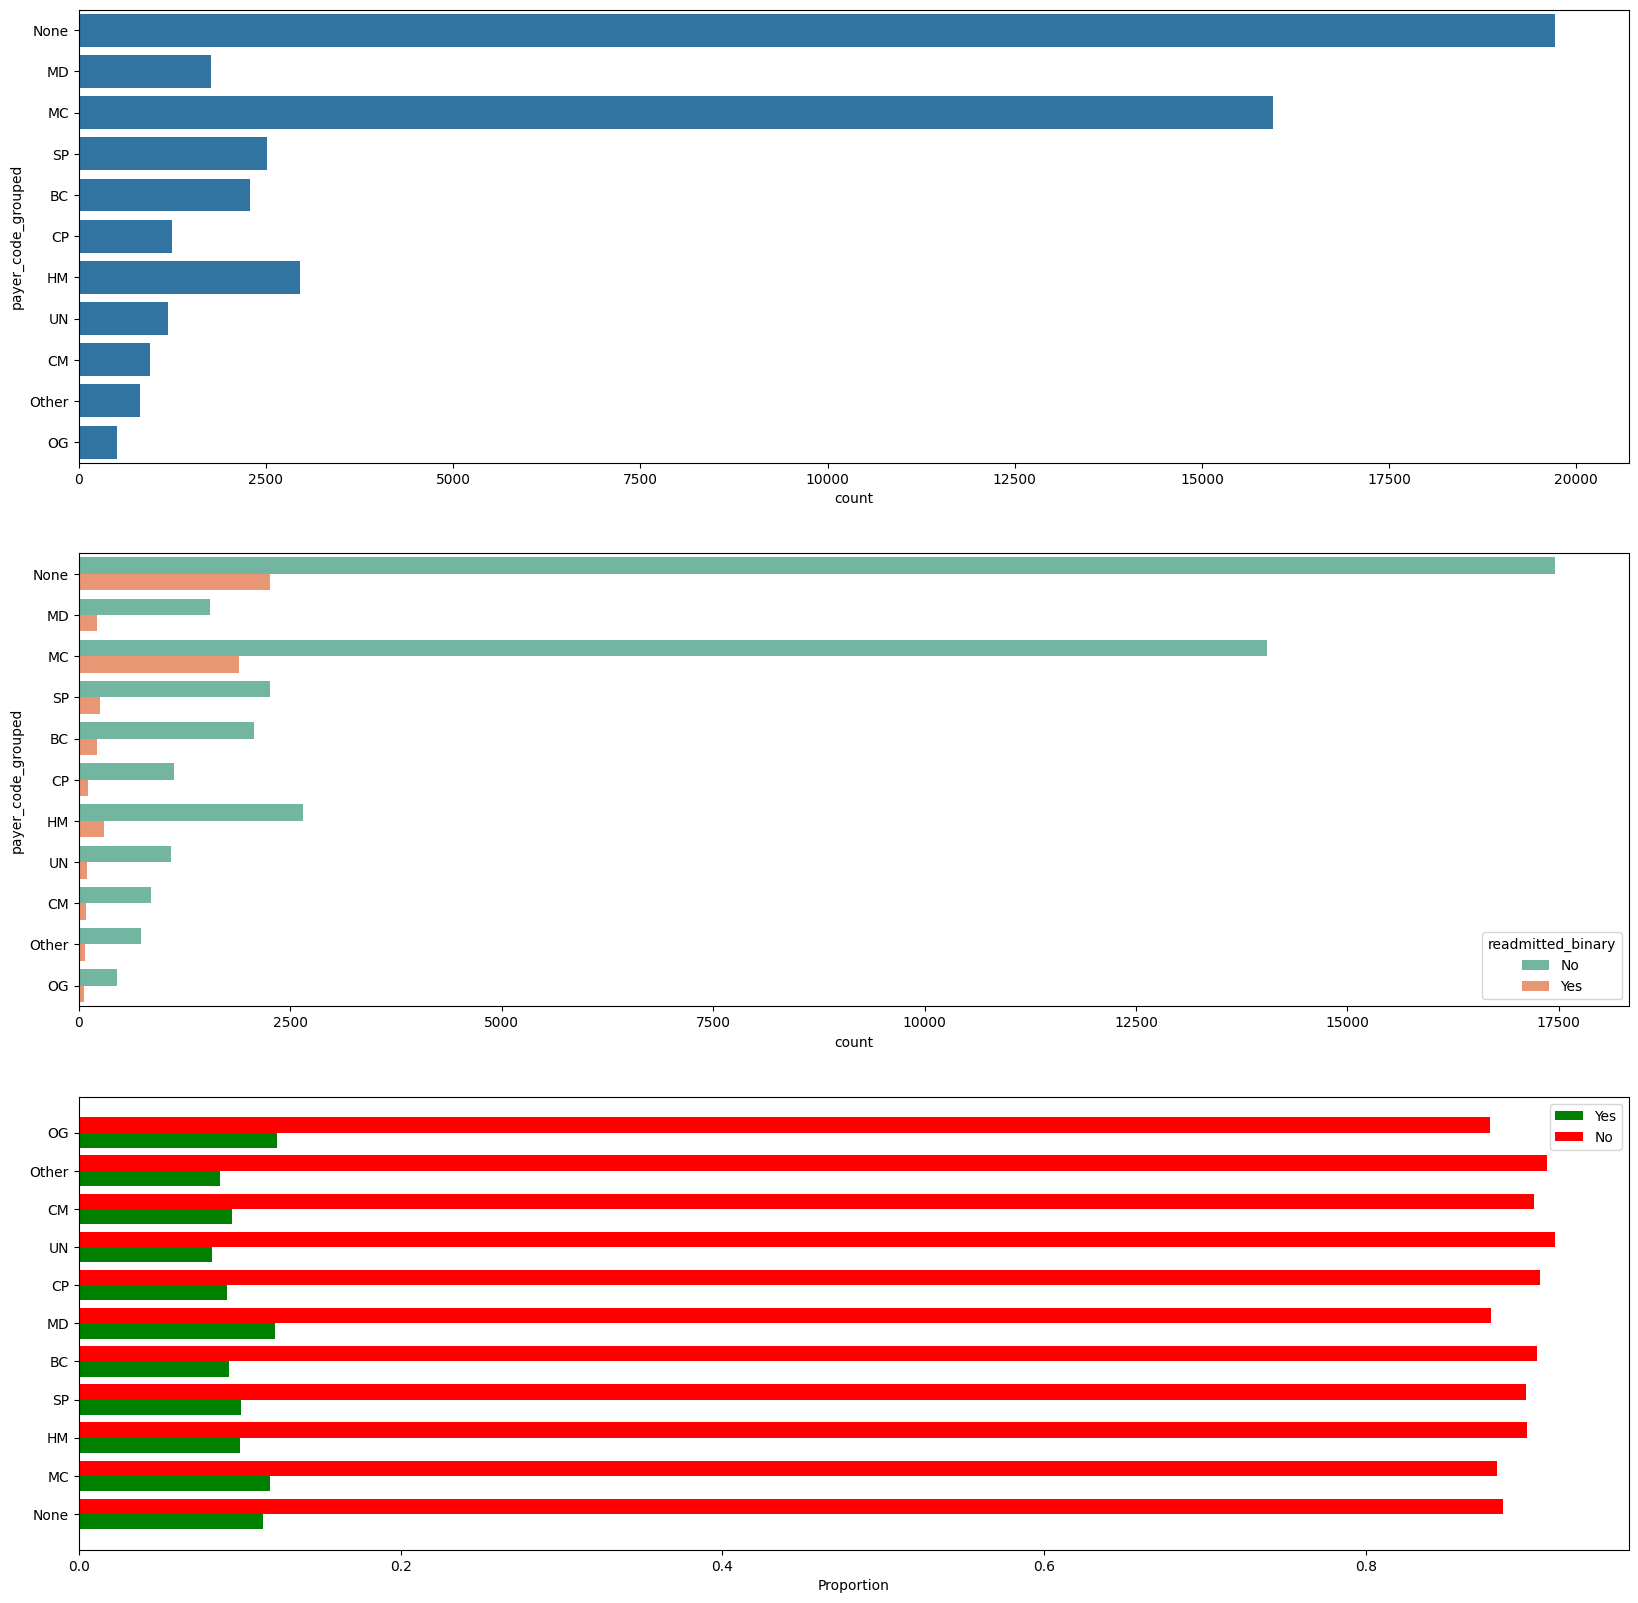

In [53]:
plt.figure(figsize = (20, 20))

plt.subplot(3, 1, 1)
sns.countplot(data = train_df, y = 'payer_code_grouped')

plt.subplot(3, 1, 2)
sns.countplot(y = 'payer_code_grouped', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plot_proportions(train_df, 'payer_code_grouped', plt.subplot(3, 1, 3))

plt.show()

__`OBS 17`__ **Exploring Variation in Readmission Probability Based on Payer Code**
- Upon visual inspection of the plots, it's discernible that there is some variation in the readmission probability based on the payer code. However, this relationship does not appear to be very strong.


__`OBS 18`__ **Medical_specialty**
- We have a lot of "?" values

In [54]:
train_df["medical_specialty"].value_counts()

medical_specialty
?                                24433
InternalMedicine                  7180
Emergency/Trauma                  3732
Family/GeneralPractice            3637
Cardiology                        2632
                                 ...  
Pediatrics-EmergencyMedicine         1
Speech                               1
Resident                             1
Pediatrics-InfectiousDiseases        1
Neurophysiology                      1
Name: count, Length: 68, dtype: int64

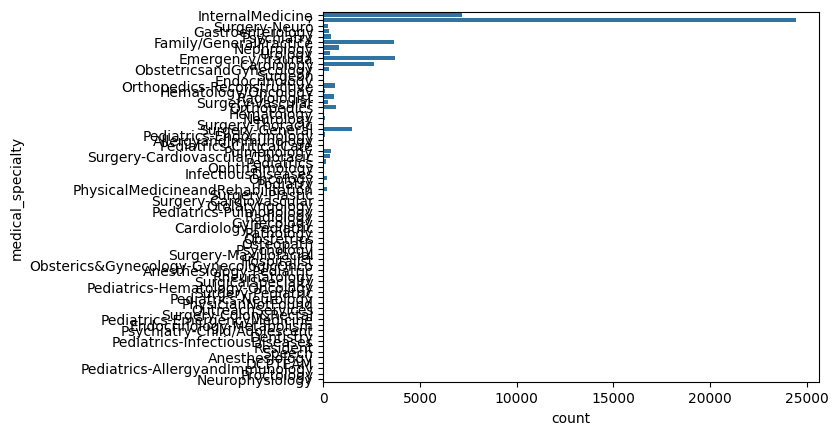

In [55]:
sns.countplot(data = train_df, y = 'medical_specialty')
plt.show()

__`OBS 19`__ **Let's try to group some unusual categories into a "Other" category**
- As we have seen in the "payer_code" feature we have some variability in the probability of being readmitted based on the medical specialtie

In [56]:
threshold = 500
rare_specialties = train_df['medical_specialty'].value_counts()[train_df['medical_specialty'].value_counts() < threshold].index
train_df['medical_specialty_grouped'] = train_df['medical_specialty'].apply(lambda x: x if x not in rare_specialties else 'Other')

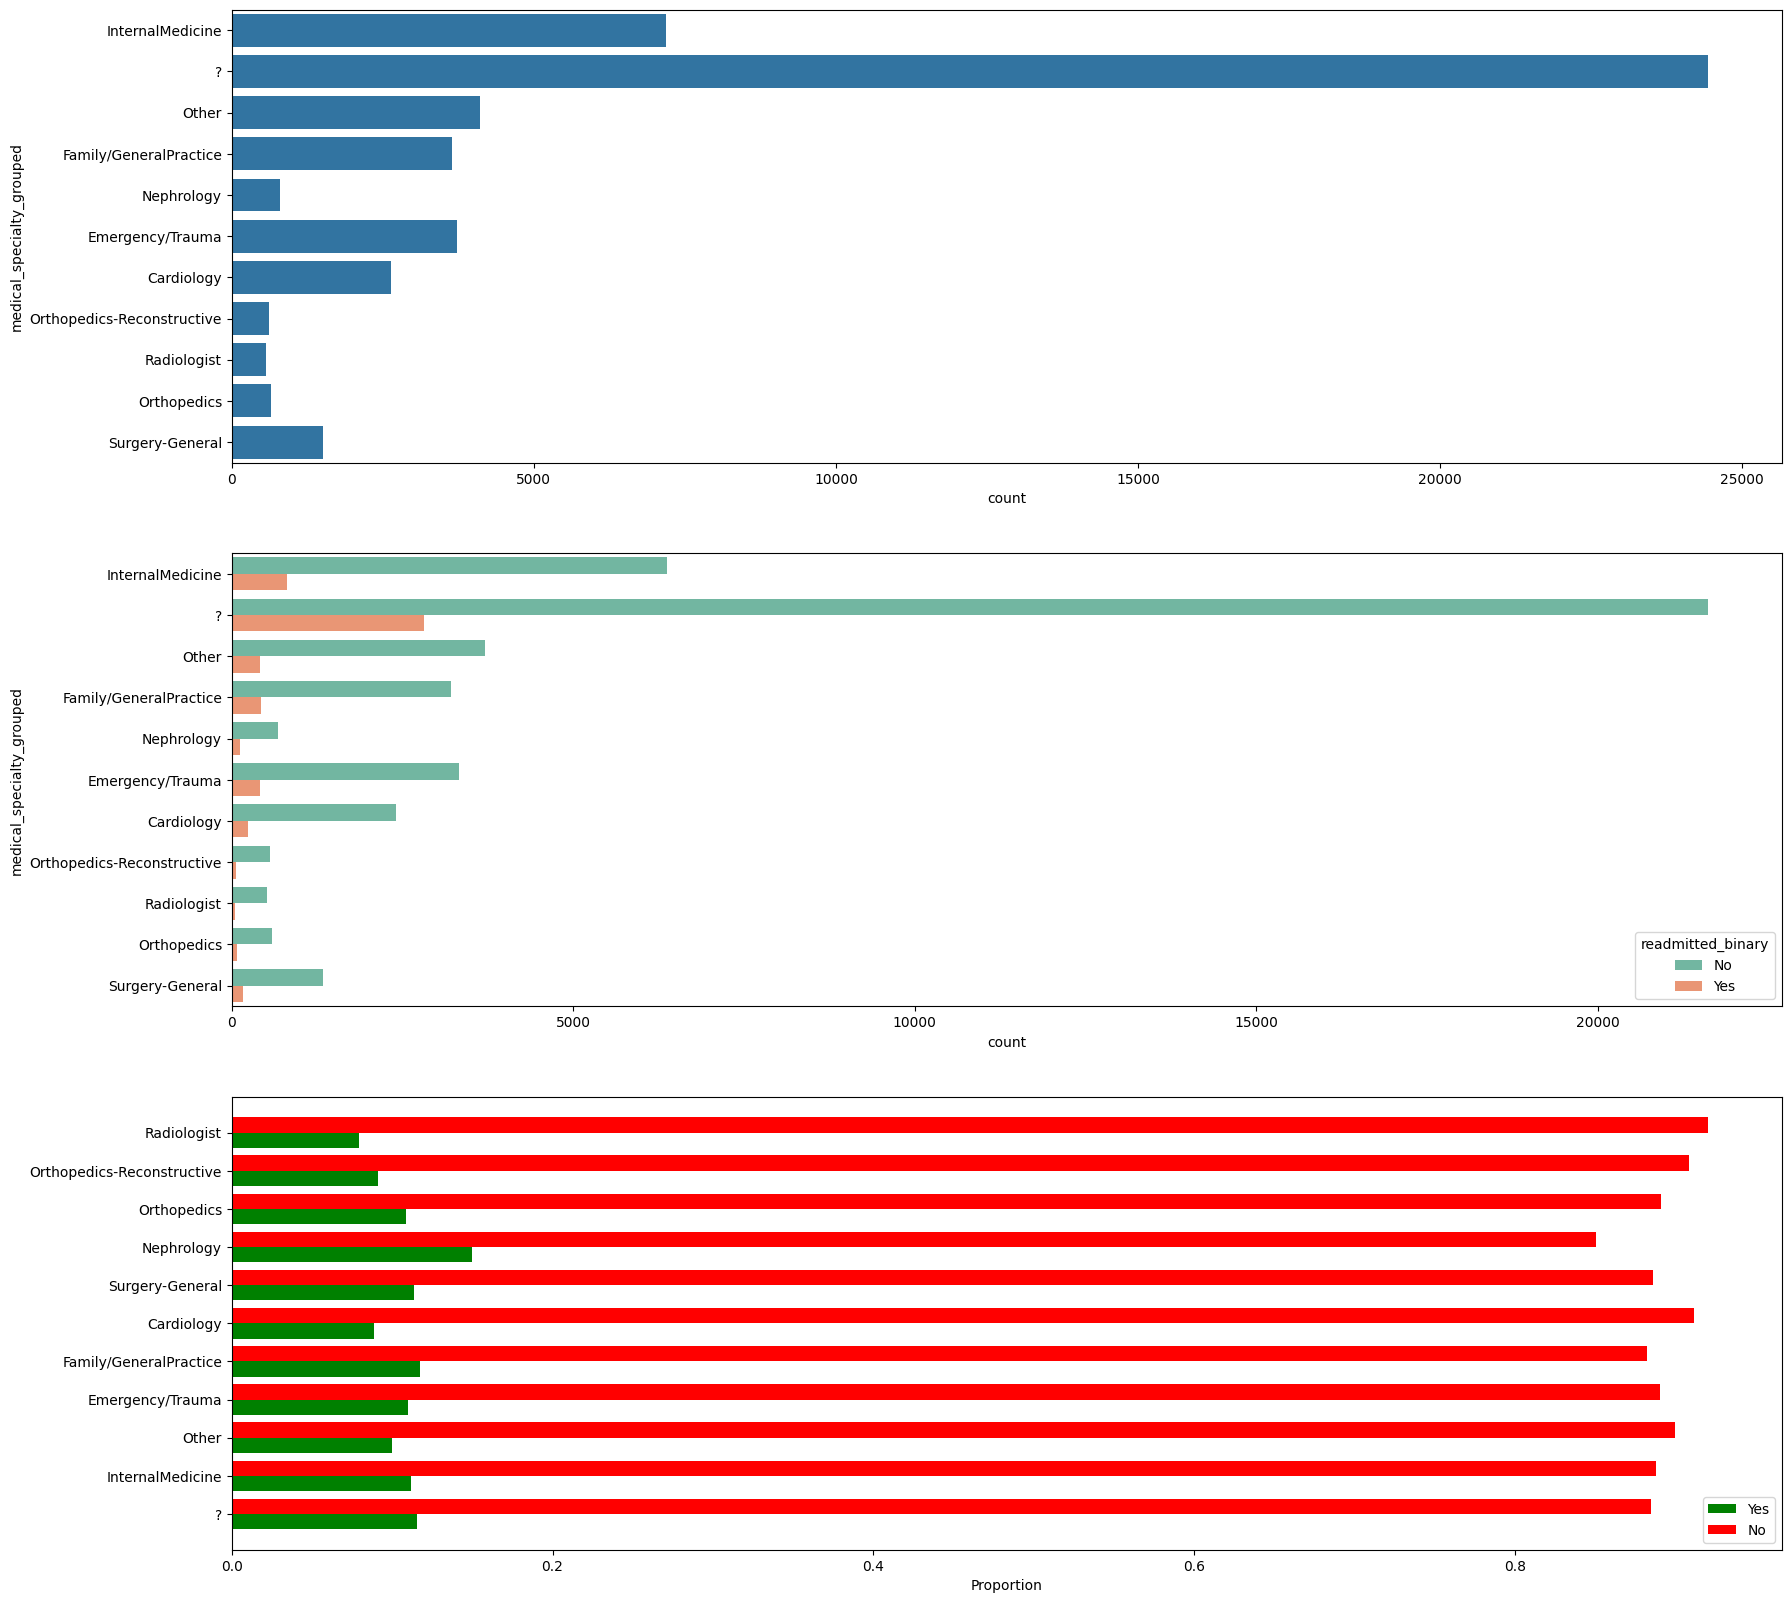

In [57]:
plt.figure(figsize = (20, 20))

plt.subplot(3, 1, 1)
sns.countplot(data = train_df, y = 'medical_specialty_grouped')

plt.subplot(3, 1, 2)
sns.countplot(y = 'medical_specialty_grouped', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plot_proportions(train_df, 'medical_specialty_grouped', plt.subplot(3, 1, 3))

plt.show()

__`OBS 20`__ **Discharge disposition**

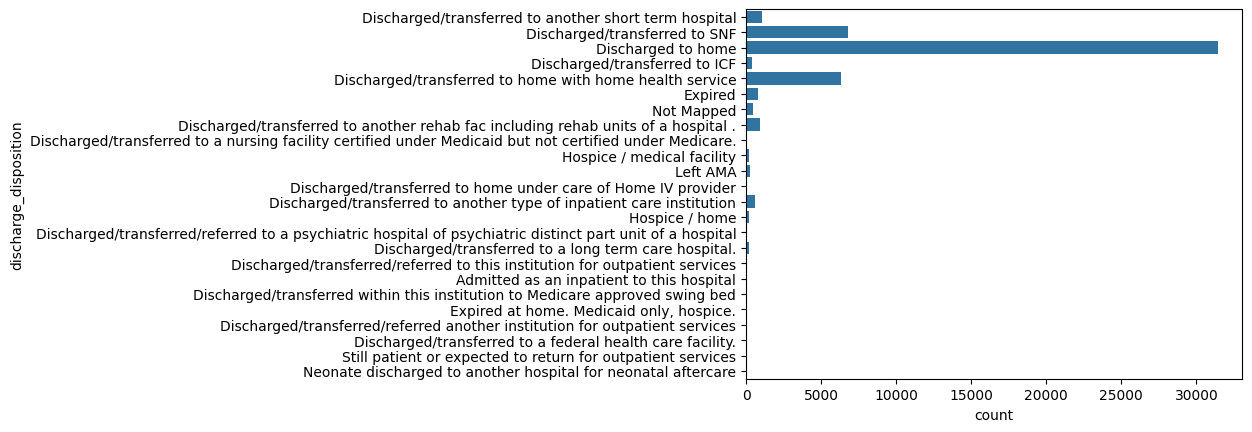

In [58]:
sns.countplot(data = train_df, y = 'discharge_disposition')
plt.show()

__`OBS 21`__ **Let's try to group some unusual categories into a "Other" category**

In [59]:
threshold = 500  # Adjust the threshold based on your preference
rare_specialties = train_df['discharge_disposition'].value_counts()[train_df['discharge_disposition'].value_counts() < threshold].index
train_df['discharge_disposition_grouped'] = train_df['discharge_disposition'].apply(lambda x: x if x not in rare_specialties else 'Other')

In [60]:
train_df['discharge_disposition_grouped'].unique()

array(['Discharged/transferred to another short term hospital',
       'Discharged/transferred to SNF', 'Discharged to home', 'Other',
       'Discharged/transferred to home with home health service',
       'Expired',
       'Discharged/transferred to another rehab fac including rehab units of a hospital .',
       'Discharged/transferred to another type of inpatient care institution'],
      dtype=object)

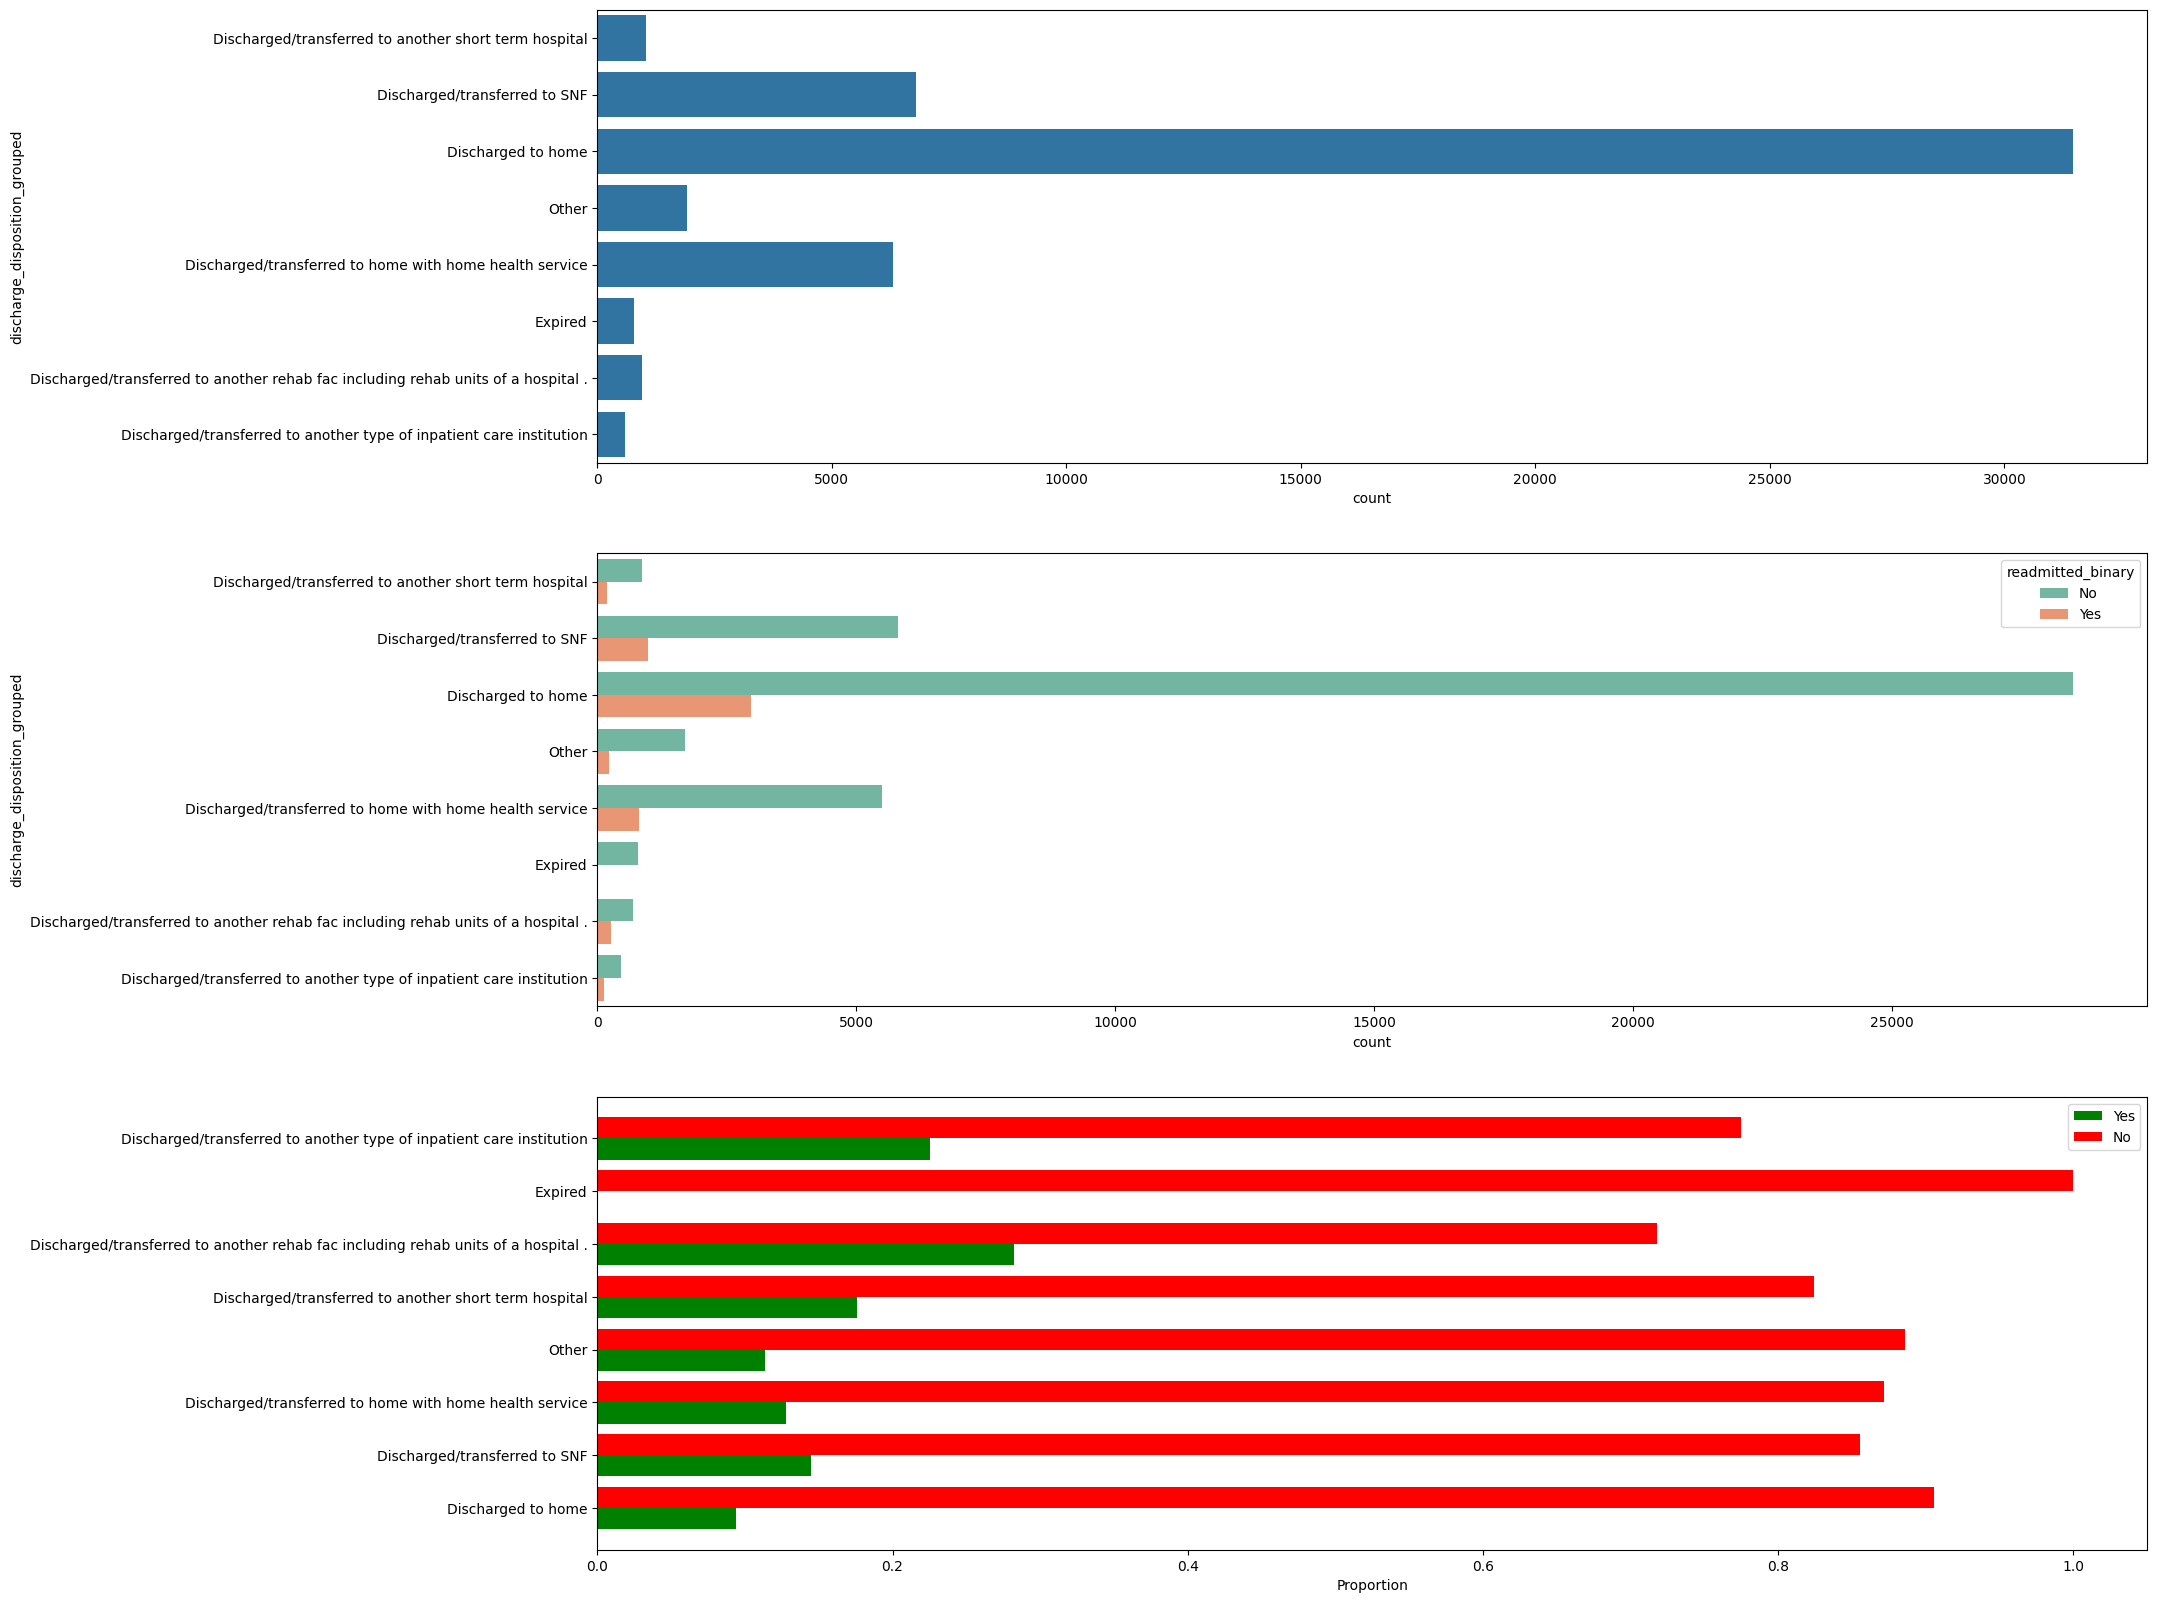

In [61]:
plt.figure(figsize = (20, 20))

plt.subplot(3, 1, 1)
sns.countplot(data = train_df, y = 'discharge_disposition_grouped')

plt.subplot(3, 1, 2)
sns.countplot(y = 'discharge_disposition_grouped', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plot_proportions(train_df, 'discharge_disposition_grouped', plt.subplot(3, 1, 3))

plt.show()

__`OBS 22`__ **admission_source**

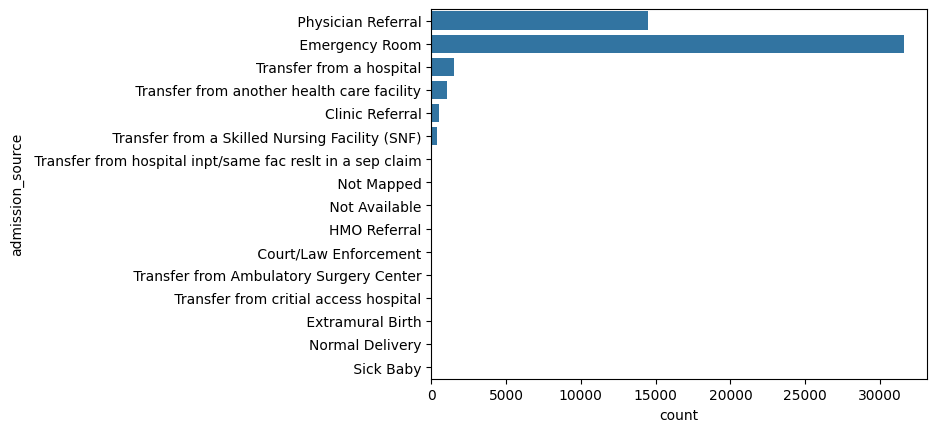

In [62]:
sns.countplot(data = train_df, y = 'admission_source')
plt.show()

__`OBS 23`__ **Let's try to group some unusual categories into a "Other" category**

In [63]:
threshold = 500  # Adjust the threshold based on your preference
rare_specialties = train_df['admission_source'].value_counts()[train_df['admission_source'].value_counts() < threshold].index
train_df['admission_source_grouped'] = train_df['admission_source'].apply(lambda x: x if x not in rare_specialties else 'Other')

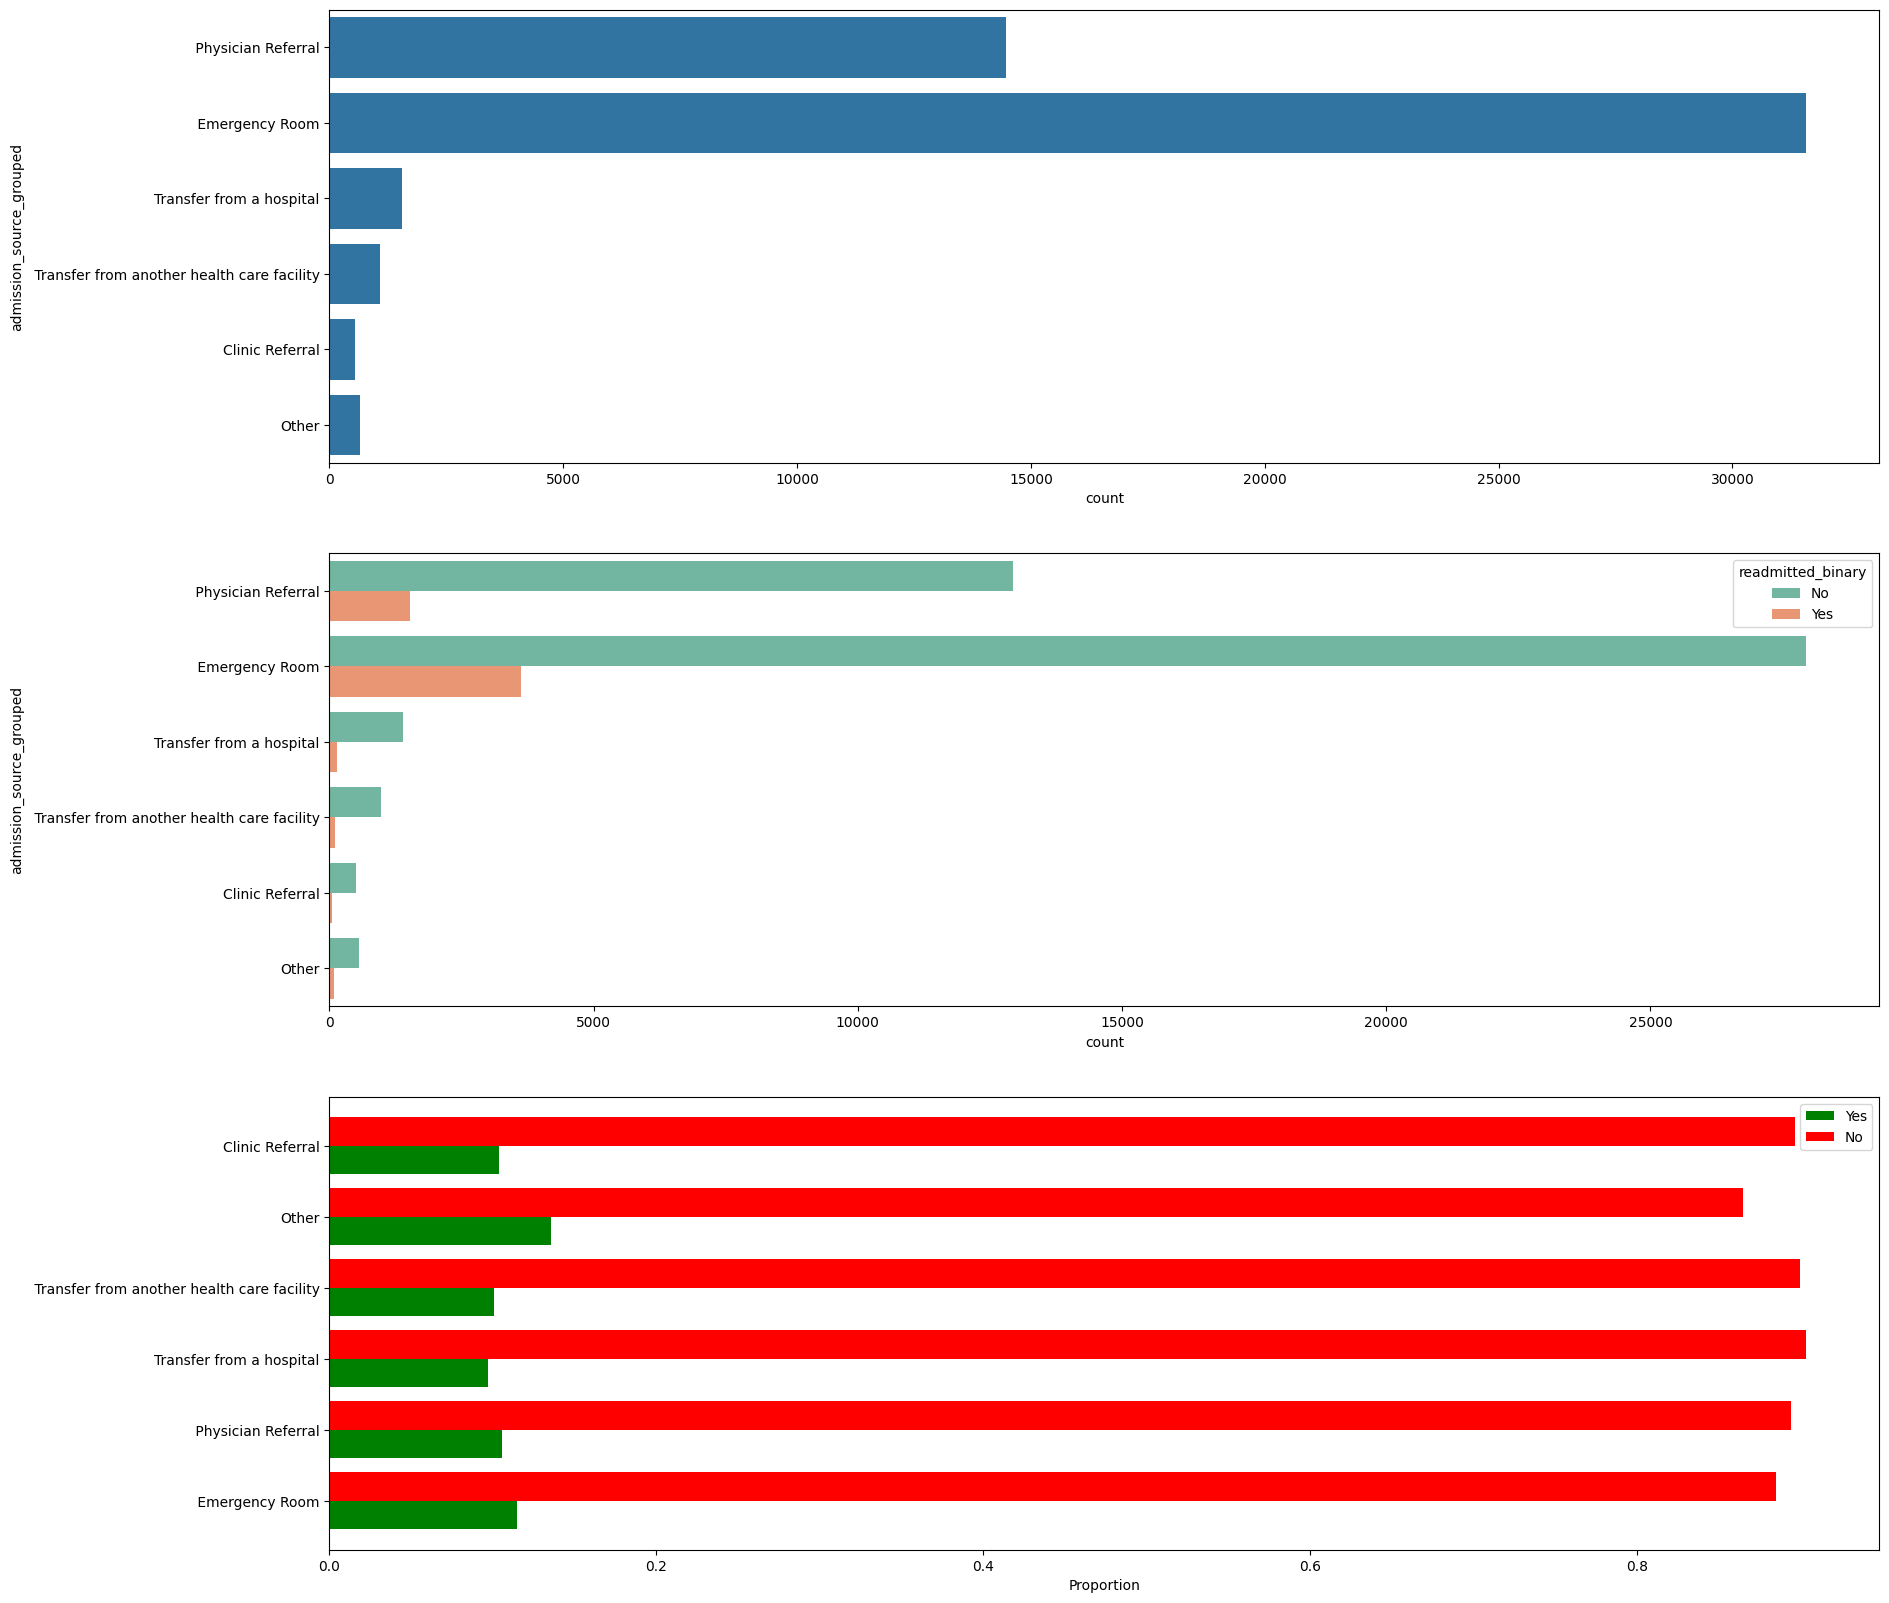

In [64]:
plt.figure(figsize = (20, 20))

plt.subplot(3, 1, 1)
sns.countplot(data = train_df, y = 'admission_source_grouped')

plt.subplot(3, 1, 2)
sns.countplot(y = 'admission_source_grouped', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plot_proportions(train_df, 'admission_source_grouped', plt.subplot(3, 1, 3))

plt.show()

In [65]:
train_df['admission_source_grouped'].unique()

array([' Physician Referral', ' Emergency Room',
       'Transfer from a hospital',
       ' Transfer from another health care facility', 'Clinic Referral',
       'Other'], dtype=object)

__`OBS 21`__ Diagnosis columns
- Firstly we will group the codes based on their meaning

In [66]:
train_df['primary_diagnosis_c'] = train_df['primary_diagnosis'].map(map_icd9_to_chapter)
train_df['secondary_diagnosis_c'] = train_df['secondary_diagnosis'].map(map_icd9_to_chapter)
train_df['additional_diagnosis_c'] = train_df['additional_diagnosis'].map(map_icd9_to_chapter)

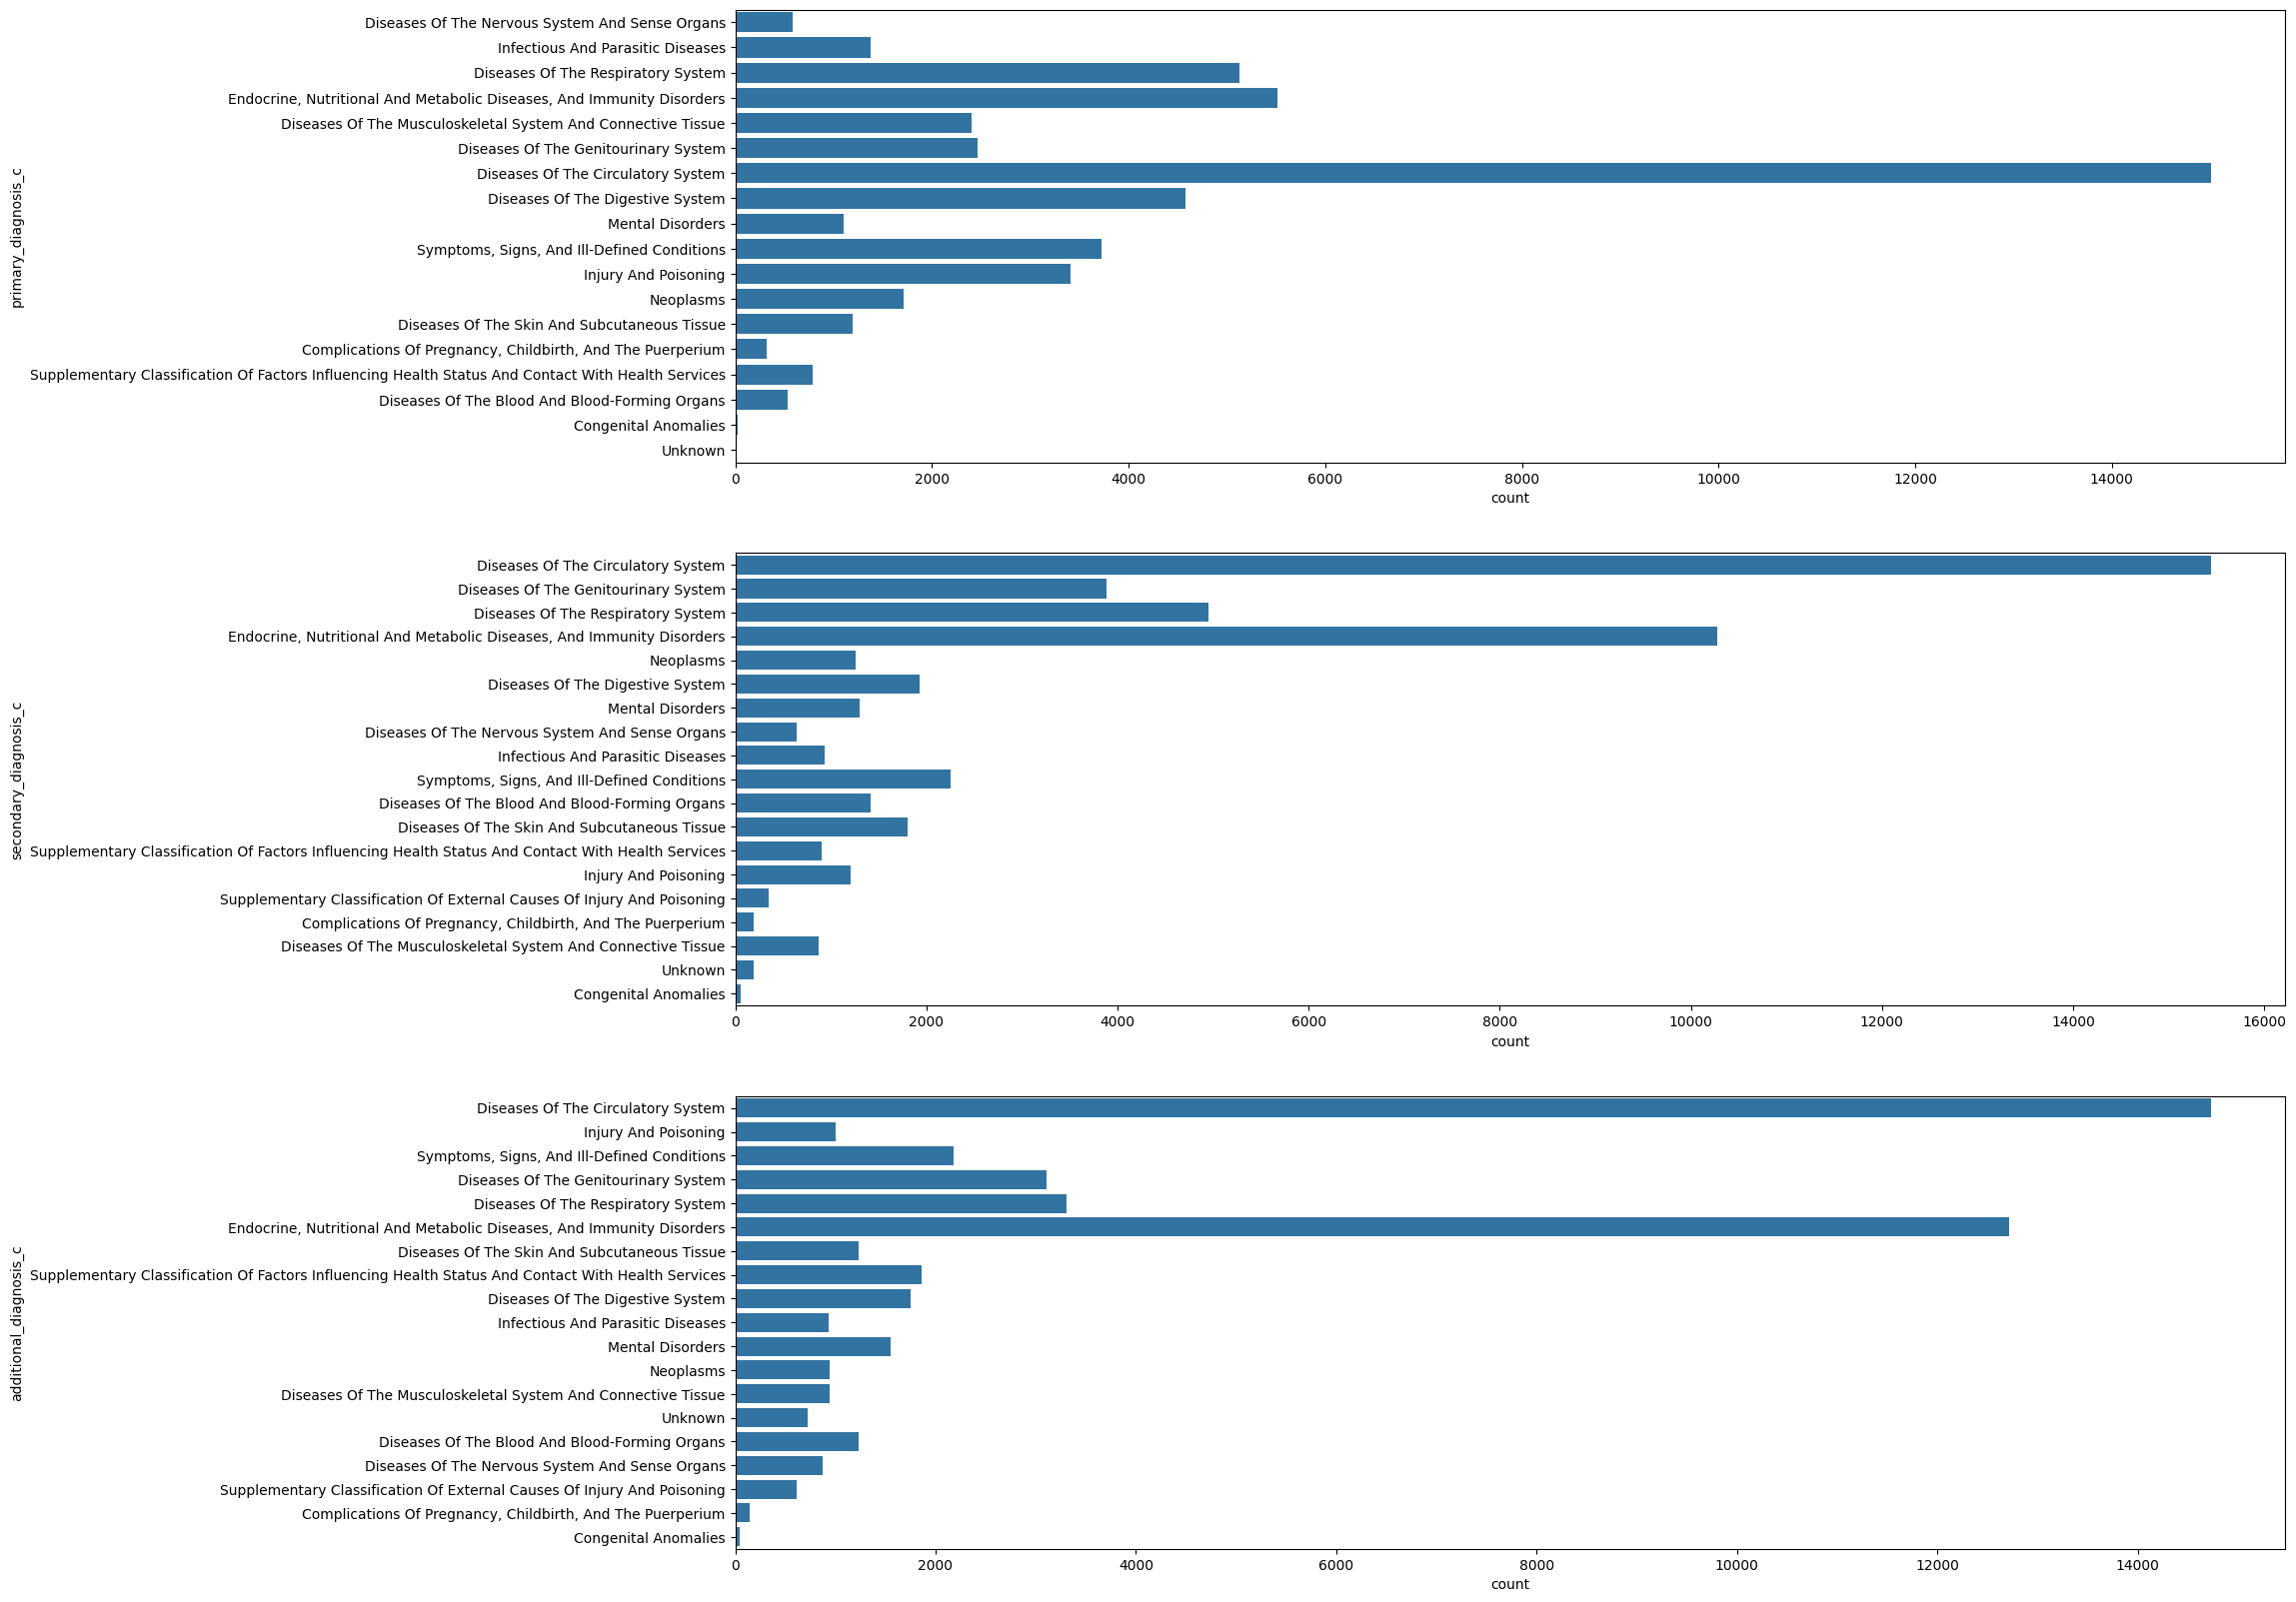

In [67]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
sns.countplot(data = train_df, y = 'primary_diagnosis_c')

plt.subplot(3, 1, 2)
sns.countplot(data = train_df, y = 'secondary_diagnosis_c')

plt.subplot(3, 1, 3)
sns.countplot(data = train_df, y = 'additional_diagnosis_c')

plt.show()

__`OBS 20`__ Let's try to group some unusual categories into a "Other" category

In [68]:
threshold = 1000  # Adjust the threshold based on your preference
rare_specialties = train_df['primary_diagnosis_c'].value_counts()[train_df['primary_diagnosis_c'].value_counts() < threshold].index
train_df['primary_diagnosis_c_grouped'] = train_df['primary_diagnosis_c'].apply(lambda x: x if x not in rare_specialties else 'Other')

rare_specialties = train_df['secondary_diagnosis_c'].value_counts()[train_df['secondary_diagnosis_c'].value_counts() < threshold].index
train_df['secondary_diagnosis_c_grouped'] = train_df['secondary_diagnosis_c'].apply(lambda x: x if x not in rare_specialties else 'Other')

rare_specialties = train_df['additional_diagnosis_c'].value_counts()[train_df['additional_diagnosis_c'].value_counts() < threshold].index
train_df['additional_diagnosis_c_grouped'] = train_df['additional_diagnosis_c'].apply(lambda x: x if x not in rare_specialties else 'Other')

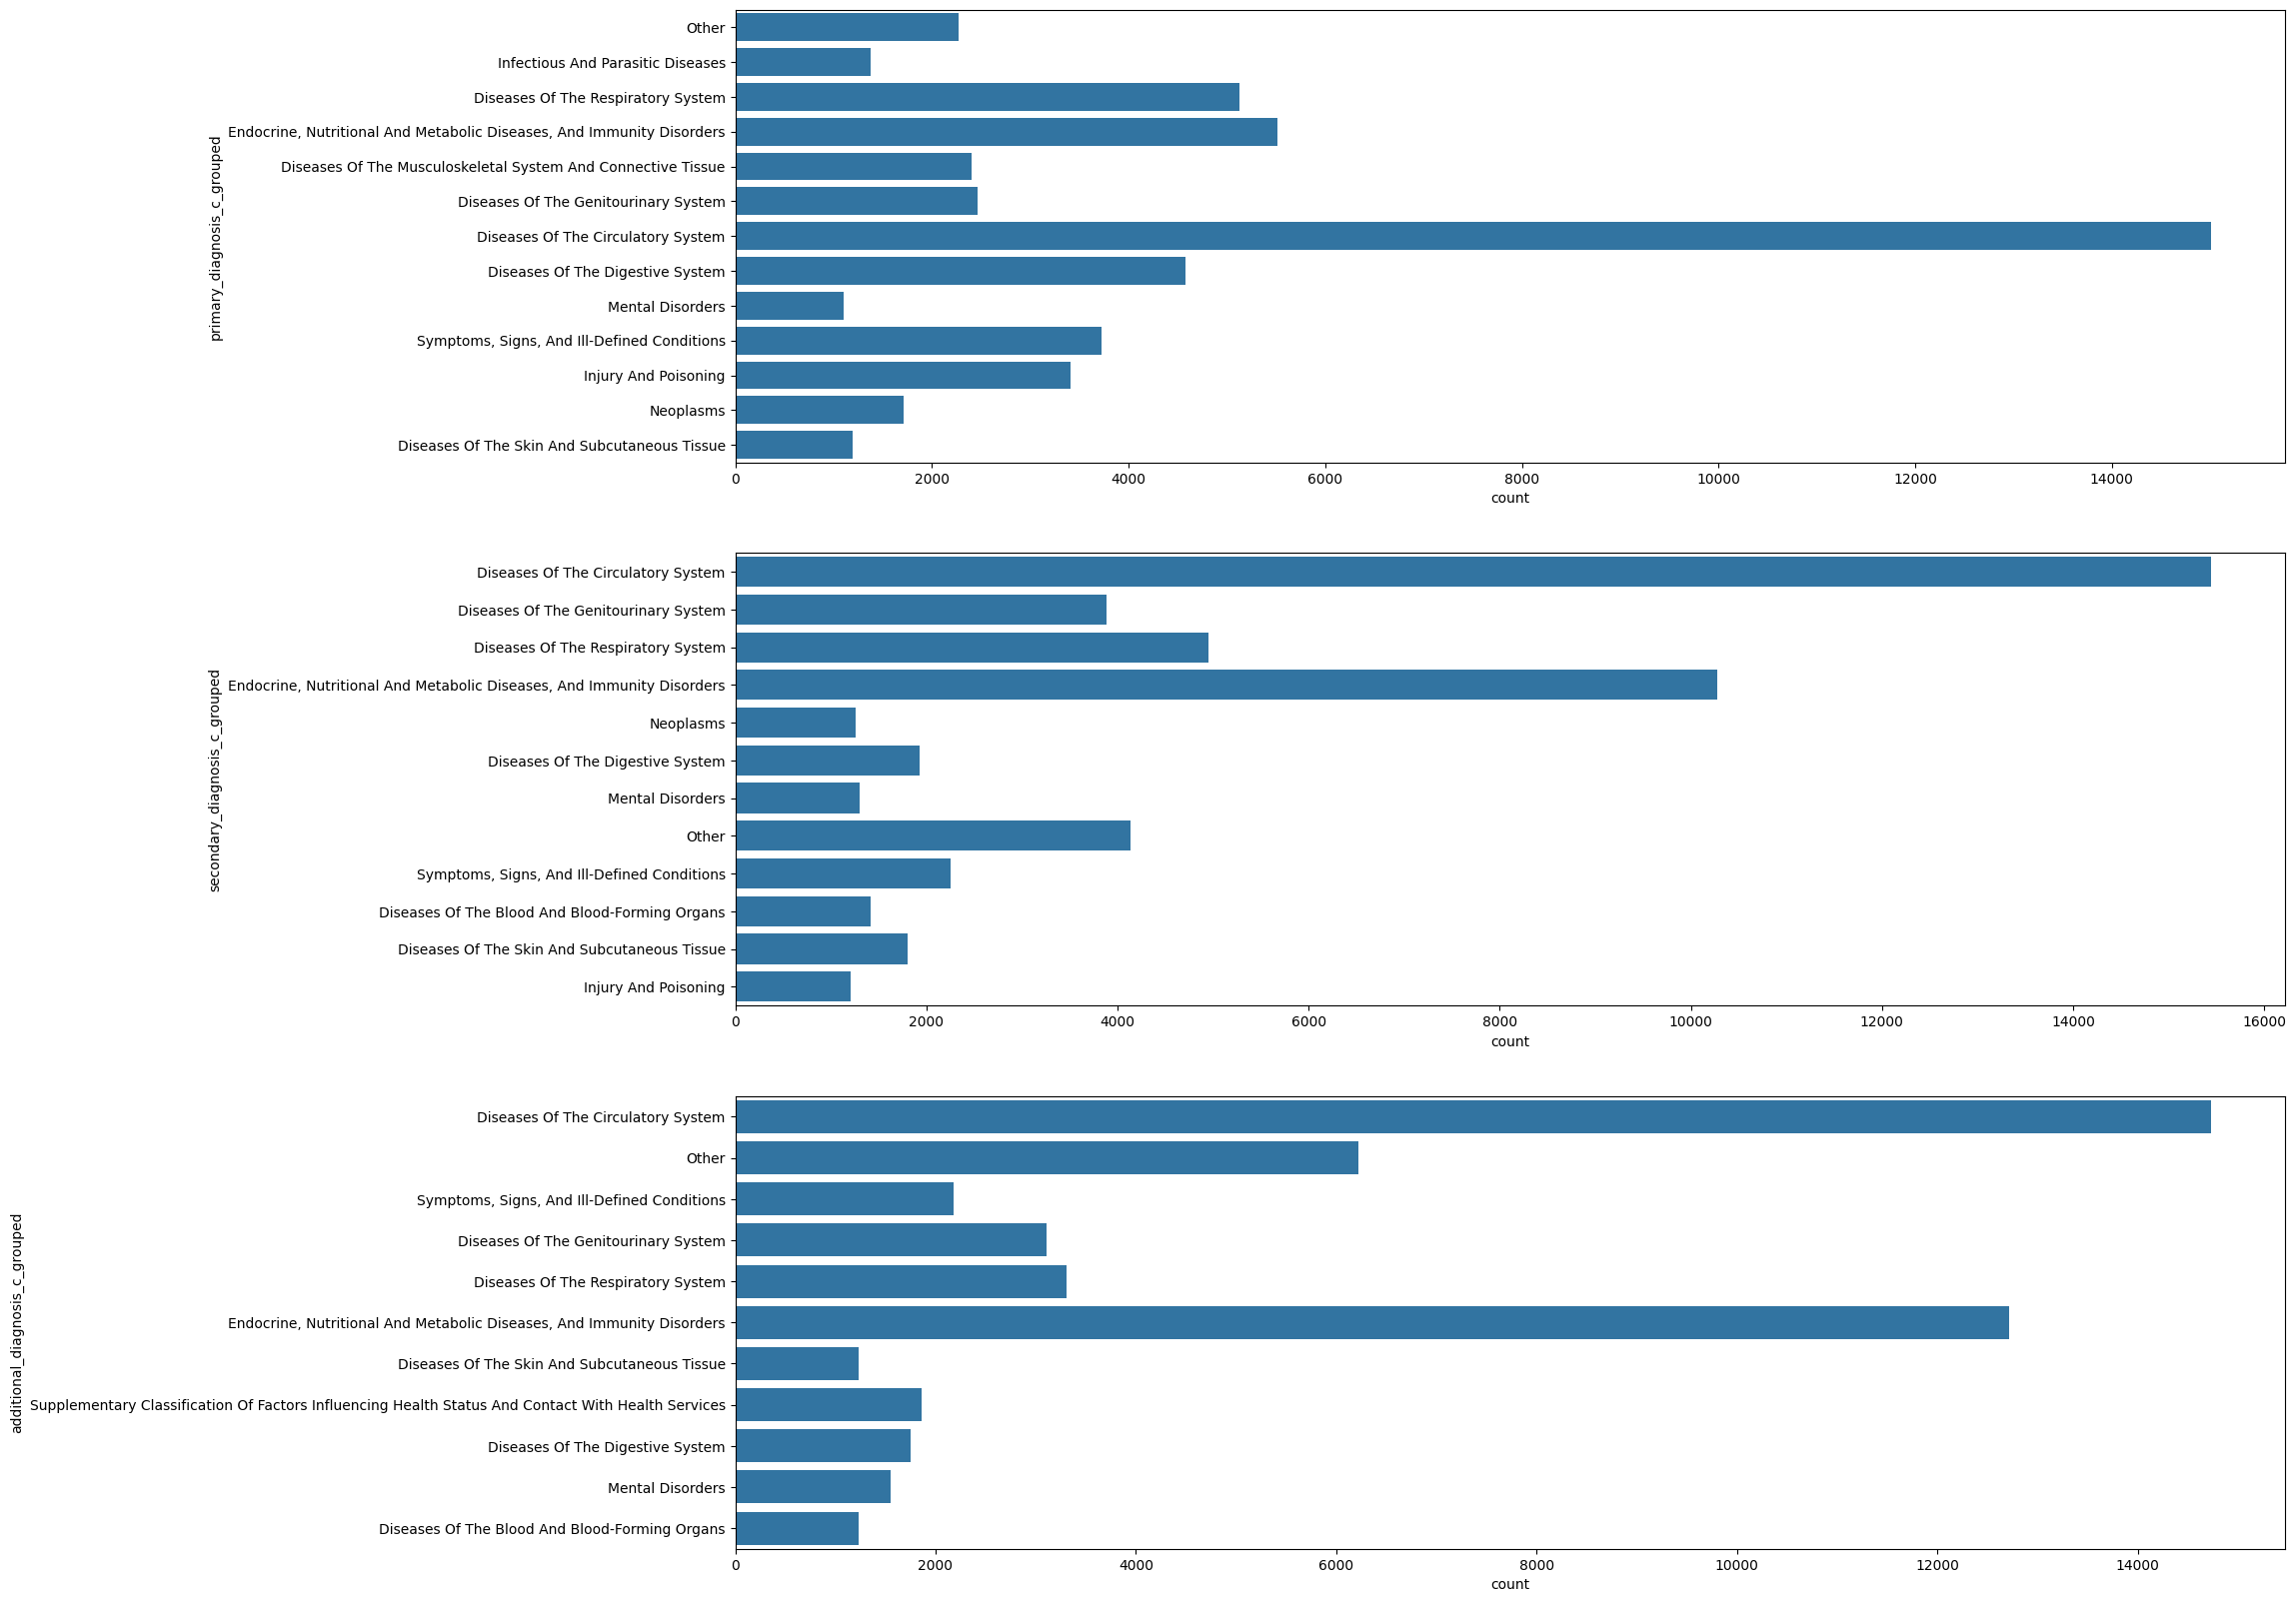

In [69]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
sns.countplot(data = train_df, y = 'primary_diagnosis_c_grouped')

plt.subplot(3, 1, 2)
sns.countplot(data = train_df, y = 'secondary_diagnosis_c_grouped')

plt.subplot(3, 1, 3)
sns.countplot(data = train_df, y = 'additional_diagnosis_c_grouped')

plt.show()

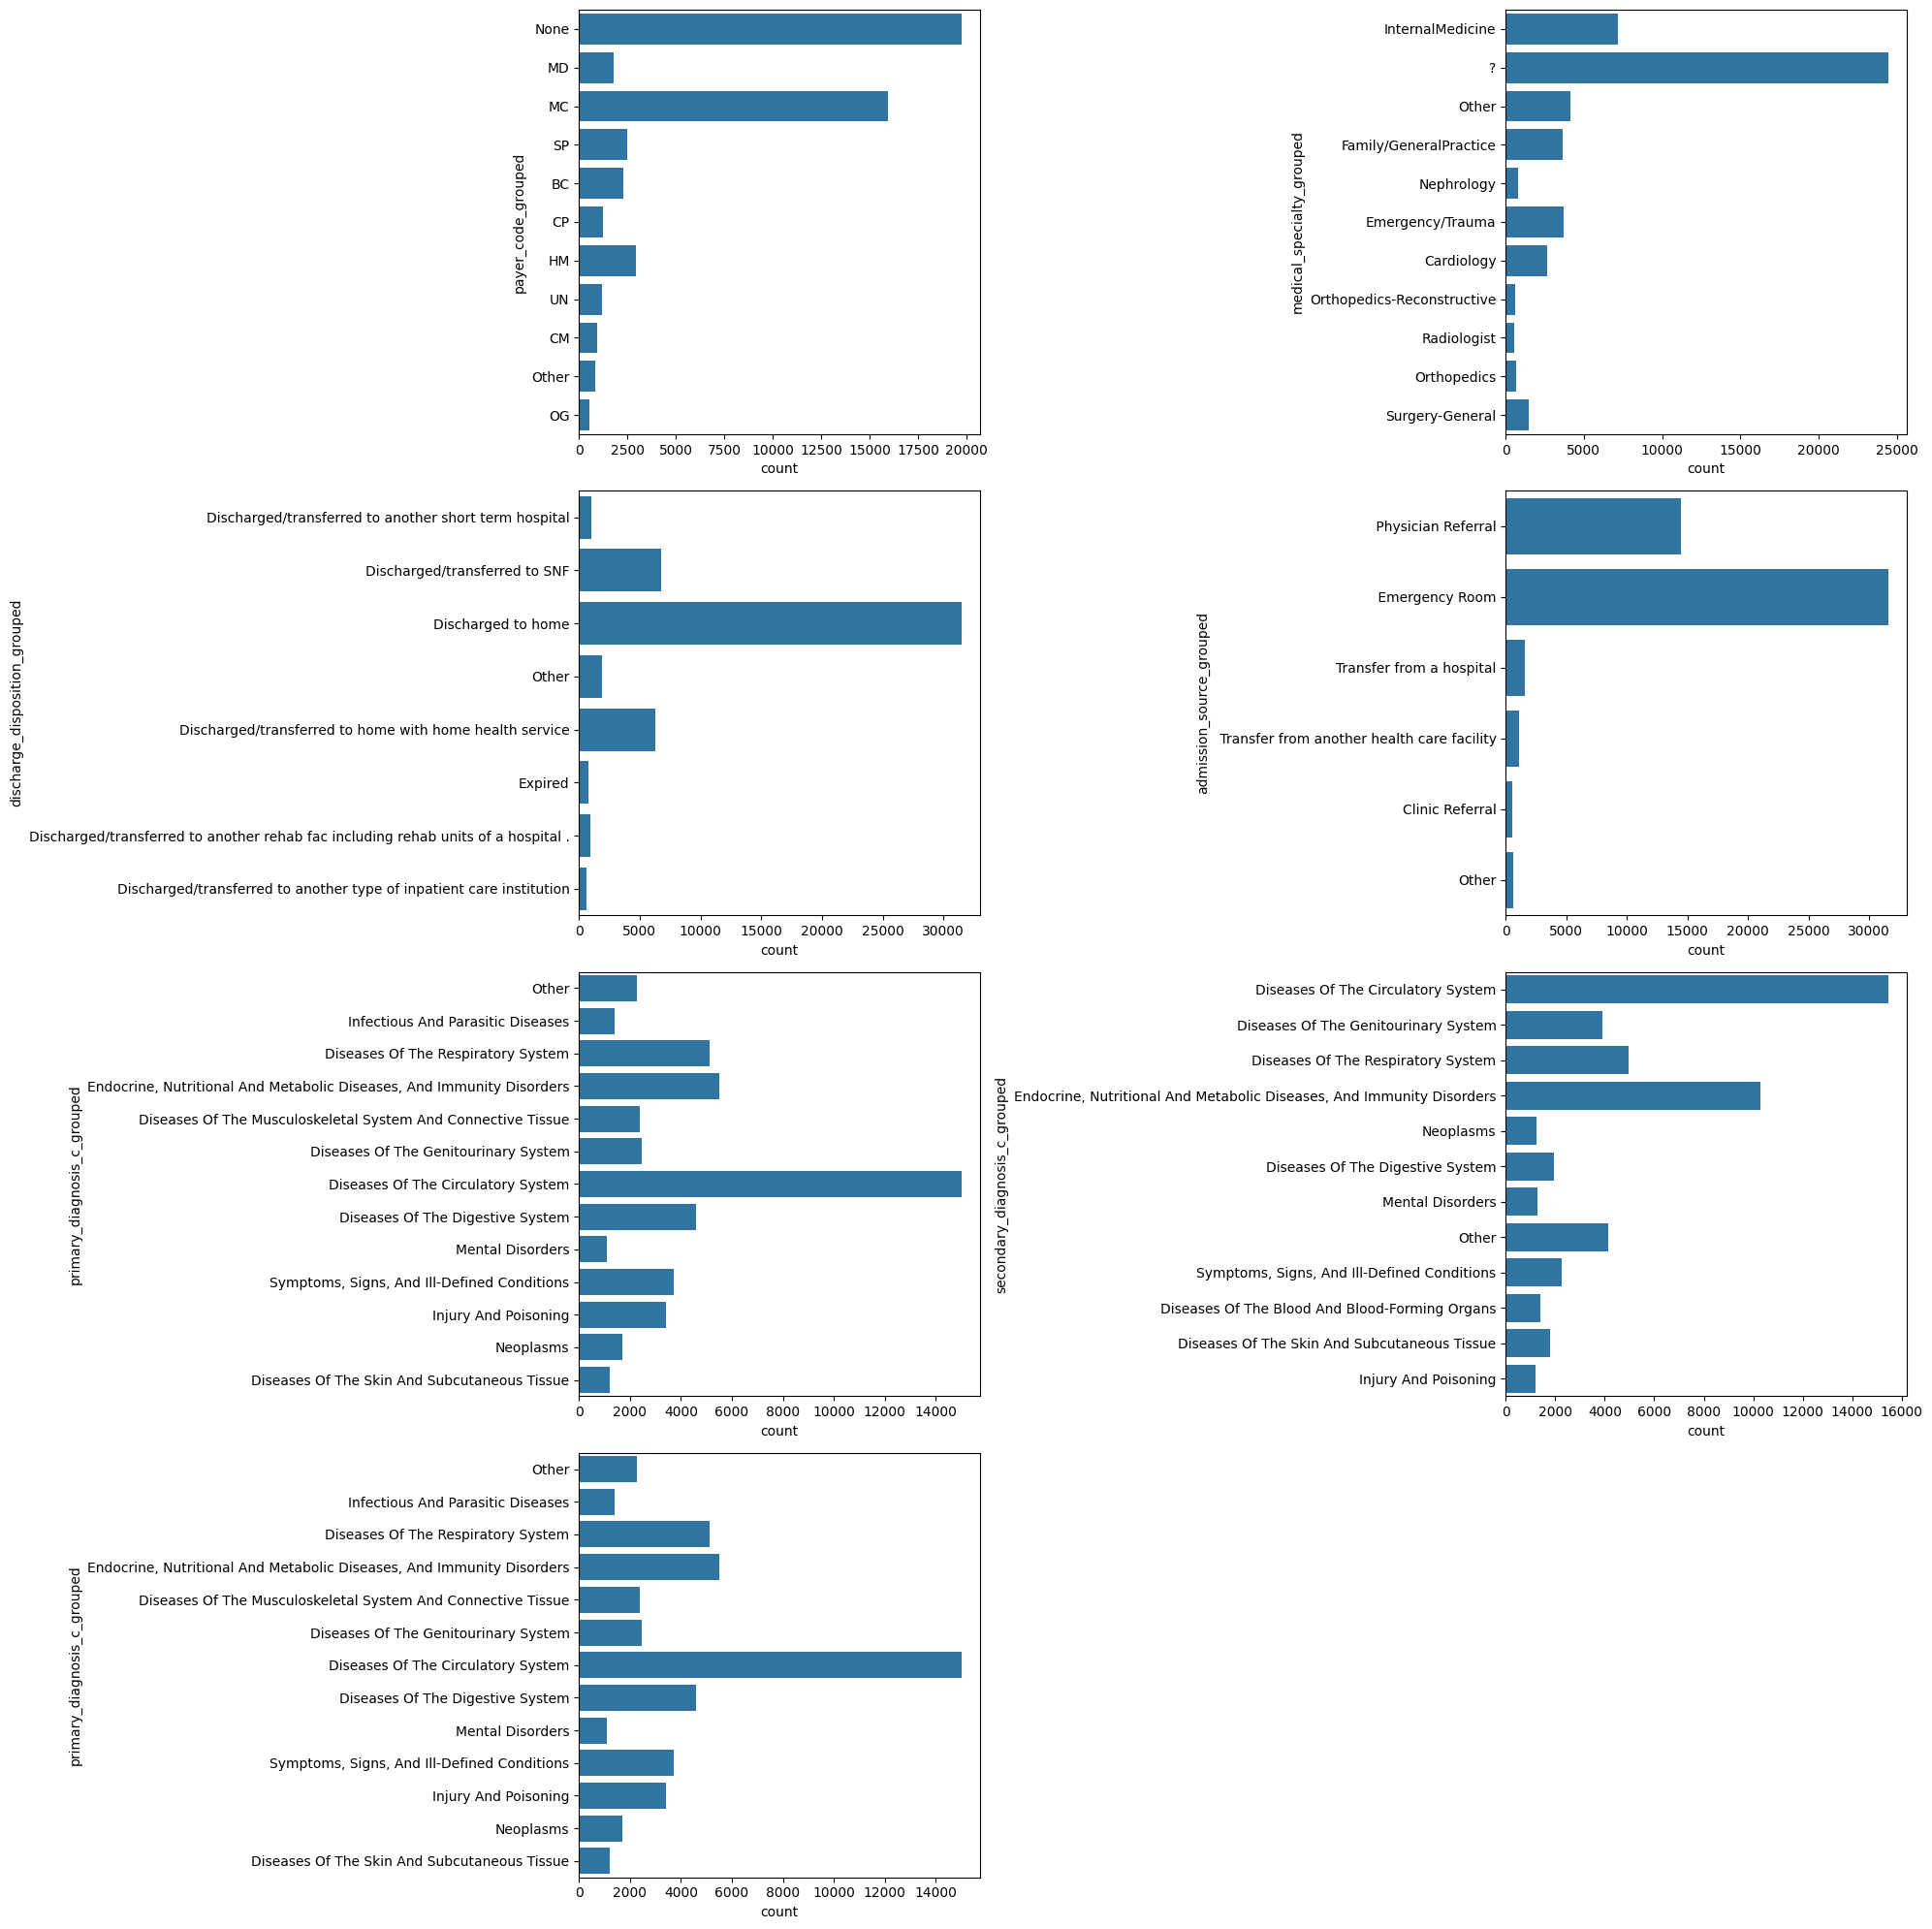

In [70]:
plt.figure(figsize=(20, 20))

plt.subplot(4, 2, 1)
sns.countplot(data = train_df, y = 'payer_code_grouped')

plt.subplot(4, 2, 2)
sns.countplot(data = train_df, y = 'medical_specialty_grouped')

plt.subplot(4, 2, 3)
sns.countplot(data = train_df, y = 'discharge_disposition_grouped')

plt.subplot(4, 2, 4)
sns.countplot(data = train_df, y = 'admission_source_grouped')

plt.subplot(4, 2, 5)
sns.countplot(data = train_df, y = 'primary_diagnosis_c_grouped')

plt.subplot(4, 2, 6)
sns.countplot(data = train_df, y = 'secondary_diagnosis_c_grouped')

plt.subplot(4, 2, 7)
sns.countplot(data = train_df, y = 'primary_diagnosis_c_grouped')

plt.tight_layout()
#plt.savefig("high_car_barplots")
plt.show()

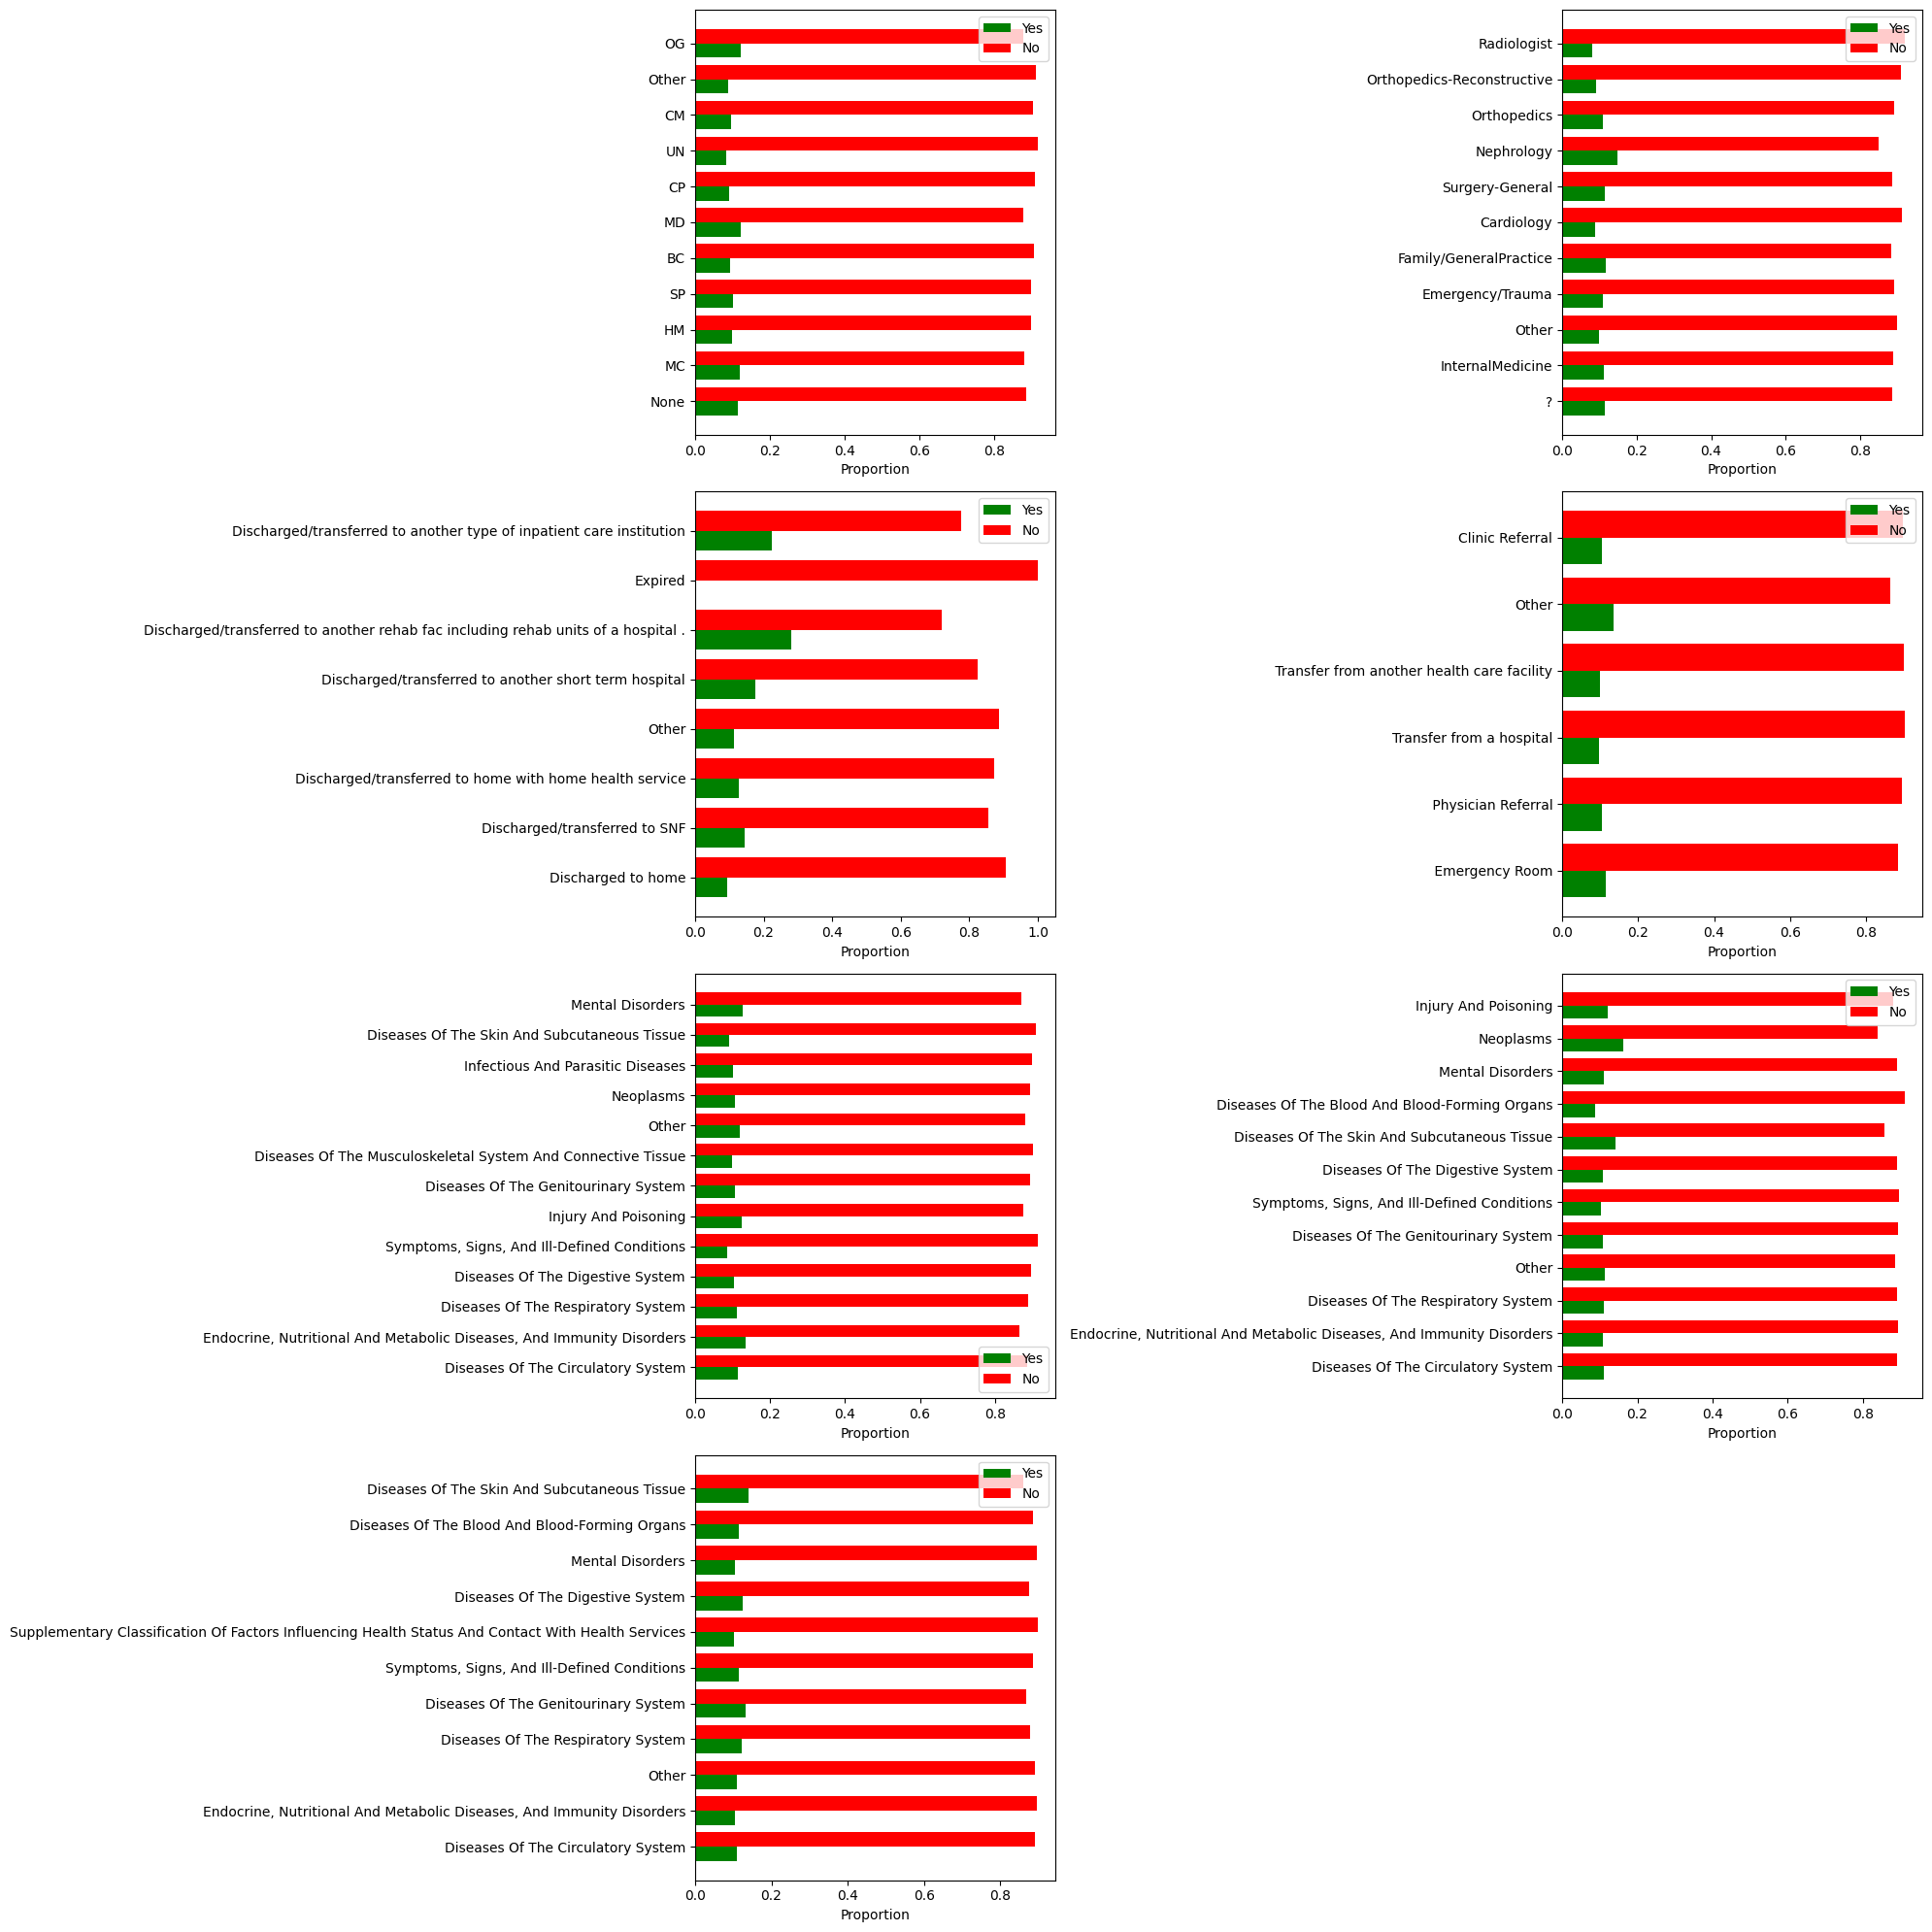

In [71]:
plt.figure(figsize=(20, 20))

plot_proportions(train_df, 'payer_code_grouped', plt.subplot(4, 2, 1))
plot_proportions(train_df, 'medical_specialty_grouped', plt.subplot(4, 2, 2))
plot_proportions(train_df, 'discharge_disposition_grouped', plt.subplot(4, 2, 3))
plot_proportions(train_df, 'admission_source_grouped', plt.subplot(4, 2, 4))
plot_proportions(train_df, 'primary_diagnosis_c_grouped', plt.subplot(4, 2, 5))
plot_proportions(train_df, 'secondary_diagnosis_c_grouped', plt.subplot(4, 2, 6))
plot_proportions(train_df, 'additional_diagnosis_c_grouped', plt.subplot(4, 2, 7))

plt.tight_layout()
#plt.savefig("high_car_propplots")
plt.show()

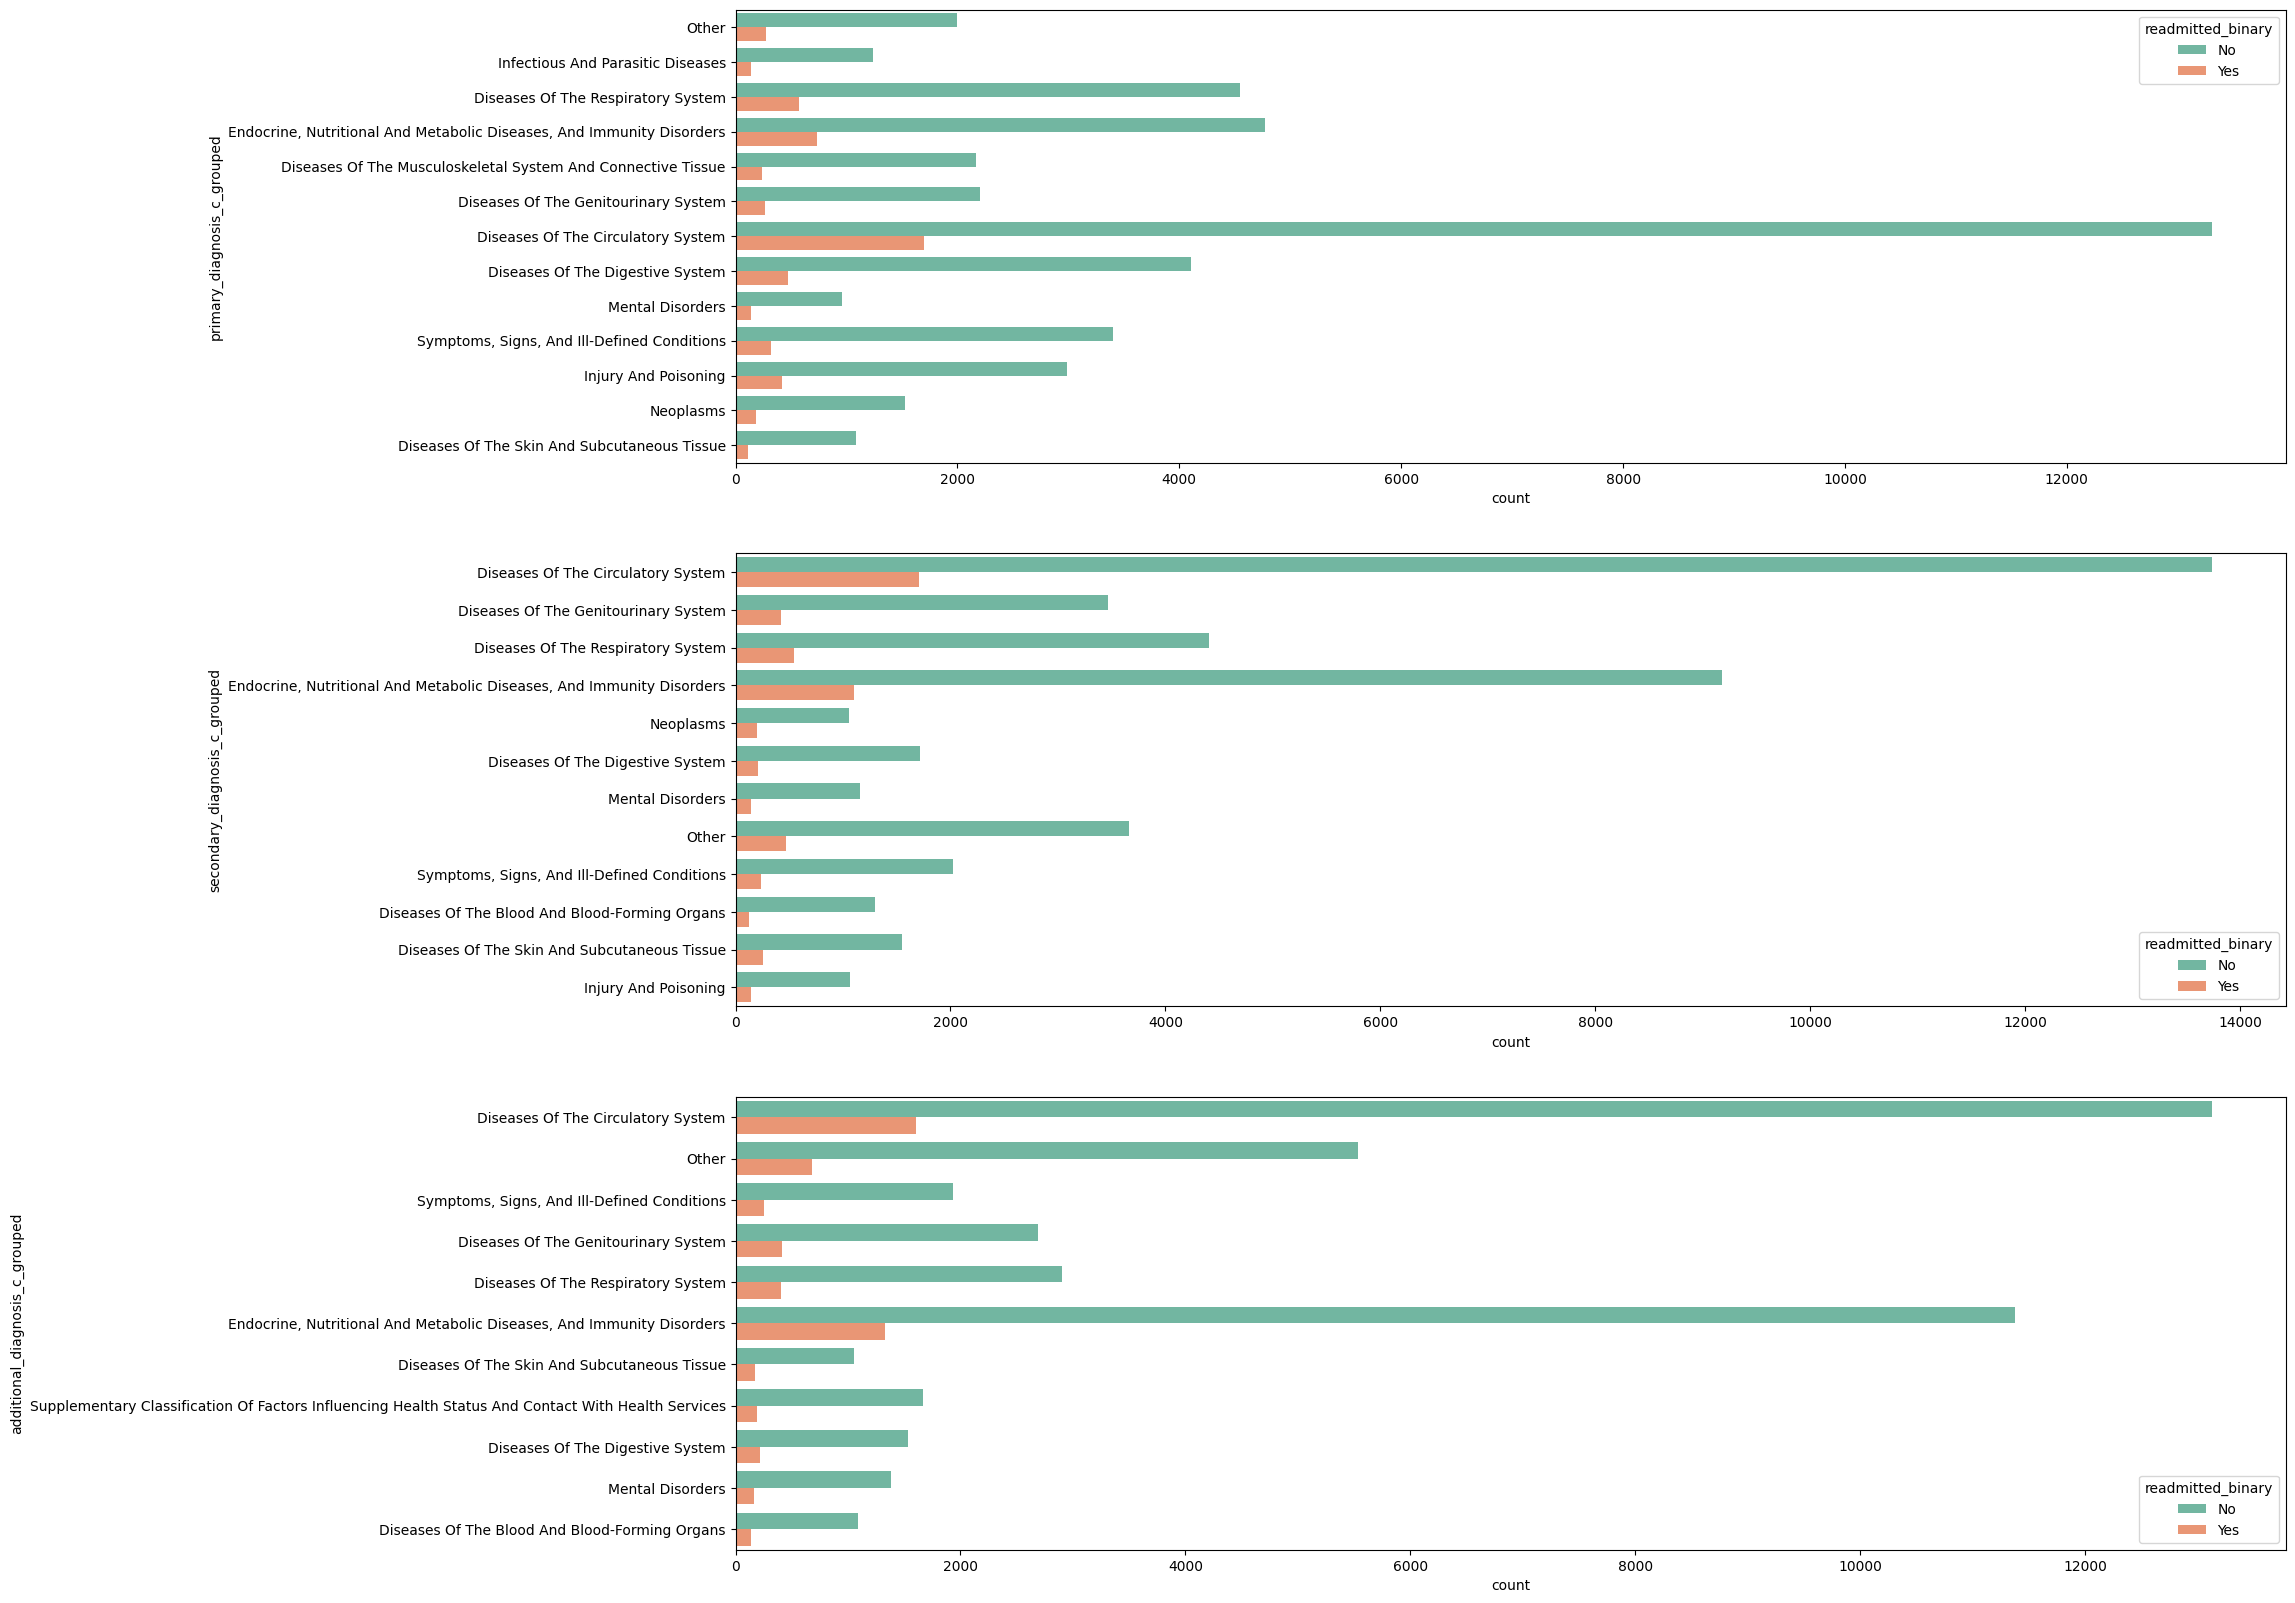

In [72]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
sns.countplot(y = 'primary_diagnosis_c_grouped', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(3, 1, 2)
sns.countplot(y = 'secondary_diagnosis_c_grouped', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.subplot(3, 1, 3)
sns.countplot(y = 'additional_diagnosis_c_grouped', hue = 'readmitted_binary', palette = 'Set2', data = train_df)

plt.show()

In [73]:
train_df["primary_diagnosis_c_grouped"].unique()

array(['Other', 'Infectious And Parasitic Diseases',
       'Diseases Of The Respiratory System',
       'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders',
       'Diseases Of The Musculoskeletal System And Connective Tissue',
       'Diseases Of The Genitourinary System',
       'Diseases Of The Circulatory System',
       'Diseases Of The Digestive System', 'Mental Disorders',
       'Symptoms, Signs, And Ill-Defined Conditions',
       'Injury And Poisoning', 'Neoplasms',
       'Diseases Of The Skin And Subcutaneous Tissue'], dtype=object)

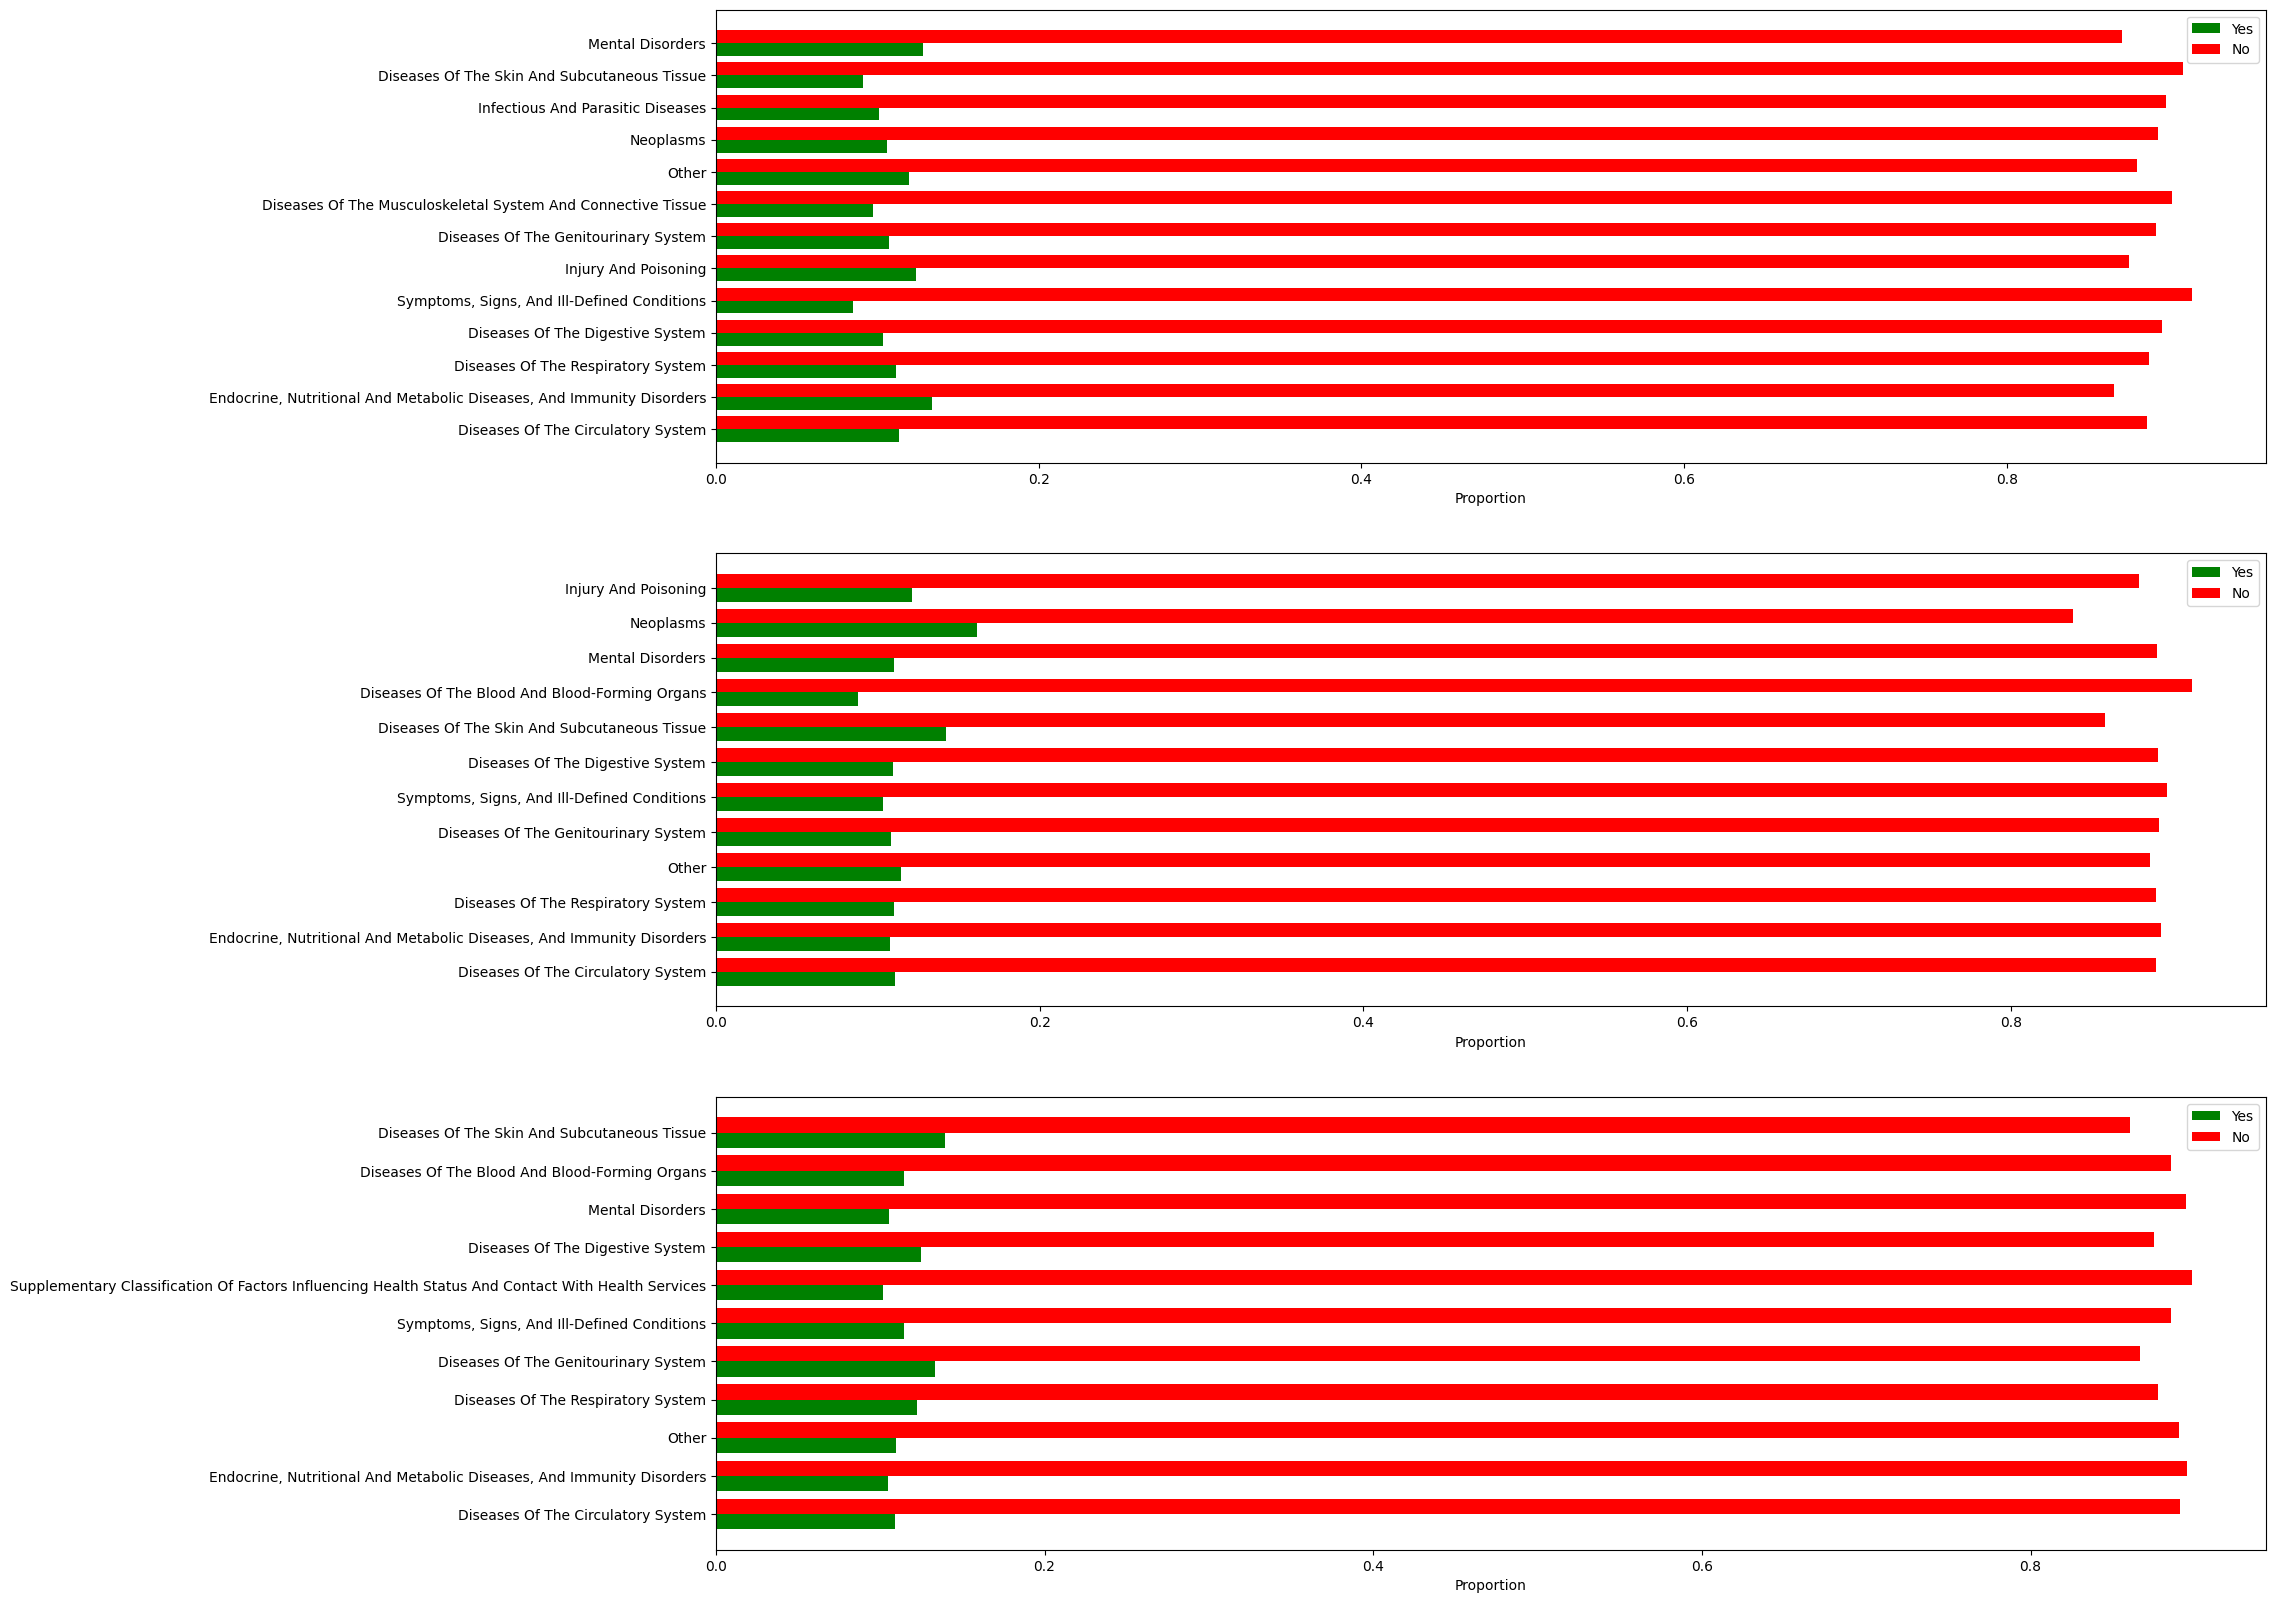

In [74]:
plt.figure(figsize = (20, 20))

plot_proportions(train_df, 'primary_diagnosis_c_grouped', plt.subplot(3, 1, 1))

plot_proportions(train_df, 'secondary_diagnosis_c_grouped', plt.subplot(3, 1, 2))

plot_proportions(train_df, 'additional_diagnosis_c_grouped', plt.subplot(3, 1, 3))

plt.show()

__`OBS 21`__ Let's dive deeper in the patients diagnosed with diabetes

In [75]:
disease_mapping = {
    '249': 'Secondary diabetes mellitus',
    '249.0': 'Secondary diabetes mellitus without mention of complication',
    '249.1': 'Secondary diabetes mellitus with ketoacidosis',
    '249.2': 'Secondary diabetes mellitus with hyperosmolarity',
    '249.3': 'Secondary diabetes mellitus with other coma',
    '249.4': 'Secondary diabetes mellitus with renal manifestations',
    '249.5': 'Secondary diabetes mellitus with ophthalmic manifestations',
    '249.6': 'Secondary diabetes mellitus with neurological manifestations',
    '249.7': 'Secondary diabetes mellitus with peripheral circulatory disorders',
    '249.8': 'Secondary diabetes mellitus with other specified manifestations',
    '249.9': 'Secondary diabetes mellitus with unspecified complications',
    '250': 'Diabetes mellitus',
    '250.0': 'Diabetes mellitus without mention of complication',
    '250.1': 'Diabetes with ketoacidosis',
    '250.2': 'Diabetes with hyperosmolarity',
    '250.3': 'Diabetes with other coma',
    '250.4': 'Diabetes with renal manifestations',
    '250.5': 'Diabetes with ophthalmic manifestations',
    '250.6': 'Diabetes with neurological manifestations',
    '250.7': 'Diabetes with peripheral circulatory disorders',
    '250.8': 'Diabetes with other specified manifestations',
    '250.9': 'Diabetes with unspecified complication'
}

# Assuming 'disease_code' is the column containing the disease codes
train_df['primary_diagnosis_diabetes'] = train_df['primary_diagnosis'].map(disease_mapping).fillna('Others')
train_df['secondary_diagnosis_diabetes'] = train_df['secondary_diagnosis'].map(disease_mapping).fillna('Others')
train_df['additional_diagnosis_diabetes'] = train_df['additional_diagnosis'].map(disease_mapping).fillna('Others')


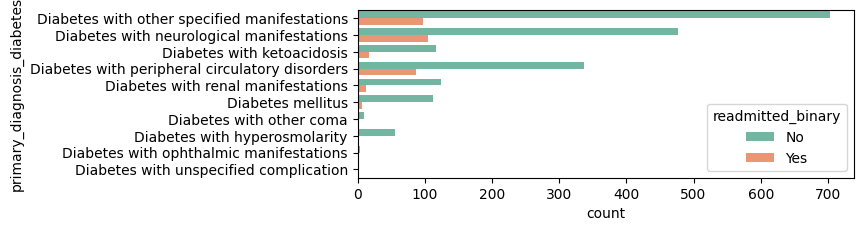

In [76]:
plt.subplot(2, 1, 2)
sns.countplot(y = 'primary_diagnosis_diabetes', hue = 'readmitted_binary', palette = 'Set2', data=train_df[train_df["primary_diagnosis_diabetes"] != "Others"])
plt.show()

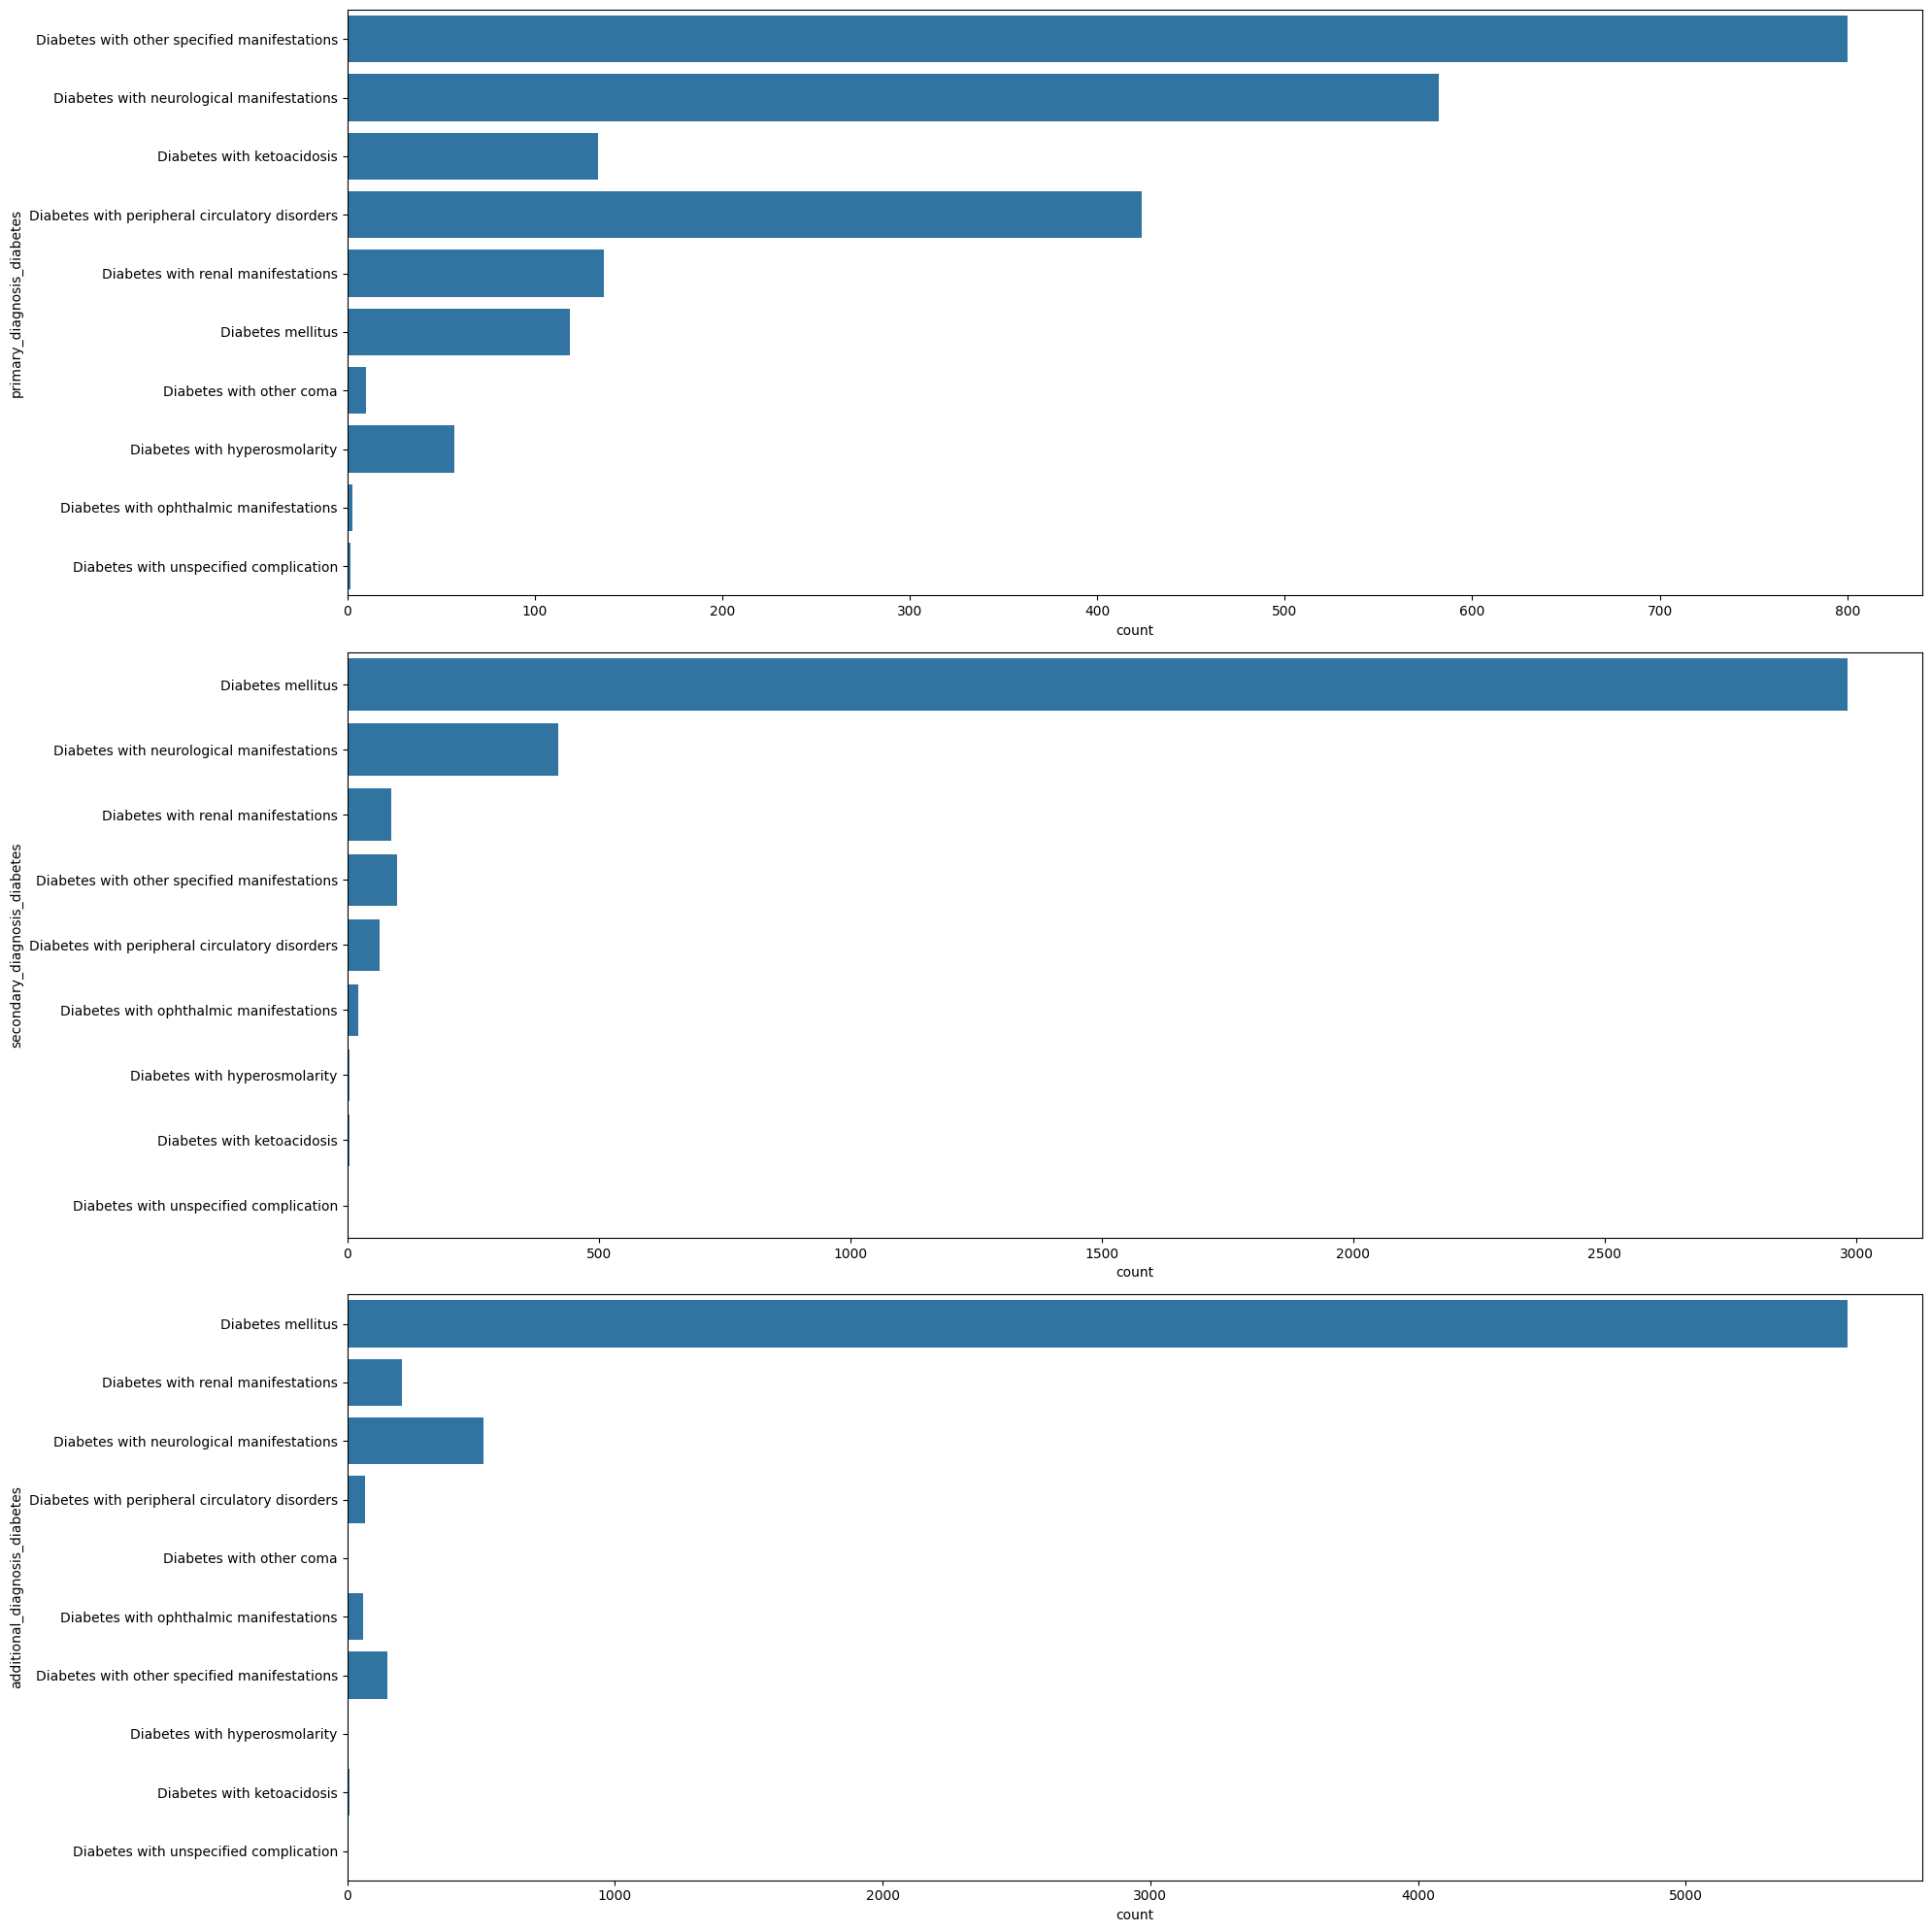

In [77]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
sns.countplot(data = train_df[train_df["primary_diagnosis_diabetes"] != "Others"], y = 'primary_diagnosis_diabetes')

plt.subplot(3, 1, 2)
sns.countplot(data = train_df[train_df["secondary_diagnosis_diabetes"] != "Others"], y = 'secondary_diagnosis_diabetes')

plt.subplot(3, 1, 3)
sns.countplot(data = train_df[train_df["additional_diagnosis_diabetes"] != "Others"], y = 'additional_diagnosis_diabetes')

plt.tight_layout()
plt.show()

In [78]:
group_df = train_df.groupby(['primary_diagnosis_diabetes'])["readmitted_binary"].value_counts().unstack()
group_df["proportion"] = group_df["Yes"] / (group_df["Yes"] + group_df["No"]) 
group_df

readmitted_binary                                    No     Yes  proportion
primary_diagnosis_diabetes                                                 
Diabetes mellitus                                 113.0     6.0    0.050420
Diabetes with hyperosmolarity                      55.0     2.0    0.035088
Diabetes with ketoacidosis                        117.0    17.0    0.126866
Diabetes with neurological manifestations         477.0   105.0    0.180412
Diabetes with ophthalmic manifestations             3.0     NaN         NaN
Diabetes with other coma                            9.0     1.0    0.100000
Diabetes with other specified manifestations      703.0    97.0    0.121250
Diabetes with peripheral circulatory disorders    337.0    87.0    0.205189
Diabetes with renal manifestations                124.0    13.0    0.094891
Diabetes with unspecified complication              2.0     NaN         NaN
Others                                          42360.0  5237.0    0.110028

In [79]:
train_df['has_diabetes_1'] = (train_df['primary_diagnosis_diabetes'] != 'Others').astype(int)
train_df['has_diabetes_2'] = (train_df['secondary_diagnosis_diabetes'] != 'Others').astype(int)
train_df['has_diabetes_3'] = (train_df['additional_diagnosis_diabetes'] != 'Others').astype(int)

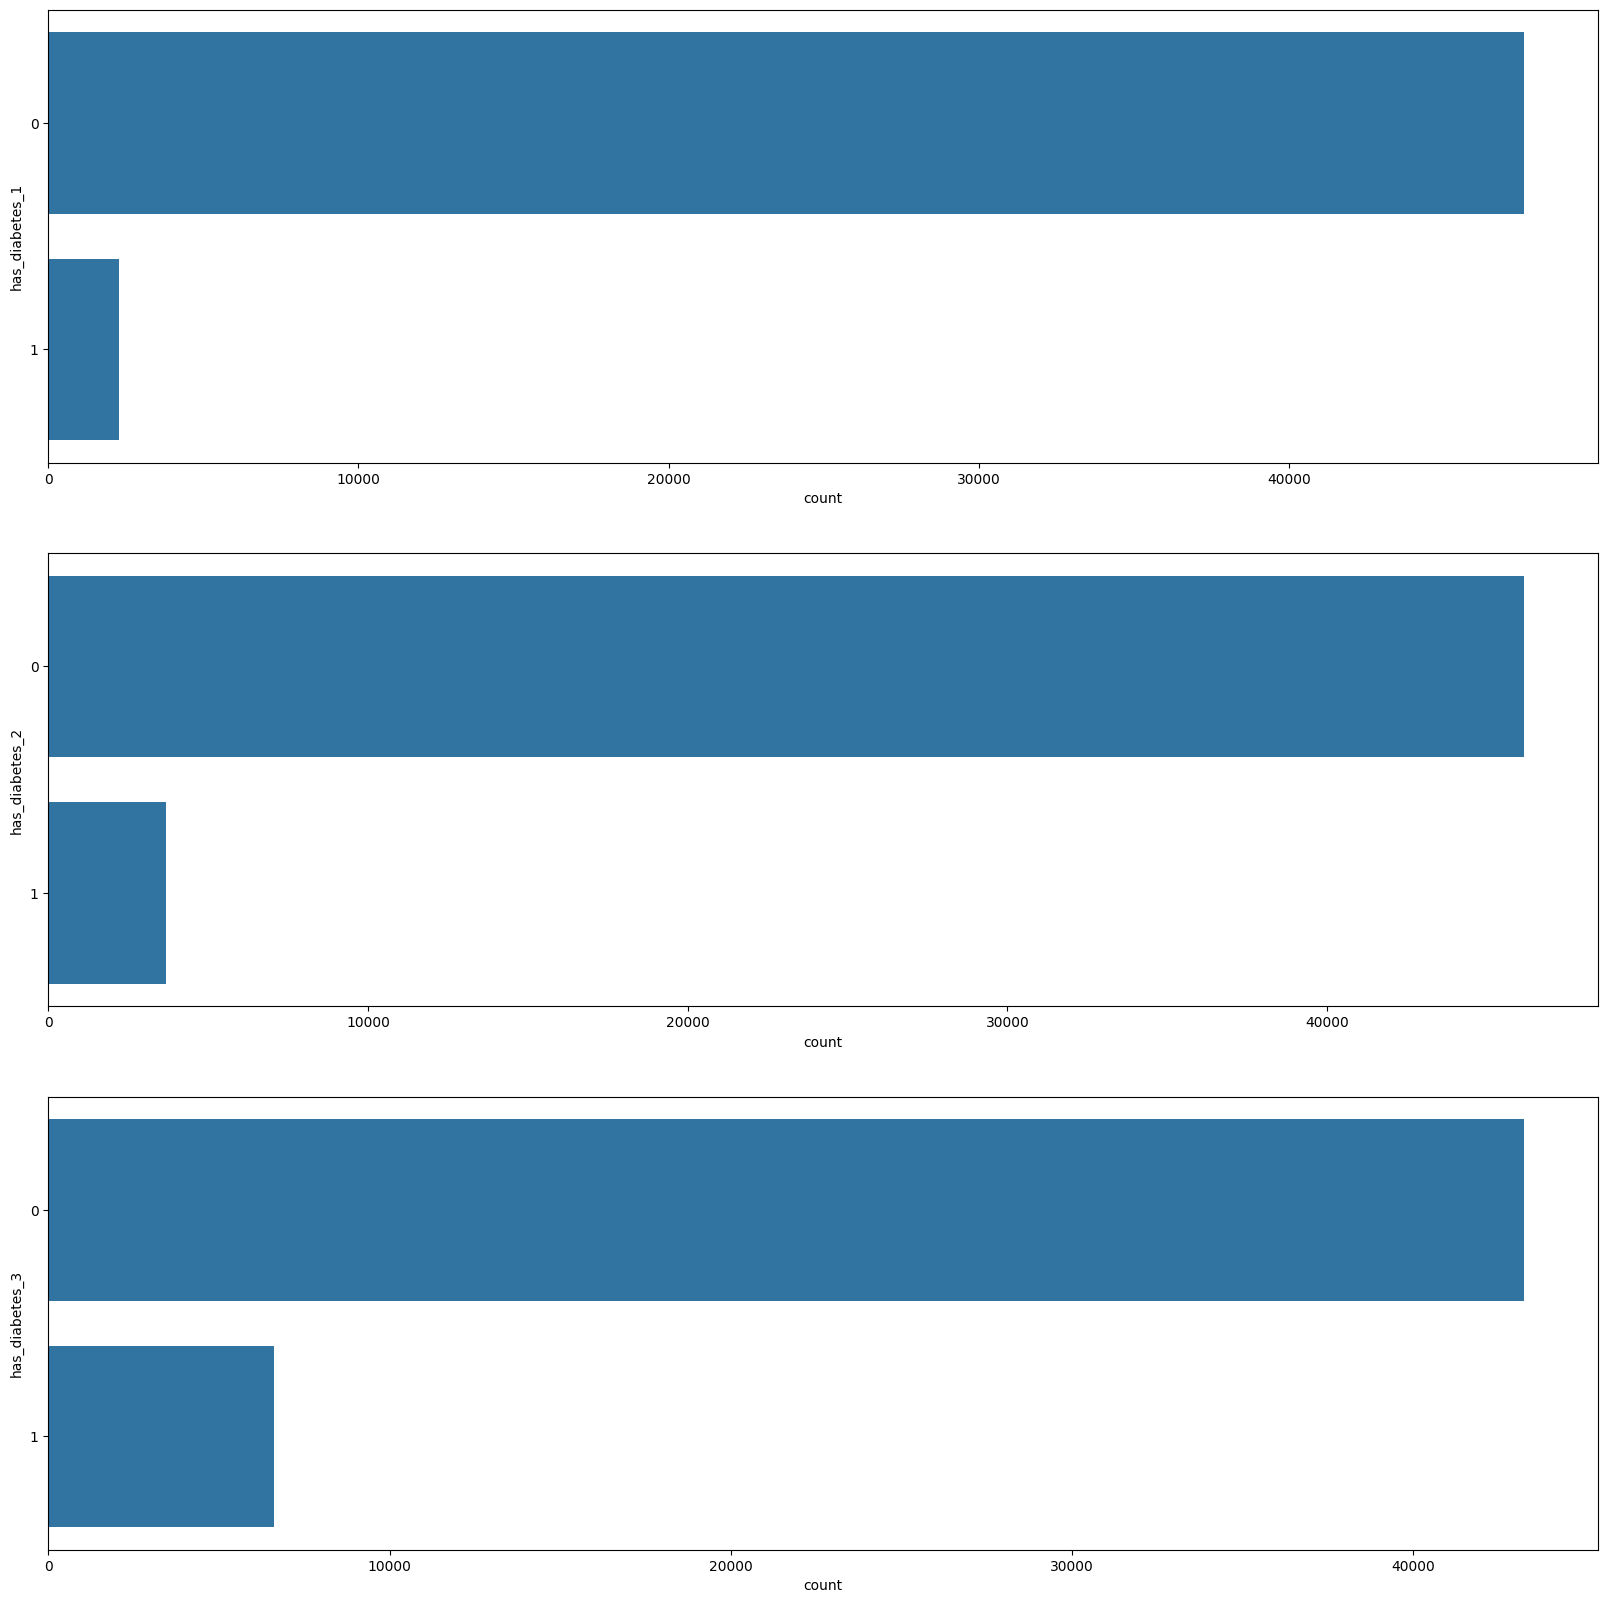

In [80]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
sns.countplot(data = train_df, y = 'has_diabetes_1')

plt.subplot(3, 1, 2)
sns.countplot(data = train_df, y = 'has_diabetes_2')

plt.subplot(3, 1, 3)
sns.countplot(data = train_df, y = 'has_diabetes_3')

plt.show()

In [81]:
group_df = train_df.groupby(['has_diabetes_1'])["readmitted_binary"].value_counts().unstack()
group_df["proportion"] = group_df["Yes"] / (group_df["Yes"] + group_df["No"]) 
group_df

readmitted_binary     No   Yes  proportion
has_diabetes_1                            
0                  42360  5237    0.110028
1                   1940   328    0.144621

In [82]:
group_df = train_df.groupby(['has_diabetes_2'])["readmitted_binary"].value_counts().unstack()
group_df["proportion"] = group_df["Yes"] / (group_df["Yes"] + group_df["No"]) 
group_df

readmitted_binary     No   Yes  proportion
has_diabetes_2                            
0                  40948  5227    0.113200
1                   3352   338    0.091599

In [83]:
group_df = train_df.groupby(['has_diabetes_3'])["readmitted_binary"].value_counts().unstack()
group_df["proportion"] = group_df["Yes"] / (group_df["Yes"] + group_df["No"]) 
group_df

readmitted_binary     No   Yes  proportion
has_diabetes_3                            
0                  38342  4911    0.113541
1                   5958   654    0.098911

In [84]:
train_df["diabetes_count"] = train_df['has_diabetes_3'] + train_df['has_diabetes_2'] + train_df['has_diabetes_1']

In [85]:
group_df = train_df.groupby(['diabetes_count'])["readmitted_binary"].value_counts().unstack()
group_df["proportion"] = group_df["Yes"] / (group_df["Yes"] + group_df["No"]) 
group_df

readmitted_binary     No   Yes  proportion
diabetes_count                            
0                  33110  4266    0.114137
1                  11130  1278    0.102998
2                     60    21    0.259259

__`OBS 22`__ Medication

In [86]:
train_df["medication"]

58848    ['glipizide', 'insulin']
69977    ['metformin', 'insulin']
70394                          []
34010                 ['insulin']
17436               ['metformin']
                   ...           
28553                          []
49117    ['glyburide', 'insulin']
69029                 ['insulin']
19984                 ['insulin']
63400                 ['insulin']
Name: medication, Length: 49865, dtype: object

In [87]:
train_df['medication_1'] = train_df['medication'].apply(eval)  # Use eval to convert string to list
train_df['medication_length'] = train_df['medication_1'].apply(len)

In [88]:
group_df = train_df.groupby(['medication_length'])["readmitted_binary"].value_counts().unstack()
group_df["proportion"] = group_df["Yes"] / (group_df["Yes"] + group_df["No"]) 
group_df

readmitted_binary       No     Yes  proportion
medication_length                             
0                  10304.0  1110.0    0.097249
1                  20448.0  2852.0    0.122403
2                   9541.0  1151.0    0.107651
3                   3378.0   388.0    0.103027
4                    599.0    62.0    0.093797
5                     29.0     NaN         NaN
6                      1.0     2.0    0.666667

In [89]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49865 entries, 58848 to 63400
Data columns (total 51 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   encounter_id                           49865 non-null  int64  
 1   country                                49865 non-null  object 
 2   patient_id                             49865 non-null  int64  
 3   race                                   49865 non-null  object 
 4   gender                                 49865 non-null  object 
 5   age                                    49865 non-null  int64  
 6   weight                                 49865 non-null  object 
 7   payer_code                             49865 non-null  object 
 8   outpatient_visits_in_previous_year     49865 non-null  int64  
 9   emergency_visits_in_previous_year      49865 non-null  int64  
 10  inpatient_visits_in_previous_year      49865 non-null  int64  
 11  adm

In [90]:
num_features.tolist()

['outpatient_visits_in_previous_year',
 'emergency_visits_in_previous_year',
 'inpatient_visits_in_previous_year',
 'average_pulse_bpm',
 'length_of_stay_in_hospital',
 'number_lab_tests',
 'non_lab_procedures',
 'number_of_medications',
 'number_diagnoses',
 'patient_id_count']

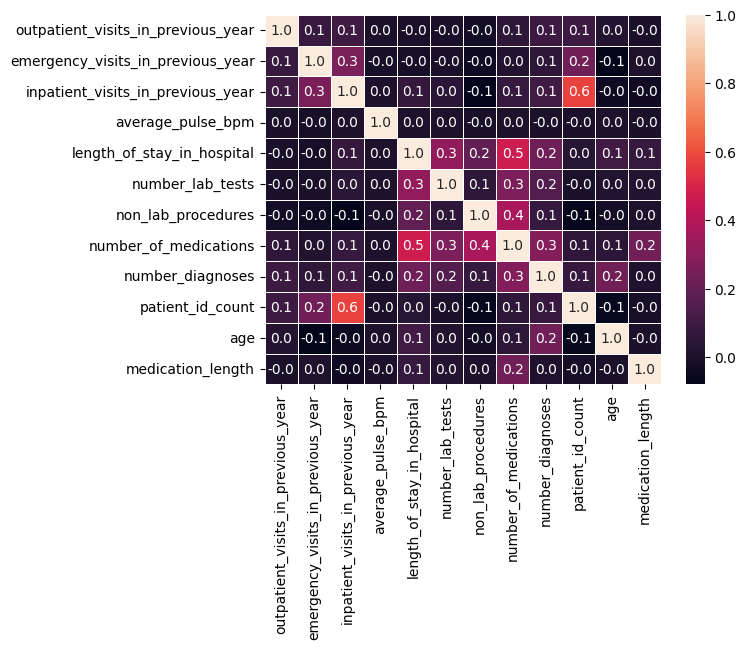

In [91]:
sns.heatmap(train_df[num_features.tolist() + ["age", "medication_length"]].corr(), annot=True, linewidth=.5, fmt=".1f")
plt.show()

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="app_pipelines">

## **4. Applying the pipelines to the training, validation, and test sets**

</a>
</div>

In [92]:
train_df = train_df_original.copy()

In [93]:
train_df_1 = pipeline_1.fit_transform(train_df)
train_df_2 = pipeline_2.fit_transform(train_df_1)
train_df_3 = pipeline_3.fit_transform(train_df_2)
train_df_3.drop("patient_id",axis=1, inplace=True)

val_df_1 = pipeline_1.fit_transform(val_df)
val_df_2 = pipeline_2.fit_transform(val_df_1)
val_df_3 = pipeline_3.fit_transform(val_df_2)
val_df_3.drop("patient_id",axis=1, inplace=True)

test_df_1 = pipeline_1.fit_transform(test_df)
test_df_2 = pipeline_2.fit_transform(test_df_1)
test_df_3 = pipeline_3.fit_transform(test_df_2)
test_df_3.drop("patient_id",axis=1, inplace=True)

In [94]:
train_data = train_df_3.copy()
val_data = val_df_3.copy()
test_data = test_df_3.copy()

In [95]:
train_data.head()

race  gender  age payer_code  \
58848        Caucasian  Female   51       None   
69977        Caucasian  Female   46         MD   
70394        Caucasian  Female   89       None   
34010        Caucasian  Female   51       None   
17436  AfricanAmerican  Female   64       None   

       outpatient_visits_in_previous_year  emergency_visits_in_previous_year  \
58848                                   0                                  0   
69977                                   0                                  0   
70394                                   0                                  0   
34010                                   0                                  0   
17436                                   0                                  0   

       inpatient_visits_in_previous_year admission_type  average_pulse_bpm  \
58848                                  3       Elective                 96   
69977                                  1      Emergency                118   
70394                                  0      Emergency                 80   
34010                                  3         Urgent                 87   
17436                                  2       Elective                 79   

      discharge_disposition  ... number_of_medications  \
58848   Short Term Hospital  ...                  28.0   
69977                   SNF  ...                  26.0   
70394                   SNF  ...                  13.0   
34010                  Home  ...                  13.0   
17436                  Home  ...                  19.0   

                                       primary_diagnosis  number_diagnoses  \
58848                                              Other               9.0   
69977                  Infectious And Parasitic Diseases               9.0   
70394                 Diseases Of The Respiratory System               6.0   
34010  Endocrine, Nutritional And Metabolic Diseases,...               9.0   
17436  Diseases Of The Musculoskeletal System And Con...               5.0   

       glucose_test_result  a1c_test_result  \
58848         Not measured     Not measured   
69977         Not measured     Not measured   
70394         Not measured     Not measured   
34010         Not measured     Not measured   
17436         Not measured     Not measured   

      change_in_meds_during_hospitalization  prescribed_diabetes_meds  \
58848                                    Ch                       Yes   
69977                                    Ch                       Yes   
70394                                    No                        No   
34010                                    No                       Yes   
17436                                    No                       Yes   

      readmitted_binary medication_length patient_id_count  
58848                No                 2                1  
69977                No                 2                2  
70394                No                 0                1  
34010                No                 1                1  
17436               Yes                 1                2  

[5 rows x 24 columns]

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="explore_2">

## **5. Exploring Training Data After Preprocessing Pipeline**

</a>
</div>

- Explore the training data after it has undergone preprocessing.

In [96]:
train_data_original = train_data.copy()

In [97]:
pd.set_option('display.max_columns', None)
train_data.head()

race  gender  age payer_code  \
58848        Caucasian  Female   51       None   
69977        Caucasian  Female   46         MD   
70394        Caucasian  Female   89       None   
34010        Caucasian  Female   51       None   
17436  AfricanAmerican  Female   64       None   

       outpatient_visits_in_previous_year  emergency_visits_in_previous_year  \
58848                                   0                                  0   
69977                                   0                                  0   
70394                                   0                                  0   
34010                                   0                                  0   
17436                                   0                                  0   

       inpatient_visits_in_previous_year admission_type  average_pulse_bpm  \
58848                                  3       Elective                 96   
69977                                  1      Emergency                118   
70394                                  0      Emergency                 80   
34010                                  3         Urgent                 87   
17436                                  2       Elective                 79   

      discharge_disposition    admission_source  length_of_stay_in_hospital  \
58848   Short Term Hospital  Physician Referral                        12.0   
69977                   SNF      Emergency Room                         5.0   
70394                   SNF      Emergency Room                        12.0   
34010                  Home      Emergency Room                         1.0   
17436                  Home  Physician Referral                         4.0   

       number_lab_tests  non_lab_procedures  number_of_medications  \
58848              68.0                 4.0                   28.0   
69977              68.0                 1.0                   26.0   
70394              37.0                 0.0                   13.0   
34010               8.0                 0.0                   13.0   
17436               1.0                 2.0                   19.0   

                                       primary_diagnosis  number_diagnoses  \
58848                                              Other               9.0   
69977                  Infectious And Parasitic Diseases               9.0   
70394                 Diseases Of The Respiratory System               6.0   
34010  Endocrine, Nutritional And Metabolic Diseases,...               9.0   
17436  Diseases Of The Musculoskeletal System And Con...               5.0   

      glucose_test_result a1c_test_result  \
58848        Not measured    Not measured   
69977        Not measured    Not measured   
70394        Not measured    Not measured   
34010        Not measured    Not measured   
17436        Not measured    Not measured   

      change_in_meds_during_hospitalization prescribed_diabetes_meds  \
58848                                    Ch                      Yes   
69977                                    Ch                      Yes   
70394                                    No                       No   
34010                                    No                      Yes   
17436                                    No                      Yes   

      readmitted_binary  medication_length  patient_id_count  
58848                No                  2                 1  
69977                No                  2                 2  
70394                No                  0                 1  
34010                No                  1                 1  
17436               Yes                  1                 2

In [98]:
train_data.describe(include="all").T

count unique  \
race                                     49865      5   
gender                                   49865      2   
age                                    49865.0    NaN   
payer_code                               49865     11   
outpatient_visits_in_previous_year     49865.0    NaN   
emergency_visits_in_previous_year      49865.0    NaN   
inpatient_visits_in_previous_year      49865.0    NaN   
admission_type                           49865      5   
average_pulse_bpm                      49865.0    NaN   
discharge_disposition                    49865      8   
admission_source                         49865      6   
length_of_stay_in_hospital             49865.0    NaN   
number_lab_tests                       49865.0    NaN   
non_lab_procedures                     49865.0    NaN   
number_of_medications                  49865.0    NaN   
primary_diagnosis                        49865     13   
number_diagnoses                       49865.0    NaN   
glucose_test_result                      49865      4   
a1c_test_result                          49865      4   
change_in_meds_during_hospitalization    49865      2   
prescribed_diabetes_meds                 49865      2   
readmitted_binary                        49865      2   
medication_length                      49865.0    NaN   
patient_id_count                       49865.0    NaN   

                                                                      top  \
race                                                            Caucasian   
gender                                                             Female   
age                                                                   NaN   
payer_code                                                           None   
outpatient_visits_in_previous_year                                    NaN   
emergency_visits_in_previous_year                                     NaN   
inpatient_visits_in_previous_year                                     NaN   
admission_type                                                  Emergency   
average_pulse_bpm                                                     NaN   
discharge_disposition                                                Home   
admission_source                                           Emergency Room   
length_of_stay_in_hospital                                            NaN   
number_lab_tests                                                      NaN   
non_lab_procedures                                                    NaN   
number_of_medications                                                 NaN   
primary_diagnosis                      Diseases Of The Circulatory System   
number_diagnoses                                                      NaN   
glucose_test_result                                          Not measured   
a1c_test_result                                              Not measured   
change_in_meds_during_hospitalization                                  No   
prescribed_diabetes_meds                                              Yes   
readmitted_binary                                                      No   
medication_length                                                     NaN   
patient_id_count                                                      NaN   

                                        freq       mean        std   min  \
race                                   39013        NaN        NaN   NaN   
gender                                 26672        NaN        NaN   NaN   
age                                      NaN  66.008022   15.90334   0.0   
payer_code                             19715        NaN        NaN   NaN   
outpatient_visits_in_previous_year       NaN   0.369036   1.285549   0.0   
emergency_visits_in_previous_year        NaN   0.198215   0.957219   0.0   
inpatient_visits_in_previous_year        NaN   0.635757   1.259309   0.0   
admission_type                         28978        NaN        NaN   NaN   
avera

In [99]:
train_data = train_data_original.copy()

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="models">

## **6. Training and evaluating the models** 

</a>
</div>


### **Useful functions**

In [100]:
# The following function performs random oversampling on the minority class in a binary classification dataset.
def oversample(X_train, y_train):
        train_data = pd.concat((X_train, y_train), axis=1)
        minority_class = train_data[train_data['readmitted_binary'] == 'Yes']
        majority_class = train_data[train_data['readmitted_binary'] == 'No']
    
        # Oversample the minority class
        oversampled_minority = minority_class.sample(n=int(len(majority_class)), replace=True, random_state=42)
        
        # Combine the oversampled minority class with the majority class
        train_data = pd.concat([majority_class, oversampled_minority])
        X_train = train_data.drop("readmitted_binary", axis=1)
        y_train = train_data["readmitted_binary"]
        return X_train, y_train

# Function to scale specified columns in training, validation, and test DataFrames using a chosen scaler.
# Default scaler is MinMaxScaler (scaler_type=0), or use RobustScaler by setting scaler_type=1.
def scale_data(train_df, val_df, test_df, columns_to_scale, scaler_type=0):
    # Choose the scaler based on the provided scaler_type
    if scaler_type == 0:
        scaler = MinMaxScaler()
    elif scaler_type == 1:
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaler_type. Use 0 for MinMaxScaler or 1 for RobustScaler.")

    # Fit the scaler on the training data
    scaler.fit(train_df[columns_to_scale])

    # Scale the specified columns in each DataFrame
    train_df[columns_to_scale] = scaler.transform(train_df[columns_to_scale])
    val_df[columns_to_scale] = scaler.transform(val_df[columns_to_scale])
    test_df[columns_to_scale] = scaler.transform(test_df[columns_to_scale])

    return train_df, val_df, test_df


# Function to label encode specified columns in training, validation, and test DataFrames.
def label_encode_dataframe(train_df, val_df, test_df, columns_to_encode):
    # Create a copy of the DataFrames to avoid modifying the originals
    encoded_train_df = train_df.copy()
    encoded_val_df = val_df.copy()
    encoded_test_df = test_df.copy()

    # Initialize a LabelEncoder
    label_encoder = LabelEncoder()

    # Apply label encoding to each specified column using the fit from the training data
    for column in columns_to_encode:
        label_encoder.fit(encoded_train_df[column])
        encoded_train_df[column] = label_encoder.transform(encoded_train_df[column])
        encoded_val_df[column] = label_encoder.transform(encoded_val_df[column])
        encoded_test_df[column] = label_encoder.transform(encoded_test_df[column])

    return encoded_train_df, encoded_val_df, encoded_test_df
    

# Function to one hot encode specified columns in training, validation, and test DataFrames.
def one_hot_encode_dataframe(train_df, val_df, test_df, columns_to_encode):
    encoded_train_df = train_df.copy()
    encoded_val_df = val_df.copy()
    encoded_test_df = test_df.copy()

    # Use pd.get_dummies for one-hot encoding
    encoded_train_df = pd.get_dummies(encoded_train_df, columns=columns_to_encode, drop_first=True)
    encoded_val_df = pd.get_dummies(encoded_val_df, columns=columns_to_encode, drop_first=True)
    encoded_test_df = pd.get_dummies(encoded_test_df, columns=columns_to_encode, drop_first=True)

    return encoded_train_df, encoded_val_df, encoded_test_df

def split_data(train_set, val_set):
    y_train = train_set["readmitted_binary"]
    y_val = val_set["readmitted_binary"]
    train_set.drop(["readmitted_binary"], axis=1, inplace=True)
    val_set.drop(["readmitted_binary"], axis=1, inplace=True)
    return train_set, val_set, y_train, y_val

def pass_pipelines(df):
    df_1 = pipeline_1.fit_transform(df)
    df_2 = pipeline_2.fit_transform(df_1)
    df_3 = pipeline_3.fit_transform(df_2)
    return df_1, df_2, df_3


# Tune a machine learning model using RandomizedSearchCV.
def tune_model_randomized(X_train, y_train, selected_features, model, param_distributions, scorer, n_iter=10, cv=5, verbose=0):
    # Instantiate RandomizedSearchCV
    k_fold = KFold(n_splits=cv, shuffle=True, random_state=42)
    randomized_search = RandomizedSearchCV(model, param_distributions, n_iter=n_iter, scoring=scorer, cv=k_fold, verbose=verbose, random_state=42)

    # Fit the Randomized Search
    randomized_search.fit(X_train[selected_features], y_train)

    # Get Best Parameters
    best_params = randomized_search.best_params_
    print(f'Best Hyperparameters: {best_params}')

    # Return the best model
    best_model = randomized_search.best_estimator_

    return best_model
    

# Function to evaluate a classification model on training and validation sets.
def evaluate_classification_model(model, X_train, y_train, X_val, y_val):
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predictions on the training set
    train_pred = model.predict(X_train)

    # Predictions on the validation set
    val_pred = model.predict(X_val)

    # Evaluate the model on the training set
    accuracy_train = accuracy_score(y_train, train_pred)
    print(f'Training Accuracy: {accuracy_train:.2f}')

    # Generate a classification report for the training set
    report_train = classification_report(y_train, train_pred)
    print(f'Training Classification Report:\n{report_train}')

    # Create a confusion matrix for the training set
    confusion_train = confusion_matrix(y_train, train_pred)
    print(f'Training Confusion Matrix:\n{confusion_train}')

    # Evaluate the model on the validation set
    accuracy_val = accuracy_score(y_val, val_pred)
    print(f'Validation Accuracy: {accuracy_val:.2f}')

    # Generate a classification report for the validation set
    report_val = classification_report(y_val, val_pred)
    print(f'Validation Classification Report:\n{report_val}')

    # Create a confusion matrix for the validation set
    confusion_val = confusion_matrix(y_val, val_pred)
    print(f'Validation Confusion Matrix:\n{confusion_val}')


train_df_2 = pd.read_csv("data/train.csv")
test_df_2 = pd.read_csv("data/test.csv")

y = train_df_2["readmitted_binary"]
X = train_df_2.drop(["readmitted_binary"], axis=1)

def avg_f1_score(model):
    # apply kfold
    skf = StratifiedKFold(n_splits=5)
    # create lists to store the results from the different models 
    f1_train = []
    f1_test = []
    recall_test = []
    precision_test = []
    recall_train = []
    precision_train = []
    timer = []
    n_iter = []
    
    for train_index, test_index in skf.split(X, y):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        
        X_train = pd.concat([X_train, y_train], axis=1)
        X_val = pd.concat([X_val, y_val], axis=1)

        X_train_1, X_train_2, X_train_3 = pass_pipelines(X_train)
        X_val_1, X_val_2, X_val_3 = pass_pipelines(X_val)
        X_train = X_train_3.copy()
        X_val = X_val_3.copy()
        
        train_scaled, val_scaled, _ = scale_data(train_data, val_data, test_data, numeric_columns, scaler_type=0)
        train_scaled_encoded, val_scaled_encoded, _ = label_encode_dataframe(train_scaled, val_scaled, test_data, categorical_columns)
        
        X_train, X_val, y_train, y_val = split_data(train_scaled_encoded, val_scaled_encoded)
        
        X_train, y_train = oversample(X_train, y_train)
        
        scaled_X_train = X_train[selected_features].copy()
        scaled_X_val = X_val[selected_features].copy()
        
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(scaled_X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        
        val_pred = model.predict(scaled_X_val)
        train_pred = model.predict(scaled_X_train)
        
        # calculate F1 score for the positive class ('Yes') on train and test sets
        f1_train.append(f1_score(y_train, train_pred, pos_label='Yes'))
        recall_train.append(recall_score(y_train, train_pred, pos_label='Yes'))
        precision_train.append(precision_score(y_train, train_pred, pos_label='Yes'))

        # Metrics for "Yes" class on the validation set
        f1_test.append(f1_score(y_val, val_pred, pos_label='Yes'))
        recall_test.append(recall_score(y_val, val_pred, pos_label='Yes'))
        precision_test.append(precision_score(y_val, val_pred, pos_label='Yes'))
        
        # append the time and the number of iterations in the corresponding list
        timer.append(end - begin)
        if hasattr(model, 'n_iter_'):
            n_iter.append(model.n_iter_)
        else:
            n_iter.append(np.nan)
    
    # calculate the average and the std for each measure (F1 score, time, and number of iterations)
    avg_time = round(np.mean(timer), 3)
    avg_train_f1 = round(np.mean(f1_train), 3)
    avg_train_recall = round(np.mean(recall_train), 3)
    avg_train_precision = round(np.mean(precision_train), 3)
    
    avg_test_f1 = round(np.mean(f1_test), 3)
    avg_test_recall = round(np.mean(recall_test), 3)
    avg_test_precision = round(np.mean(precision_test), 3)

    std_time = round(np.std(timer), 2)
    std_train_f1 = round(np.std(f1_train), 2)
    std_train_recall = round(np.std(recall_train), 2)
    std_train_precision = round(np.std(precision_train), 2)
    
    std_test_f1 = round(np.std(f1_test), 2)
    std_test_recall = round(np.std(recall_test), 2)
    std_test_precision = round(np.std(precision_test), 2)
    
    avg_iter = round(np.mean(n_iter), 1)
    std_iter = round(np.std(n_iter), 1)

    return (
        str(avg_time) + '+/-' + str(std_time),
        str(avg_train_f1) + '+/-' + str(std_train_f1),
        str(avg_test_f1) + '+/-' + str(std_test_f1),
        str(avg_train_precision) + '+/-' + str(std_train_precision),
        str(avg_test_precision) + '+/-' + str(std_test_precision),
        str(avg_train_recall) + '+/-' + str(std_train_recall),
        str(avg_test_recall) + '+/-' + str(std_test_recall),
        str(avg_iter) + '+/-' + str(std_iter),
        f1_train,
        f1_test
    )

def show_results(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    f1_train_scores = []
    f1_val_scores = []
    # for each model passed as argument
    #scale = scale
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test, avg_train_precision, avg_test_precision,avg_train_recall, avg_test_recall, avg_iter, f1_train, f1_test = avg_f1_score(arg)
        f1_train_scores.append(f1_train)
        f1_val_scores.append(f1_test)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test, avg_train_precision, avg_test_precision,avg_train_recall, avg_test_recall, avg_iter
        count+=1
    return df, f1_train_scores, f1_val_scores

### **Scaling, Encoding and Oversampling**

In [101]:
# Define columns
numeric_columns = ['inpatient_visits_in_previous_year', 'outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year',
                   'length_of_stay_in_hospital', 'number_diagnoses', 'age', 'number_lab_tests', 'non_lab_procedures',
                   'number_of_medications', 'medication_length', 'patient_id_count', 'average_pulse_bpm']

categorical_columns = ['race', 'gender', 'admission_type', 'admission_source', 'glucose_test_result', 'a1c_test_result',
                       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'primary_diagnosis',
                       'discharge_disposition', 'payer_code']

# Scale the data
train_data, val_data, test_data = scale_data(train_data, val_data, test_data, numeric_columns, scaler_type=0)

# Encode the data
train_data, val_data, test_data = label_encode_dataframe(train_data, val_data, test_data, categorical_columns)
#train_data, val_data, test_data = one_hot_encode_dataframe(train_data, val_data, test_data, categorical_columns)

# Split data into features and labels
y_train = train_data["readmitted_binary"]
X_train = train_data.drop("readmitted_binary", axis=1)
y_val = val_data["readmitted_binary"]
X_val = val_data.drop("readmitted_binary", axis=1)

# Oversampling
# SMOTE oversampling
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

# Random oversampling
X_train, y_train = oversample(X_train, y_train)

In [102]:
X_train.columns

Index(['race', 'gender', 'age', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'average_pulse_bpm', 'discharge_disposition', 'admission_source',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'primary_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication_length', 'patient_id_count'],
      dtype='object')

### **Feature Selection**

Calculating the features importances based on a random forest

In [103]:
# Train a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Access Feature Importances
importances = rf_model.feature_importances_

# Create a list of (feature, importance) pairs and sort it by importance
feature_importance_pairs = list(zip(X_train.columns, importances))
sorted_feature_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Extract sorted feature names
sorted_features = [feature for feature, importance in sorted_feature_importance]

# Print the sorted features
print("Features Sorted by Importance:")
print(sorted_features)

Features Sorted by Importance:
['patient_id_count', 'average_pulse_bpm', 'number_lab_tests', 'age', 'number_of_medications', 'length_of_stay_in_hospital', 'primary_diagnosis', 'inpatient_visits_in_previous_year', 'discharge_disposition', 'payer_code', 'number_diagnoses', 'non_lab_procedures', 'medication_length', 'admission_type', 'admission_source', 'outpatient_visits_in_previous_year', 'race', 'a1c_test_result', 'gender', 'emergency_visits_in_previous_year', 'change_in_meds_during_hospitalization', 'glucose_test_result', 'prescribed_diabetes_meds']


Selecting only the top 10 most important features

In [104]:
selected_features = sorted_features[0:10]
print(selected_features)

['patient_id_count', 'average_pulse_bpm', 'number_lab_tests', 'age', 'number_of_medications', 'length_of_stay_in_hospital', 'primary_diagnosis', 'inpatient_visits_in_previous_year', 'discharge_disposition', 'payer_code']


### **Model Tunning**

In [105]:
# Defining the metric that will be used to evaluate the models
scorer = make_scorer(f1_score, pos_label="Yes")

**Random forest**

~ 2 min to run

In [106]:
# # Define the hyperparameter
# param_distributions = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [5, 8, 10, 15],
#     'min_samples_split': uniform(0, 0.4),
# }

# start_time = time.time()
# # Instantiate the model
# rf_model = RandomForestClassifier(random_state=42)

# # Tune the model using randomized search
# best_rf_model = tune_model_randomized(X_train, y_train, selected_features, rf_model, param_distributions, scorer=scorer, n_iter=10, cv=4, verbose=4)
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

**Results of the random search**

In [107]:
best_rf_model = RandomForestClassifier(max_depth= 15, min_samples_split= 0.009224970016566303, n_estimators= 100, random_state=42)

**MLP classifier**

~ 8 min to run

In [108]:
# # Define the hyperparameter distributions
# mlp_param_distributions = {
#     'hidden_layer_sizes': [(30,),(50,),(30,15)],
#     'activation': ['logistic', 'tanh', 'relu'],
#     'alpha': uniform(0.001, 0.1),
# }

# start_time = time.time()

# mlp_model = MLPClassifier(random_state=42)

# # Tune the model using randomized search with stratified k-fold cross-validation
# best_mlp_model = tune_model_randomized(X_train, y_train, selected_features, mlp_model, mlp_param_distributions, scorer=scorer, n_iter=10, cv=4, verbose=4)

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")


**Results of the random search**

In [109]:
best_mlp_model = MLPClassifier(activation= 'relu', alpha= 0.0466069984217036, hidden_layer_sizes= (30, 15), random_state=42)

**Ada boost**

~ 8 min to run

In [110]:
# adaboost_param_distributions = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': uniform(0.5, 1),
# }

# start_time = time.time()

# adaboost_model = AdaBoostClassifier(random_state=42)

# # Tune the model using randomized search with stratified k-fold cross-validation
# best_adaboost_model = tune_model_randomized(X_train, y_train, selected_features, adaboost_model, adaboost_param_distributions, scorer=scorer, n_iter=10, cv=4, verbose=4)

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")


**Results of the random search**

In [111]:
best_adaboost_model = AdaBoostClassifier(learning_rate= 0.8745401188473625, n_estimators= 50, random_state=42)

**Categorical NB**

~ 18 seconds to run

In [112]:
# # Define the hyperparameter grid
# categorical_nb_param_grid = {
#     'alpha': uniform(0.1, 1.9),  # Smoothing parameter
# }

# start_time = time.time()

# # Create a Categorical Naive Bayes model
# categorical_nb_model = CategoricalNB()

# # Tune the model using randomized search with stratified k-fold cross-validation
# best_categorical_nb_model = tune_model_randomized(
#     X_train, y_train, selected_features, categorical_nb_model,
#     categorical_nb_param_grid, scorer=scorer, n_iter=10, cv=4, verbose=4
# )

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

**Results of the random search**

In [113]:
best_categorical_nb_model = CategoricalNB(alpha= 0.39643541684062933)

**Gradient boosting**

~ 6 min to run

In [114]:
# # Gradient Boosting parameter distributions
# gradient_boosting_param_distributions = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': uniform(0.01, 0.5),  # Adjust the range based on your preferences
#     'max_depth': [3, 5, 7],  # Adjust the range based on your preferences
# }

# start_time = time.time()

# gradient_boosting_model = GradientBoostingClassifier(random_state=42)

# # Tune the model using randomized search with stratified k-fold cross-validation
# best_gradient_boosting_model = tune_model_randomized(
#     X_train, y_train, selected_features, gradient_boosting_model,
#     gradient_boosting_param_distributions, scorer=scorer, n_iter=10, cv=4, verbose=4
# )

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

**Results of the random search**

In [115]:
best_gradient_boosting_model = GradientBoostingClassifier(learning_rate= 0.23803499210851797, max_depth= 7, n_estimators= 100, random_state=42)

### **Model Selection**

Using cross validation to evaluate each model perforamance without data leakage

~ 16 min to run

In [116]:
# index = ['MLP','RF','AdaBoost', 'NB', 'GB']

# start_time = time.time()

# df = pd.DataFrame(columns = ['Time','Train F1','Test F1','Train Precision','Test Precision','Train Recall','Test Recall', 'Iterations'], index = index)
# df, f1_train_scores, f1_val_scores = show_results(df, best_rf_model, best_adaboost_model, best_mlp_model, best_categorical_nb_model, best_gradient_boosting_model)

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

In [117]:
# df

**Results from cross validation**

In [118]:
index = ['RF','AdaBoost','Mlp', 'NB', 'GB']

results = {
    'Time': ['9.177+/-0.75', '11.579+/-0.89', '46.736+/-1.74', '0.452+/-0.04', '28.283+/-0.6'],
    'Train F1': ['0.71+/-0.0', '0.668+/-0.0', '0.694+/-0.0', '0.534+/-0.0', '0.879+/-0.0'],
    'Test F1': ['0.313+/-0.0', '0.305+/-0.0', '0.305+/-0.0', '0.217+/-0.0', '0.256+/-0.0'],
    'Train Precision': ['0.686+/-0.0', '0.683+/-0.0', '0.677+/-0.0', '0.58+/-0.0', '0.866+/-0.0'],
    'Test Precision': ['0.216+/-0.0', '0.229+/-0.0', '0.211+/-0.0', '0.141+/-0.0', '0.219+/-0.0'],
    'Train Recall': ['0.736+/-0.0', '0.654+/-0.0', '0.713+/-0.0', '0.495+/-0.0', '0.892+/-0.0'],
    'Test Recall': ['0.568+/-0.0', '0.457+/-0.0', '0.548+/-0.0', '0.475+/-0.0', '0.31+/-0.0'],
    'Iterations': ['nan+/-nan', 'nan+/-nan', '105.0+/-0.0', 'nan+/-nan', 'nan+/-nan']
}

# Create DataFrame
df = pd.DataFrame(results, index=index)

f1_train_scores = [
    [0.7096198426259482, 0.7096198426259482, 0.7096198426259482, 0.7096198426259482, 0.7096198426259482],
    [0.6670587556939399, 0.6670587556939399, 0.6670587556939399, 0.6670587556939399, 0.6670587556939399],
    [0.6944508002920058, 0.6944508002920058, 0.6944508002920058, 0.6944508002920058, 0.6944508002920058],
    [0.5338567701348418, 0.5338567701348418, 0.5338567701348418, 0.5338567701348418, 0.5338567701348418],
    [0.8713721718318365, 0.8713721718318365, 0.8713721718318365, 0.8713721718318365, 0.8713721718318365]
]

f1_val_scores = [
    [0.311368909512761, 0.311368909512761, 0.311368909512761, 0.311368909512761, 0.311368909512761],
    [0.3047619047619048, 0.3047619047619048, 0.3047619047619048, 0.3047619047619048, 0.3047619047619048],
    [0.30476190476190473, 0.30476190476190473, 0.30476190476190473, 0.30476190476190473, 0.30476190476190473],
    [0.21754183496826315, 0.21754183496826315, 0.21754183496826315, 0.21754183496826315, 0.21754183496826315],
    [0.24441388793399796, 0.24441388793399796, 0.24441388793399796, 0.24441388793399796, 0.24441388793399796]
]

# Display the DataFrame
df


Time     Train F1      Test F1 Train Precision  \
RF         9.177+/-0.75   0.71+/-0.0  0.313+/-0.0     0.686+/-0.0   
AdaBoost  11.579+/-0.89  0.668+/-0.0  0.305+/-0.0     0.683+/-0.0   
Mlp       46.736+/-1.74  0.694+/-0.0  0.305+/-0.0     0.677+/-0.0   
NB         0.452+/-0.04  0.534+/-0.0  0.217+/-0.0      0.58+/-0.0   
GB         28.283+/-0.6  0.879+/-0.0  0.256+/-0.0     0.866+/-0.0   

         Test Precision Train Recall  Test Recall   Iterations  
RF          0.216+/-0.0  0.736+/-0.0  0.568+/-0.0    nan+/-nan  
AdaBoost    0.229+/-0.0  0.654+/-0.0  0.457+/-0.0    nan+/-nan  
Mlp         0.211+/-0.0  0.713+/-0.0  0.548+/-0.0  105.0+/-0.0  
NB          0.141+/-0.0  0.495+/-0.0  0.475+/-0.0    nan+/-nan  
GB          0.219+/-0.0  0.892+/-0.0   0.31+/-0.0    nan+/-nan

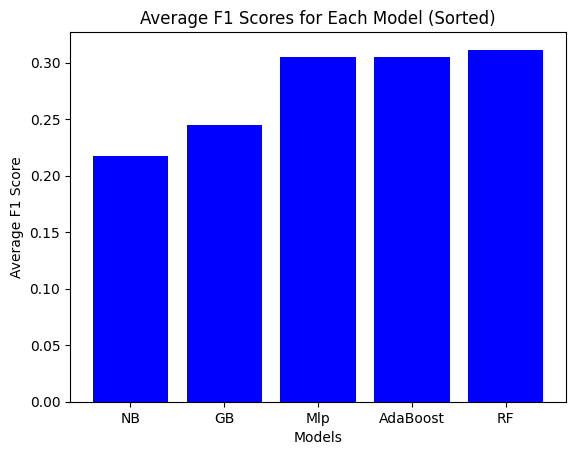

In [119]:
average_f1_scores = np.mean(f1_val_scores, axis=1)

# Sort models based on average F1 scores
sorted_indices = np.argsort(average_f1_scores)
sorted_f1_scores = average_f1_scores[sorted_indices]

# Model labels
model_labels = [index[i] for i in sorted_indices]

# Create a bar plot
plt.bar(model_labels, sorted_f1_scores, color='blue')
plt.xlabel('Models')
plt.ylabel('Average F1 Score')
plt.title('Average F1 Scores for Each Model (Sorted)')
plt.show()

Choose the top-performing models and execute them using the holdout method to obtain comprehensive reports, facilitating a more thorough comparison of model performance

Adaboost

In [120]:
evaluate_classification_model(best_adaboost_model, X_train[selected_features], y_train, X_val[selected_features], y_val)

Training Accuracy: 0.67
Training Classification Report:
              precision    recall  f1-score   support

          No       0.67      0.70      0.68     44300
         Yes       0.68      0.65      0.67     44300

    accuracy                           0.67     88600
   macro avg       0.68      0.67      0.67     88600
weighted avg       0.68      0.67      0.67     88600

Training Confusion Matrix:
[[30871 13429]
 [15372 28928]]
Validation Accuracy: 0.77
Validation Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.81      0.86     18986
         Yes       0.23      0.45      0.30      2385

    accuracy                           0.77     21371
   macro avg       0.57      0.63      0.58     21371
weighted avg       0.84      0.77      0.80     21371

Validation Confusion Matrix:
[[15330  3656]
 [ 1305  1080]]


Random Forest

In [121]:
evaluate_classification_model(best_rf_model, X_train[selected_features], y_train, X_val[selected_features], y_val)

Training Accuracy: 0.70
Training Classification Report:
              precision    recall  f1-score   support

          No       0.72      0.66      0.69     44300
         Yes       0.68      0.74      0.71     44300

    accuracy                           0.70     88600
   macro avg       0.70      0.70      0.70     88600
weighted avg       0.70      0.70      0.70     88600

Training Confusion Matrix:
[[29209 15091]
 [11625 32675]]
Validation Accuracy: 0.72
Validation Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.74      0.82     18986
         Yes       0.21      0.57      0.31      2385

    accuracy                           0.72     21371
   macro avg       0.57      0.65      0.57     21371
weighted avg       0.85      0.72      0.77     21371

Validation Confusion Matrix:
[[14015  4971]
 [ 1029  1356]]


MLP Classifier

In [122]:
evaluate_classification_model(best_mlp_model, X_train[selected_features], y_train, X_val[selected_features], y_val)

Training Accuracy: 0.68
Training Classification Report:
              precision    recall  f1-score   support

          No       0.70      0.65      0.67     44300
         Yes       0.67      0.72      0.69     44300

    accuracy                           0.68     88600
   macro avg       0.68      0.68      0.68     88600
weighted avg       0.68      0.68      0.68     88600

Training Confusion Matrix:
[[28622 15678]
 [12463 31837]]
Validation Accuracy: 0.71
Validation Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.73      0.82     18986
         Yes       0.21      0.56      0.30      2385

    accuracy                           0.71     21371
   macro avg       0.57      0.65      0.56     21371
weighted avg       0.85      0.71      0.76     21371

Validation Confusion Matrix:
[[13875  5111]
 [ 1049  1336]]


**Final Decision:** While the MLP Classifier and Random Forest models exhibit higher overall F1 scores, the AdaBoost model showcases a more balanced performance with closely aligned recall and precision metrics. This equilibrium in recall and precision suggests that AdaBoost may provide a more robust and reliable classification, making it a compelling choice even in situations where the F1 score alone might favor other models. The decision to select the most suitable model should consider the specific requirements and trade-offs between precision and recall, with AdaBoost standing out for its balanced performance.

### **Adaboost tunning**

In [123]:
best_adaboost_model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 0.8745401188473625,
 'n_estimators': 50,
 'random_state': 42}

Lets increase the number of estimators and check if we get better results

Looks like above 200 the performance does not increase a lot

**N_estimator = 10**

In [124]:
best_adaboost_model_1 = AdaBoostClassifier(n_estimators=10, learning_rate=0.87)
evaluate_classification_model(best_adaboost_model_1, X_train[selected_features], y_train, X_val[selected_features], y_val)

Training Accuracy: 0.67
Training Classification Report:
              precision    recall  f1-score   support

          No       0.66      0.70      0.68     44300
         Yes       0.68      0.64      0.66     44300

    accuracy                           0.67     88600
   macro avg       0.67      0.67      0.67     88600
weighted avg       0.67      0.67      0.67     88600

Training Confusion Matrix:
[[31055 13245]
 [15815 28485]]
Validation Accuracy: 0.77
Validation Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.82      0.86     18986
         Yes       0.23      0.44      0.30      2385

    accuracy                           0.77     21371
   macro avg       0.58      0.63      0.58     21371
weighted avg       0.84      0.77      0.80     21371

Validation Confusion Matrix:
[[15478  3508]
 [ 1336  1049]]


**N_estimator = 100**

In [125]:
best_adaboost_model_2 = AdaBoostClassifier(n_estimators=100, learning_rate=0.87)
evaluate_classification_model(best_adaboost_model_2, X_train[selected_features], y_train, X_val[selected_features], y_val)

Training Accuracy: 0.67
Training Classification Report:
              precision    recall  f1-score   support

          No       0.67      0.70      0.68     44300
         Yes       0.68      0.65      0.67     44300

    accuracy                           0.67     88600
   macro avg       0.67      0.67      0.67     88600
weighted avg       0.67      0.67      0.67     88600

Training Confusion Matrix:
[[30805 13495]
 [15422 28878]]
Validation Accuracy: 0.77
Validation Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.81      0.86     18986
         Yes       0.23      0.46      0.30      2385

    accuracy                           0.77     21371
   macro avg       0.57      0.63      0.58     21371
weighted avg       0.84      0.77      0.80     21371

Validation Confusion Matrix:
[[15284  3702]
 [ 1294  1091]]


**N_estimator = 200**

In [126]:
best_adaboost_model_3 = AdaBoostClassifier(n_estimators=200, learning_rate=0.87)
evaluate_classification_model(best_adaboost_model_3, X_train[selected_features], y_train, X_val[selected_features], y_val)

Training Accuracy: 0.67
Training Classification Report:
              precision    recall  f1-score   support

          No       0.67      0.70      0.68     44300
         Yes       0.68      0.65      0.66     44300

    accuracy                           0.67     88600
   macro avg       0.67      0.67      0.67     88600
weighted avg       0.67      0.67      0.67     88600

Training Confusion Matrix:
[[30830 13470]
 [15529 28771]]
Validation Accuracy: 0.77
Validation Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.81      0.86     18986
         Yes       0.23      0.46      0.31      2385

    accuracy                           0.77     21371
   macro avg       0.58      0.63      0.58     21371
weighted avg       0.84      0.77      0.80     21371

Validation Confusion Matrix:
[[15290  3696]
 [ 1289  1096]]


**N_estimator = 300**

In [127]:
best_adaboost_model_4 = AdaBoostClassifier(n_estimators=300, learning_rate=0.87)
evaluate_classification_model(best_adaboost_model_4, X_train[selected_features], y_train, X_val[selected_features], y_val)

Training Accuracy: 0.67
Training Classification Report:
              precision    recall  f1-score   support

          No       0.67      0.70      0.68     44300
         Yes       0.68      0.65      0.67     44300

    accuracy                           0.67     88600
   macro avg       0.67      0.67      0.67     88600
weighted avg       0.67      0.67      0.67     88600

Training Confusion Matrix:
[[30859 13441]
 [15403 28897]]
Validation Accuracy: 0.77
Validation Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.81      0.86     18986
         Yes       0.23      0.46      0.31      2385

    accuracy                           0.77     21371
   macro avg       0.58      0.63      0.58     21371
weighted avg       0.84      0.77      0.80     21371

Validation Confusion Matrix:
[[15302  3684]
 [ 1292  1093]]


The final model is the ada boost with 200 estimators

In [128]:
final_model = best_adaboost_model_3 

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="pred_test">

## **7. Predicitions on the test data**

</a>
</div>

- Make predictions with all the trained models and then see the value counts of each prediction

In [129]:
pred_3 = final_model.predict(test_data[selected_features])

In [130]:
pd.Series(pred_3).value_counts()

No     22305
Yes     8225
Name: count, dtype: int64

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="comp_sub">

## **8. Comparing with best submission**

</a>
</div>

In [131]:
# best_results = pd.read_csv("Group37_Version63.csv")

In [132]:
# best_results = best_results["readmitted_binary"].to_list()

In [133]:
# my_results = pred_3

In [134]:
# from sklearn.metrics import confusion_matrix

# predictions_bst = best_results
# predictions_present_try = my_results

# # Define the classes (labels)
# classes = ["Yes", "No"]

# # Generate confusion matrix
# conf_matrix = confusion_matrix(predictions_present_try, predictions_bst)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(conf_matrix)



<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="csv_file">

## **9. Writing to a csv file (to submit to kaggle)**

</a>
</div>

In [135]:
# X_train_2 = pd.read_csv("data/test.csv")

In [136]:
# encounter_id_df = X_train_2[["encounter_id"]].copy()

# # Convert predictions to a DataFrame
# predictions_df = pd.DataFrame(pred_3, columns=["readmitted_binary"]) 

# # Concatenate the two DataFrames horizontally
# result_df = pd.concat([encounter_id_df, predictions_df], axis=1)
# result_df.index = np.arange(1, len(result_df) + 1)

In [137]:
# result_df.to_csv("Group37_Version68.csv", index=False)

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="m_1">

## **10. Importing Data (Multiclass)**

</a>
</div>

In [138]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [139]:
y_1 = train_df["readmitted_binary"]
y_2 = train_df["readmitted_multiclass"]
X = train_df.drop(["readmitted_binary", "readmitted_multiclass"], axis = 1)

In [140]:
X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X,y_2, test_size = 0.3, 
                                                  random_state = 0, 
                                                  stratify = y_2, 
                                                  shuffle = True)

In [141]:
train_df_m = pd.concat([X_train_m, y_train_m], axis=1)
val_df_m = pd.concat([X_val_m, y_val_m], axis=1)

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="m_2">

## **11. Data Exploration (Multiclass)**

</a>
</div>

Looks like we have a class imbalance

In [142]:
aux_df = train_df.copy()

In [143]:
train_df["readmitted_multiclass"].value_counts()

readmitted_multiclass
No          38405
>30 days    24881
<30 days     7950
Name: count, dtype: int64

In [144]:
train_df['patient_id_count'] = train_df['patient_id'].map(train_df['patient_id'].value_counts())

 Patients readmitted within < 30 days appear more frequently in the dataset # followed by those readmitted >30 days, and then individuals who have not been readmitte. This bar plot provides insights into the distribution of readmission patterns.

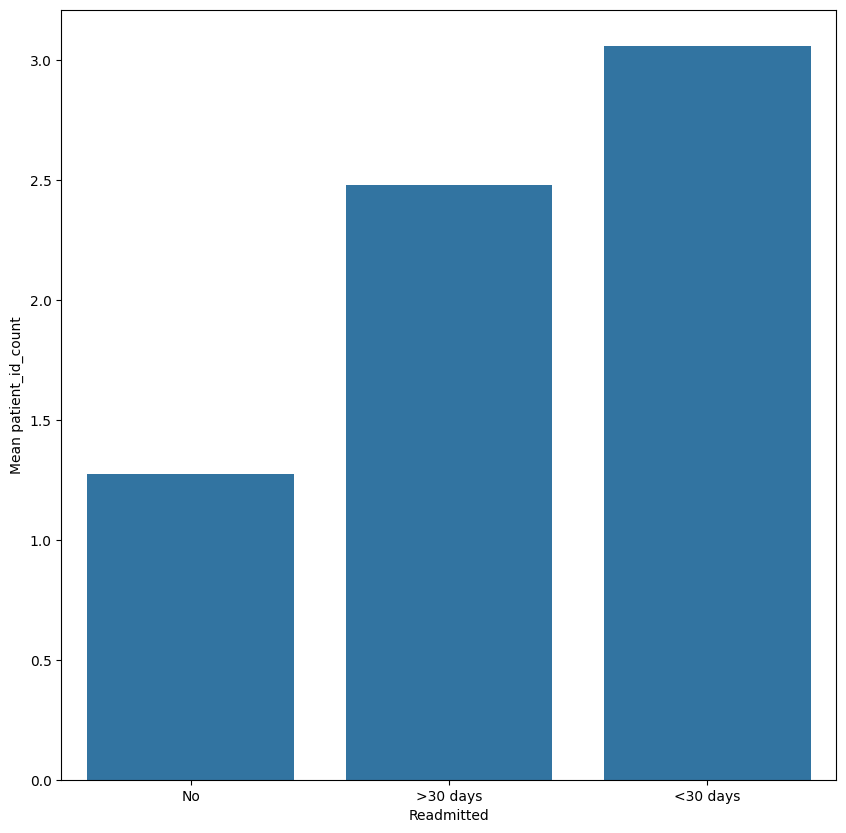

In [145]:
plt.figure(figsize=(10, 10))
sns.barplot(x='readmitted_multiclass', y='patient_id_count', data=train_df, errorbar=None, order=train_df.groupby('readmitted_multiclass')['patient_id_count'].mean().sort_values().index)
plt.xlabel('Readmitted')
plt.ylabel('Mean patient_id_count')
#plt.savefig("patient_id_count_m")
plt.show()

From the next plot, we can observe that the columns "inpatients_visits_in_previous_years," "outpatients_visits_in_previous_years," "emergency_visits_in_previous_years," "non_lab_procedures," and "length_of_stay_in_hospital" appear to exert a more significant influence on the "readmitted_multiclass" variable.

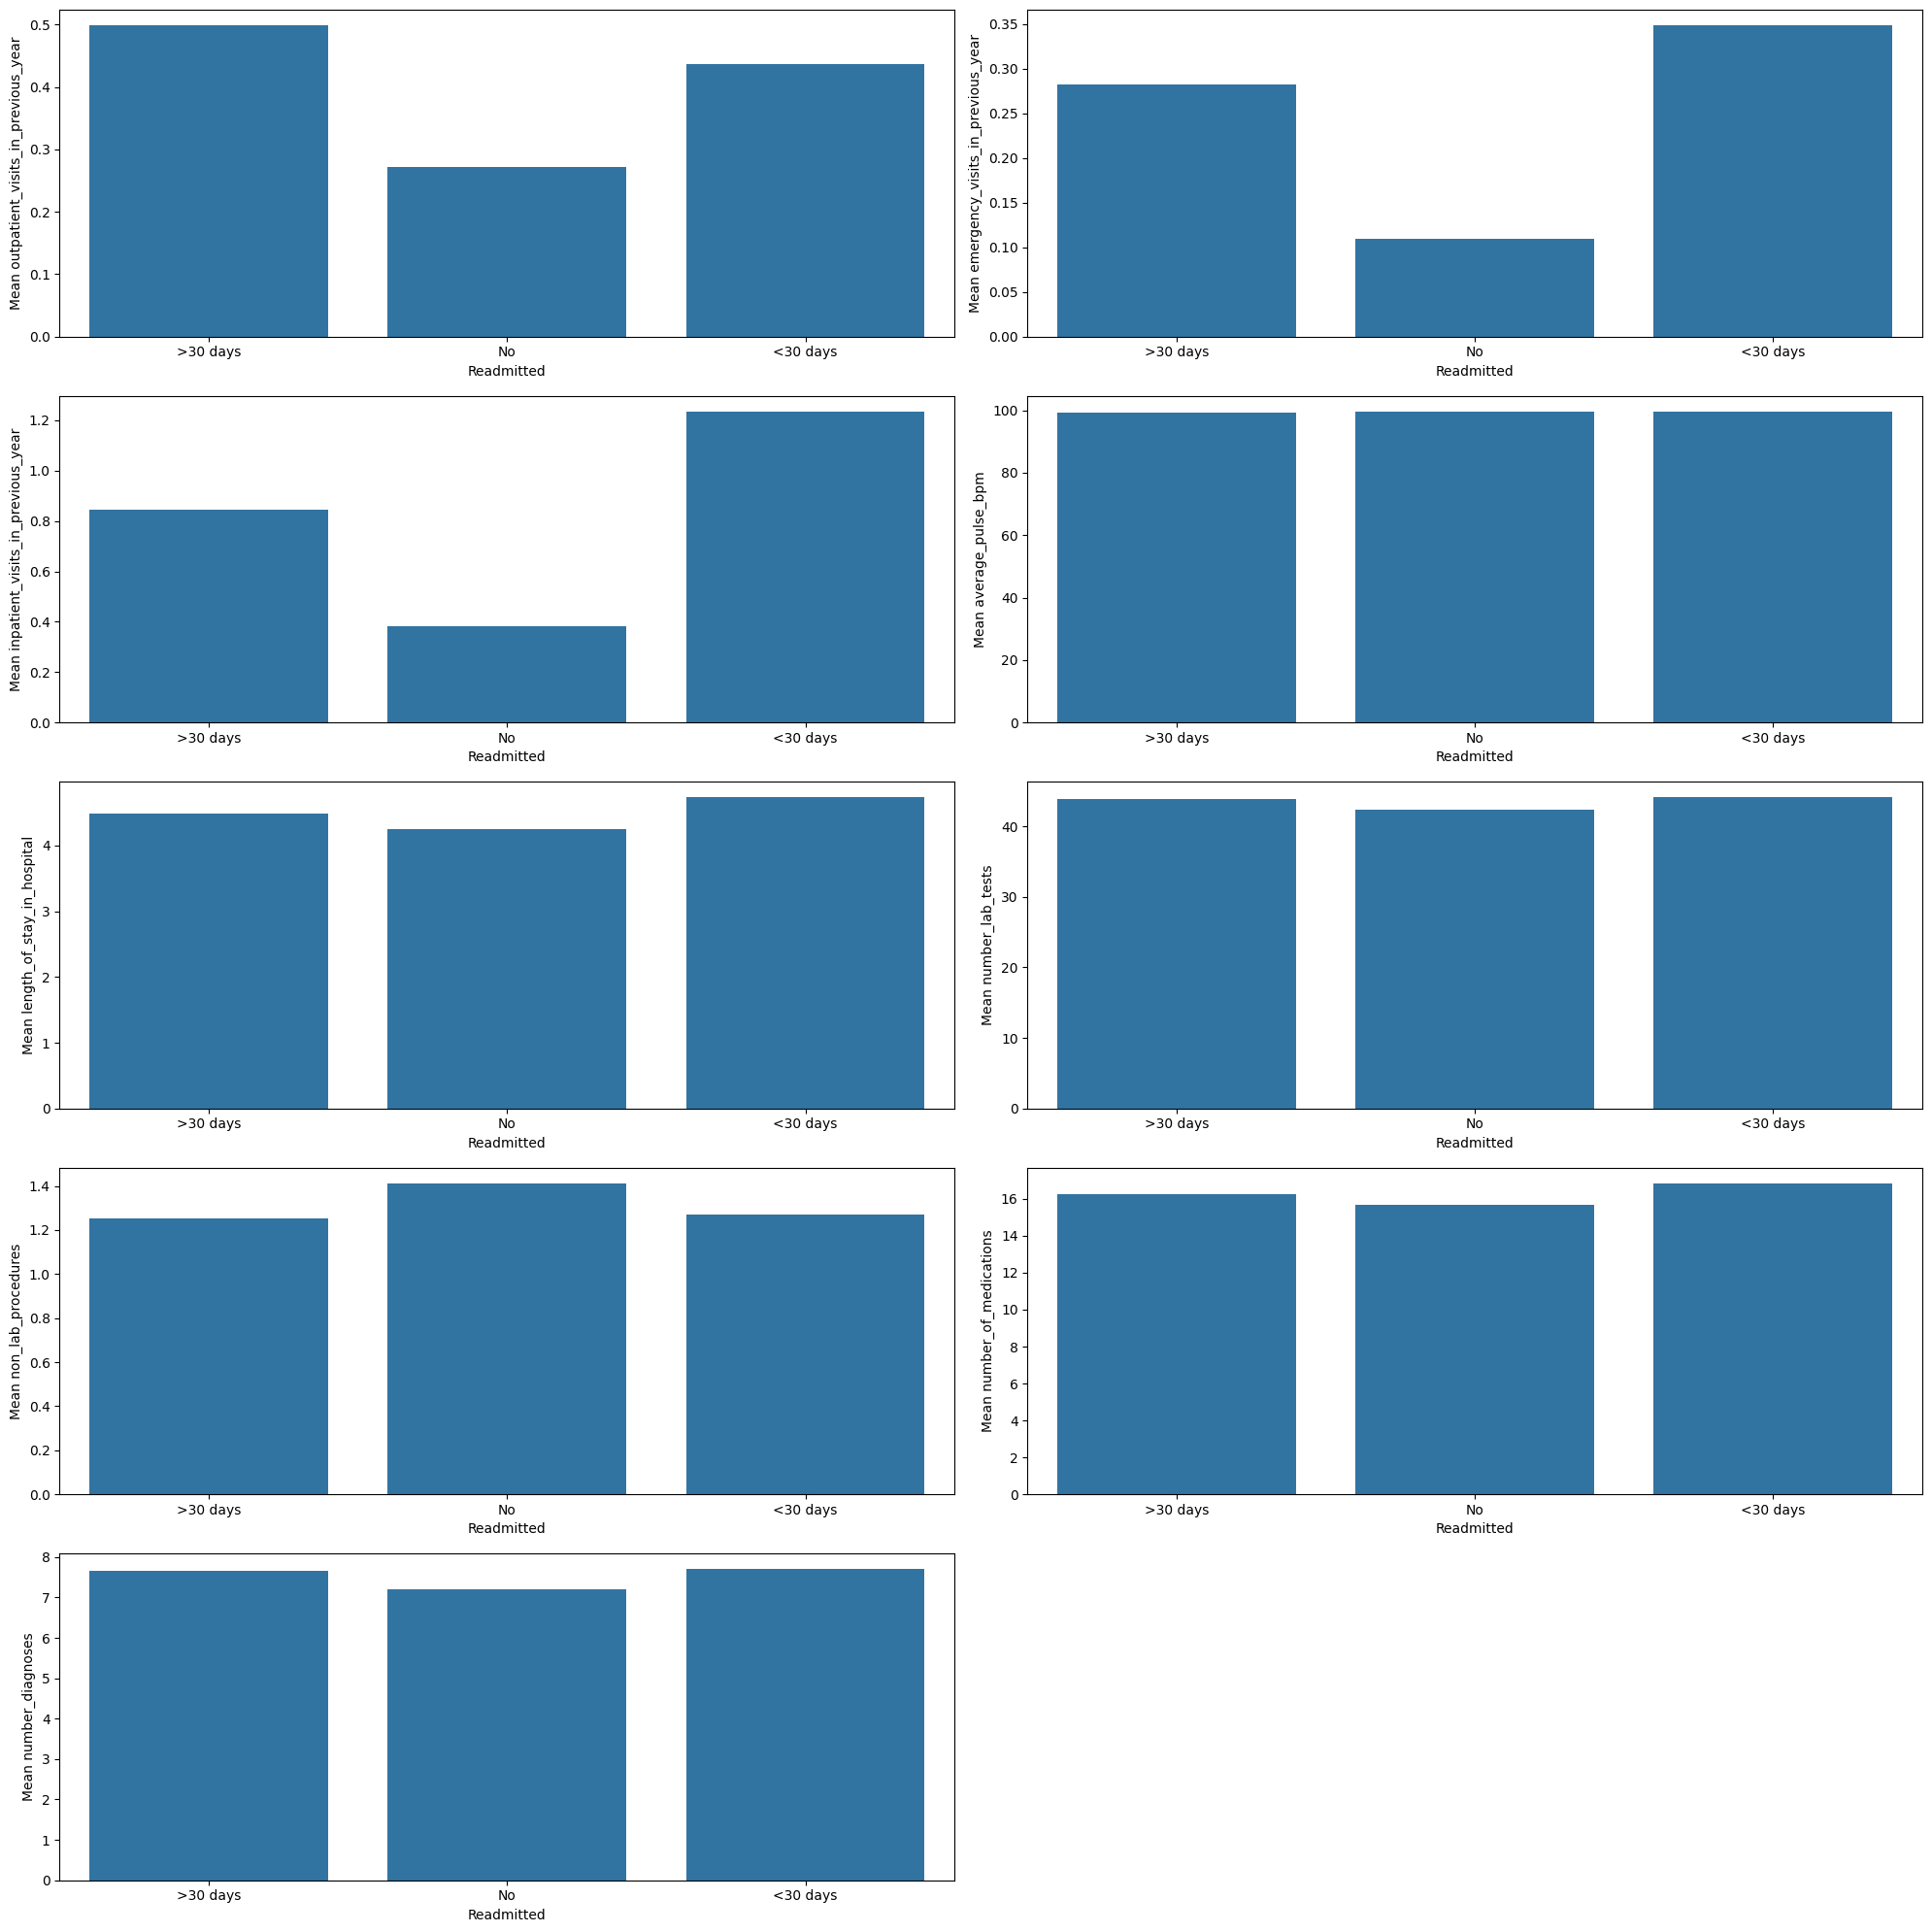

In [146]:
plt.figure(figsize=(20, 20))

features = [
    'outpatient_visits_in_previous_year',
    'emergency_visits_in_previous_year',
    'inpatient_visits_in_previous_year',
    'average_pulse_bpm',
    'length_of_stay_in_hospital',
    'number_lab_tests',
    'non_lab_procedures',
    'number_of_medications',
    'number_diagnoses'
]

for i, feature in enumerate(features, start=1):
    plt.subplot(5, 2, i)
    sns.barplot(x='readmitted_multiclass', y=feature, data=train_df, errorbar=None)
    plt.xlabel('Readmitted')
    plt.ylabel('Mean ' + feature)

plt.tight_layout()
#plt.savefig('numerical_features_tv_m.png')
plt.show()

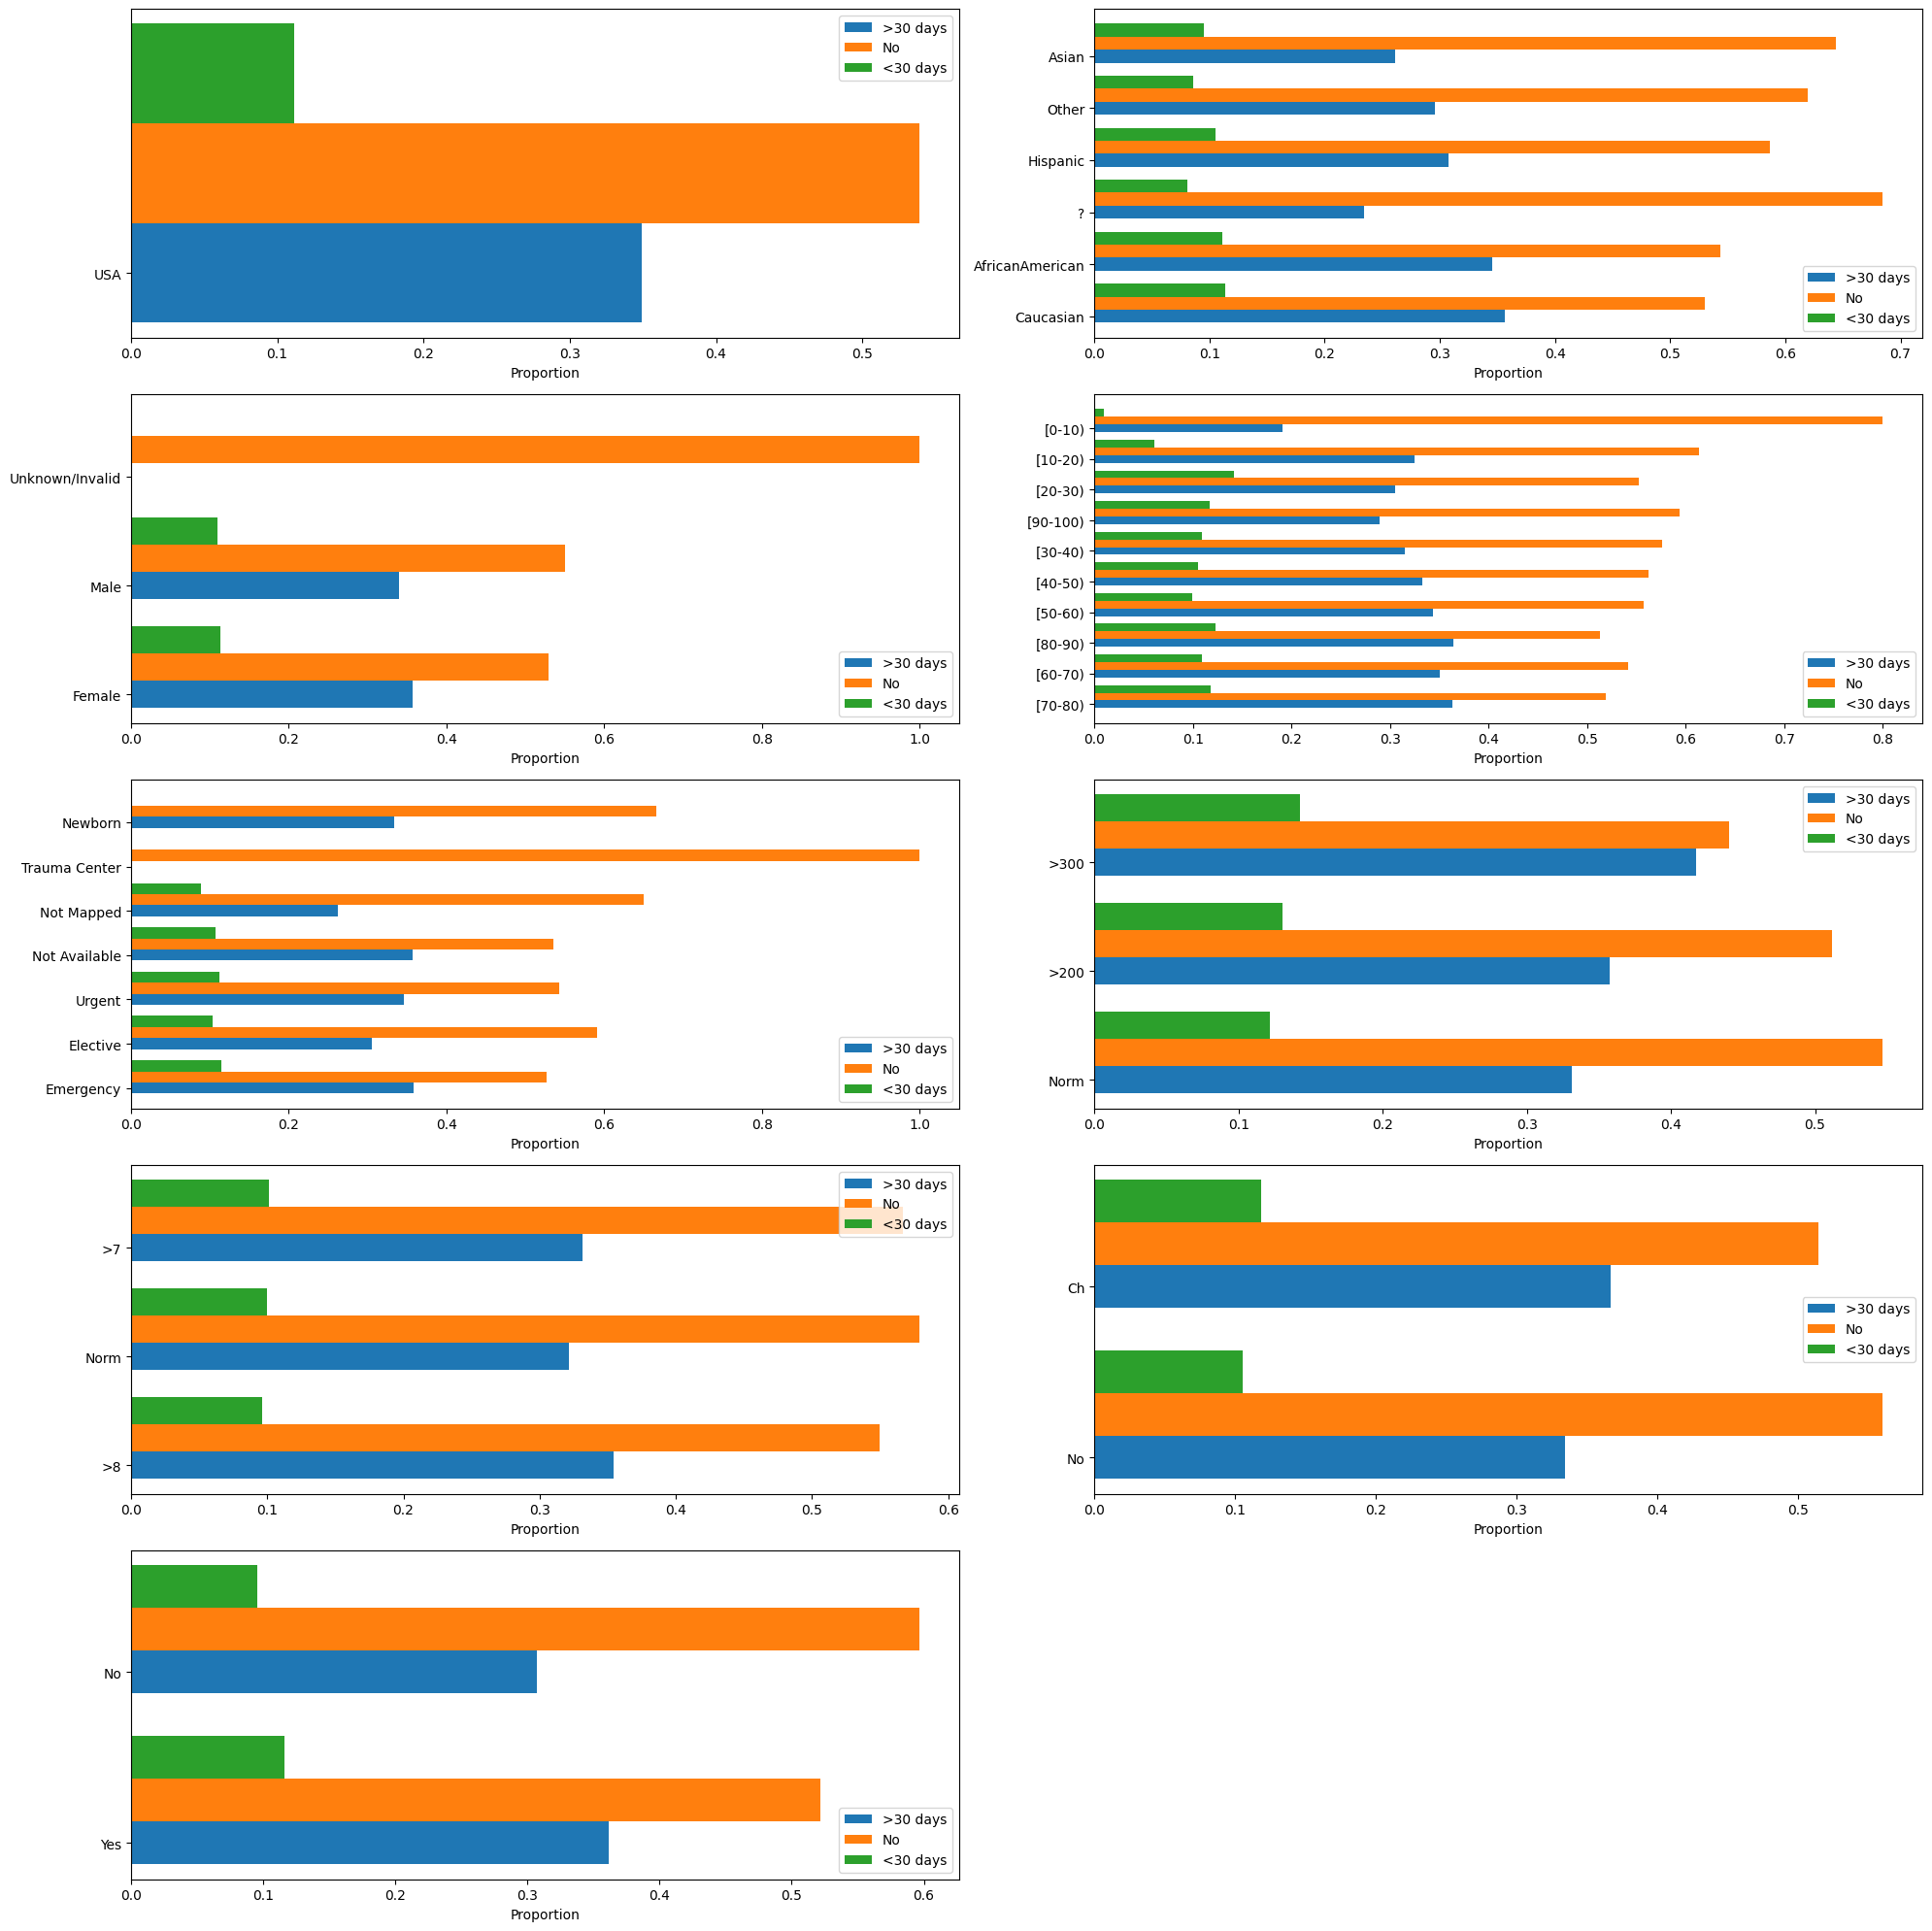

In [147]:
def plot_proportions_m(data, feature, ax):
    counts = data[feature].value_counts()
    total_count = len(data)
    classes = data['readmitted_multiclass'].unique()
    
    class_proportions = {cls: [] for cls in classes}
    
    for value in counts.index:
        subset = data[data[feature] == value]
        for cls in classes:
            class_count = len(subset[subset['readmitted_multiclass'] == cls])
            class_proportion = class_count / len(subset) if len(subset) > 0 else 0
            class_proportions[cls].append(class_proportion)
    
    bar_width = 0.25
    positions = np.arange(len(counts))
    
    for i, cls in enumerate(classes):
        ax.barh(positions + i * bar_width, class_proportions[cls], height=bar_width, label=cls)
    
    ax.set_yticks(positions)
    ax.set_yticklabels(counts.index)
    ax.set_xlabel('Proportion')
    ax.legend()


plt.figure(figsize=(20, 20))
plot_proportions_m(train_df, 'country', plt.subplot(5, 2, 1))
plot_proportions_m(train_df, 'race', plt.subplot(5, 2, 2))
plot_proportions_m(train_df, 'gender', plt.subplot(5, 2, 3))
plot_proportions_m(train_df, 'age', plt.subplot(5, 2, 4))
plot_proportions_m(train_df, 'admission_type', plt.subplot(5, 2, 5))
plot_proportions_m(train_df, 'glucose_test_result', plt.subplot(5, 2, 6))
plot_proportions_m(train_df, 'a1c_test_result', plt.subplot(5, 2, 7))
plot_proportions_m(train_df, 'change_in_meds_during_hospitalization', plt.subplot(5, 2, 8))
plot_proportions_m(train_df, 'prescribed_diabetes_meds', plt.subplot(5, 2, 9))

plt.tight_layout()
#plt.savefig("low_card_propplot_m")
plt.show()


The high cardinality features are going to be explored after preprocessing so its in the next secction

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="m_3">

## **12. Applying the pipelines to the training, validation, and test sets (Multiclass)**

</a>
</div>

In [148]:
train_df_1_m = pipeline_1.fit_transform(train_df_m)
train_df_2_m = pipeline_2_m.fit_transform(train_df_1_m)
train_df_3_m = pipeline_3.fit_transform(train_df_2_m)
#train_df_3 = train_df_3.drop_duplicates(subset='patient_id', keep='first')
train_df_3_m.drop("patient_id",axis=1, inplace=True)

val_df_1_m = pipeline_1.fit_transform(val_df_m)
val_df_2_m = pipeline_2_m.fit_transform(val_df_1_m)
val_df_3_m = pipeline_3.fit_transform(val_df_2_m)
val_df_3_m.drop("patient_id",axis=1, inplace=True)

test_df_1_m = pipeline_1.fit_transform(test_df)
test_df_2_m = pipeline_2_m.fit_transform(test_df_1_m)
test_df_3_m = pipeline_3.fit_transform(test_df_2_m)
test_df_3_m.drop("patient_id",axis=1, inplace=True)

In [149]:
train_data_m = train_df_3_m.copy()
val_data_m = val_df_3_m.copy()
test_data_m = test_df_3_m.copy()

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="m_4">

## **13. Exploring high cardinality features (Multiclass)**

</a>
</div>

In [150]:
high_cardinality

['payer_code',
 'medical_specialty',
 'discharge_disposition',
 'admission_source',
 'primary_diagnosis',
 'secondary_diagnosis',
 'additional_diagnosis',
 'medication']

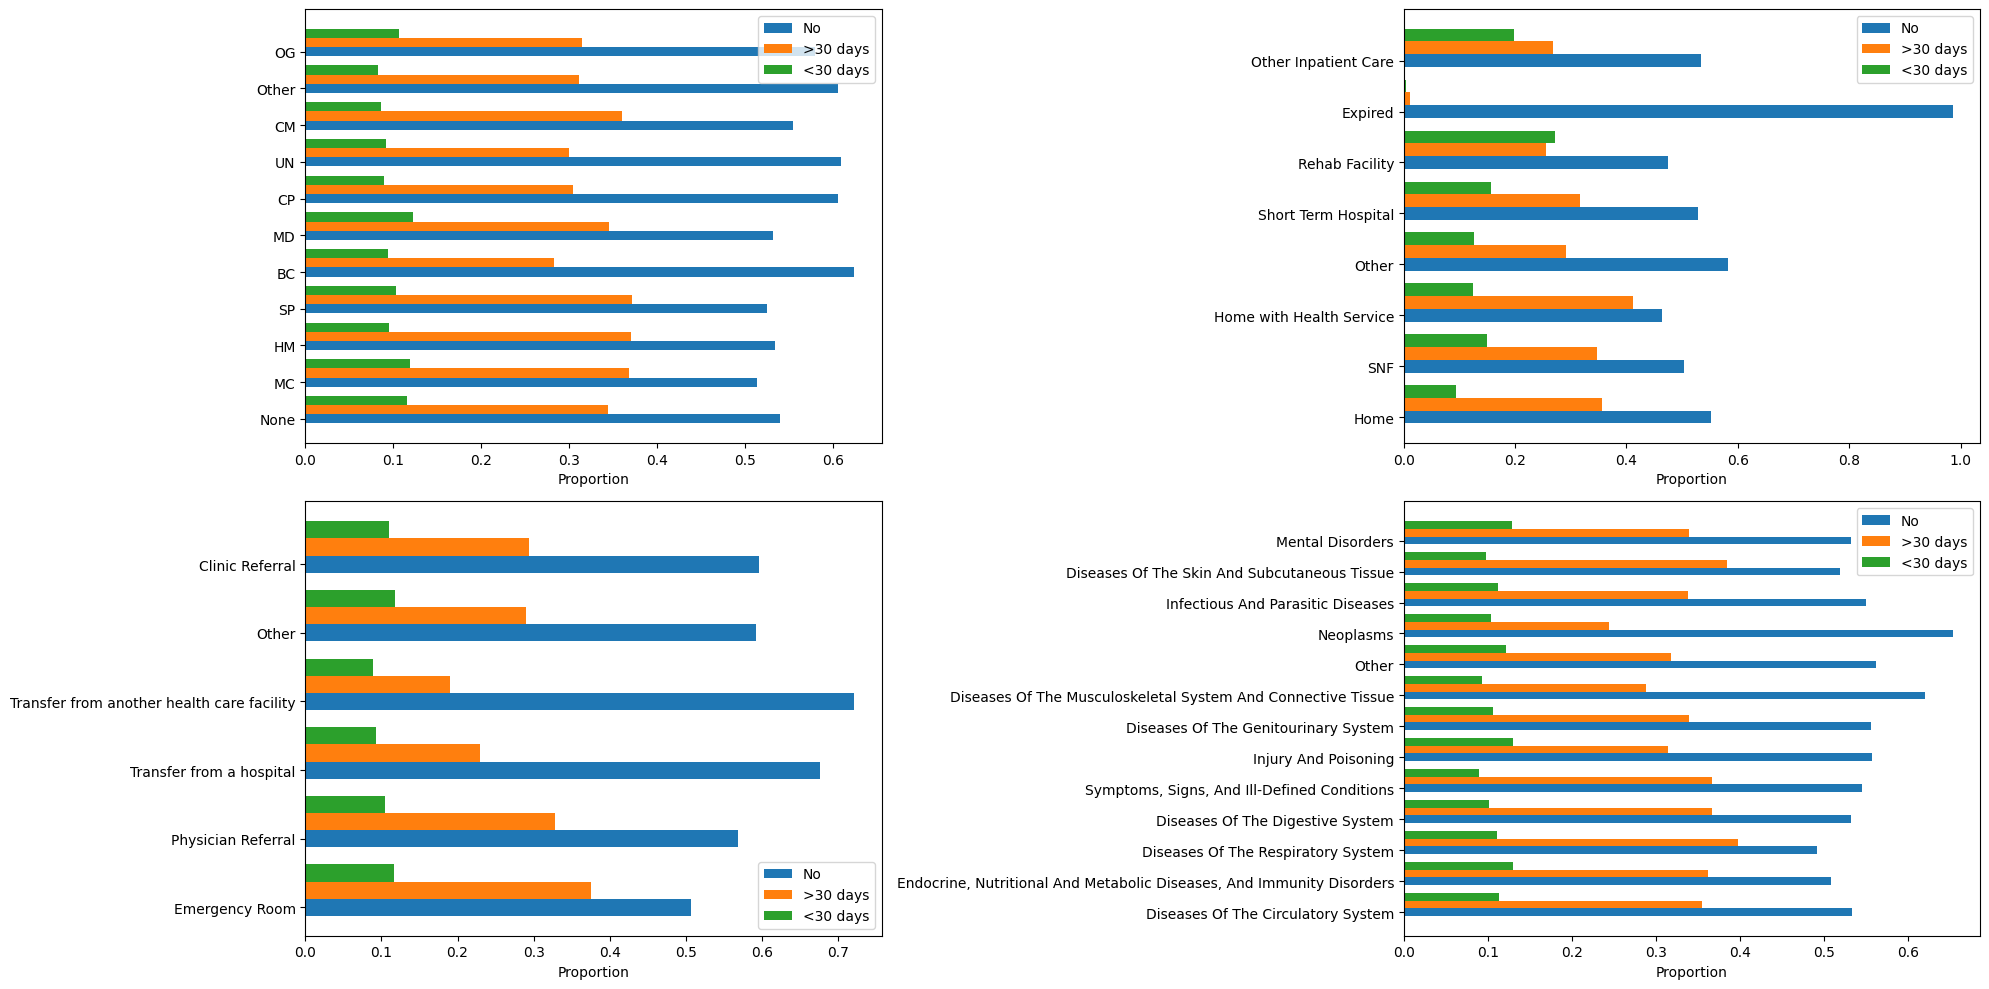

In [151]:
# Define the number of rows and columns for the subplot grid
high_cardinality = ['payer_code',
 'discharge_disposition',
 'admission_source',
 'primary_diagnosis']
num_rows = math.ceil(len(high_cardinality) / 2)
num_cols = 2

# Create a new figure with the specified size
plt.figure(figsize=(20, 5 * num_rows))

# Loop through each high cardinality feature and create subplots
for i, feature in enumerate(high_cardinality):
    plt.subplot(num_rows, num_cols, i + 1)
    plot_proportions_m(train_data_m, feature, plt.gca())

# Adjust layout and display the plot
plt.tight_layout()
#plt.savefig("high_card_propplot_m.png")
plt.show()

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="m_5">

## **14. Training and Evaluating Models (Multiclass)**

</a>
</div>

### **Useful Functions**

In [152]:
def split_data(train_set, val_set):
    y_train = train_set["readmitted_multiclass"]
    y_val = val_set["readmitted_multiclass"]
    train_set.drop(["readmitted_multiclass"], axis=1, inplace=True)
    val_set.drop(["readmitted_multiclass"], axis=1, inplace=True)
    return train_set, val_set, y_train, y_val

# Function to evaluate a classification model on training and validation sets.
def evaluate_classification_model_m(model, X_train, y_train, X_val, y_val):
    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predictions on the training set
    train_pred = model.predict(X_train)

    # Predictions on the validation set
    val_pred = model.predict(X_val)

    # Evaluate the model on the training set
    accuracy_train = accuracy_score(y_train, train_pred)
    print(f'Training Accuracy: {accuracy_train:.2f}')

    weighted_f1_val = f1_score(y_train, train_pred, average='weighted')
    print(f'Training Weighted F1 Score: {weighted_f1_val:.2f}')

    # Generate a classification report for the training set
    report_train = classification_report(y_train, train_pred)    
    print(f'Training Classification Report:\n{report_train}')
    
    # Create a confusion matrix for the training set
    confusion_train = confusion_matrix(y_train, train_pred)
    print(f'Training Confusion Matrix:\n{confusion_train}')

    # Evaluate the model on the validation set
    accuracy_val = accuracy_score(y_val, val_pred)
    print(f'Validation Accuracy: {accuracy_val:.2f}')

    weighted_f1_val = f1_score(y_val, val_pred, average='weighted')
    print(f'Validation Weighted F1 Score: {weighted_f1_val:.2f}')

    # Generate a classification report for the validation set
    report_val = classification_report(y_val, val_pred)
    print(f'Validation Classification Report:\n{report_val}')

    # Create a confusion matrix for the validation set
    confusion_val = confusion_matrix(y_val, val_pred)
    print(f'Validation Confusion Matrix:\n{confusion_val}')


train_df_3 = pd.read_csv("data/train.csv")
test_df_3 = pd.read_csv("data/test.csv")

y_m = train_df_3["readmitted_multiclass"]
X_m = train_df_3.drop(["readmitted_multiclass"], axis=1)

def avg_f1_score_m(model):
    # apply kfold
    skf = StratifiedKFold(n_splits=2)
    # create lists to store the results from the different models 
    f1_train = []
    f1_test = []
    recall_test = []
    precision_test = []
    recall_train = []
    precision_train = []
    timer = []
    n_iter = []
    
    for train_index, test_index in skf.split(X_m, y_m):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = X_m.iloc[train_index], X_m.iloc[test_index]
        y_train, y_val = y_m.iloc[train_index], y_m.iloc[test_index]
        
        X_train = pd.concat([X_train, y_train], axis=1)
        X_val = pd.concat([X_val, y_val], axis=1)

        X_train_1, X_train_2, X_train_3 = pass_pipelines(X_train)
        X_val_1, X_val_2, X_val_3 = pass_pipelines(X_val)
        X_train = X_train_3.copy()
        X_val = X_val_3.copy()
        
        train_scaled, val_scaled, _ = scale_data(X_train, X_val, X_val.copy(), numeric_columns, scaler_type=0)
        train_scaled_encoded, val_scaled_encoded, _ = label_encode_dataframe(train_scaled, val_scaled, _, categorical_columns)
        
        X_train, X_val, y_train, y_val = split_data(train_scaled_encoded, val_scaled_encoded)
        
        ros = RandomOverSampler(random_state=42)
        X_train, y_train = ros.fit_resample(X_train, y_train)
        
        scaled_X_train = X_train[selected_features].copy()
        scaled_X_val = X_val[selected_features].copy()
        
        # start counting time
        begin = time.perf_counter()
        # fit the model to the data
        model.fit(scaled_X_train, y_train)
        # finish counting time
        end = time.perf_counter()
        
        val_pred = model.predict(scaled_X_val)
        train_pred = model.predict(scaled_X_train)
        
        # calculate F1 score for the positive class ('Yes') on train and test sets
        f1_train.append(f1_score(y_train, train_pred, average="weighted"))
        recall_train.append(recall_score(y_train, train_pred, average="weighted"))
        precision_train.append(precision_score(y_train, train_pred, average="weighted"))

        # Metrics for "Yes" class on the validation set
        f1_test.append(f1_score(y_val, val_pred, average="weighted"))
        recall_test.append(recall_score(y_val, val_pred, average="weighted"))
        precision_test.append(precision_score(y_val, val_pred, average="weighted"))
        
        # append the time and the number of iterations in the corresponding list
        timer.append(end - begin)
        print(y_val.value_counts())
        report_val = classification_report(y_val, val_pred)
        print(f'Validation Classification Report:\n{report_val}')
    
    # calculate the average and the std for each measure (F1 score, time, and number of iterations)
    avg_time = round(np.mean(timer), 3)
    avg_train_f1 = round(np.mean(f1_train), 3)
    avg_train_recall = round(np.mean(recall_train), 3)
    avg_train_precision = round(np.mean(precision_train), 3)
    
    avg_test_f1 = round(np.mean(f1_test), 3)
    avg_test_recall = round(np.mean(recall_test), 3)
    avg_test_precision = round(np.mean(precision_test), 3)

    std_time = round(np.std(timer), 2)
    std_train_f1 = round(np.std(f1_train), 2)
    std_train_recall = round(np.std(recall_train), 2)
    std_train_precision = round(np.std(precision_train), 2)
    
    std_test_f1 = round(np.std(f1_test), 2)
    std_test_recall = round(np.std(recall_test), 2)
    std_test_precision = round(np.std(precision_test), 2)


    return (
        str(avg_time) + '+/-' + str(std_time),
        str(avg_train_f1) + '+/-' + str(std_train_f1),
        str(avg_test_f1) + '+/-' + str(std_test_f1),
        str(avg_train_precision) + '+/-' + str(std_train_precision),
        str(avg_test_precision) + '+/-' + str(std_test_precision),
        str(avg_train_recall) + '+/-' + str(std_train_recall),
        str(avg_test_recall) + '+/-' + str(std_test_recall),
        f1_train,
        f1_test
    )

def show_results_m(df, *args):
    """
    Receive an empty dataframe and the different models and call the function avg_score
    """
    count = 0
    f1_train_scores = []
    f1_val_scores = []
    # for each model passed as argument
    #scale = scale
    for arg in args:
        # obtain the results provided by avg_score
        time, avg_train, avg_test, avg_train_precision, avg_test_precision,avg_train_recall, avg_test_recall, f1_train, f1_test = avg_f1_score_m(arg)
        f1_train_scores.append(f1_train)
        f1_val_scores.append(f1_test)
        # store the results in the right row
        df.iloc[count] = time, avg_train, avg_test, avg_train_precision, avg_test_precision,avg_train_recall, avg_test_recall
        count+=1
    return df, f1_train_scores, f1_val_scores

### **Scaling, encoding and oversampling**

In [153]:
numeric_columns = ['inpatient_visits_in_previous_year','outpatient_visits_in_previous_year', 'emergency_visits_in_previous_year', 'length_of_stay_in_hospital', 'number_diagnoses','age','number_lab_tests', 'non_lab_procedures',
                   'number_of_medications', 'medication_length','patient_id_count', 'average_pulse_bpm']

categorical_columns = ['race', 'gender', 'admission_type', 'admission_source',
       'glucose_test_result', 'a1c_test_result', 'change_in_meds_during_hospitalization', 
       'prescribed_diabetes_meds', 'primary_diagnosis', 'discharge_disposition', 'payer_code']

# Scale the data
train_data_m, val_data_m, test_data_m = scale_data(train_data_m, val_data_m, test_data_m, numeric_columns, scaler_type=0)

# Encode the data
train_data_m, val_data_m, test_data_m = label_encode_dataframe(train_data_m, val_data_m,  test_data_m,categorical_columns)
#train_data, val_data, test_data = one_hot_encode_dataframe(train_data, val_data, test_data, categorical_columns)


y_train_m = train_data_m["readmitted_multiclass"]
X_train_m = train_data_m.drop(["readmitted_multiclass"], axis=1)
y_val_m = val_data_m["readmitted_multiclass"]
X_val_m = val_data_m.drop("readmitted_multiclass", axis=1)


In [154]:
print("Class distribution before oversampling:", Counter(y_train_m))

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_m, y_train_m = ros.fit_resample(X_train_m, y_train_m)

# Print class distribution after oversampling
print("Class distribution after oversampling:", Counter(y_train_m))

Class distribution before oversampling: Counter({'No': 26883, '>30 days': 17417, '<30 days': 5565})
Class distribution after oversampling: Counter({'No': 26883, '>30 days': 26883, '<30 days': 26883})


### **Feature selection**

### **Calculating the features importances based on a random forest**

In [155]:
# Train a RandomForest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_m, y_train_m)

# Access Feature Importances
importances = rf_model.feature_importances_

# Create a list of (feature, importance) pairs and sort it by importance
feature_importance_pairs = list(zip(X_train_m.columns, importances))
sorted_feature_importance = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Extract sorted feature names
sorted_features = [feature for feature, importance in sorted_feature_importance]

# Print the sorted features
print("Features Sorted by Importance:")
print(sorted_features)

Features Sorted by Importance:
['average_pulse_bpm', 'number_lab_tests', 'age', 'patient_id_count', 'number_of_medications', 'length_of_stay_in_hospital', 'primary_diagnosis', 'payer_code', 'discharge_disposition', 'number_diagnoses', 'non_lab_procedures', 'inpatient_visits_in_previous_year', 'admission_type', 'medication_length', 'admission_source', 'race', 'gender', 'outpatient_visits_in_previous_year', 'a1c_test_result', 'emergency_visits_in_previous_year', 'change_in_meds_during_hospitalization', 'glucose_test_result', 'prescribed_diabetes_meds']


Selecting only the top 15 most important features

In [156]:
selected_features = sorted_features[0:15]
print(selected_features)

['average_pulse_bpm', 'number_lab_tests', 'age', 'patient_id_count', 'number_of_medications', 'length_of_stay_in_hospital', 'primary_diagnosis', 'payer_code', 'discharge_disposition', 'number_diagnoses', 'non_lab_procedures', 'inpatient_visits_in_previous_year', 'admission_type', 'medication_length', 'admission_source']


### **Model tunning**

In [157]:
# Define the scorer of f1 score weighted by class 
scorer = make_scorer(f1_score, average='weighted')

**Random forest**

~ 3 min to run

In [158]:
# # Define the hyperparameter
# param_distributions = {
#     'n_estimators': [10, 50, 100, 200],
#     'max_depth': [5, 8, 10, 15],
# }

# # Define the scorer of f1 score weighted by class 
# scorer = make_scorer(f1_score, average='weighted')
# start_time = time.time()
# # Instantiate the model
# rf_model = RandomForestClassifier(random_state=42)

# # Tune the model using randomized search
# best_rf_model = tune_model_randomized(X_train_m[selected_features], y_train_m, selected_features, rf_model, param_distributions, scorer=scorer, n_iter=10, cv=4, verbose=4)
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

**Random search result**

In [159]:
best_rf_model_m = RandomForestClassifier(n_estimators= 200, max_depth= 15, random_state=42)

**MLP Classifier**

~ 2 min to run

In [160]:
# # Define the hyperparameter distributions
# mlp_param_distributions = {
#     'hidden_layer_sizes': [(30,),(50,),(30,15)],
#     'activation': ['logistic', 'tanh', 'relu'],
#     'alpha': uniform(0.001, 0.1),
# }

# start_time = time.time()

# mlp_model = MLPClassifier(random_state=42)

# # Tune the model using randomized search with stratified k-fold cross-validation
# best_mlp_model = tune_model_randomized(X_train_m[selected_features], y_train_m, selected_features, mlp_model, mlp_param_distributions, scorer=scorer, n_iter=8, cv=3, verbose=4)

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

**Random Search results**

In [161]:
best_mlp_model_m = MLPClassifier(activation= 'relu', alpha= 0.04558327528535912, hidden_layer_sizes= (30, 15),random_state=42)

**Ada Boost**

~ 10 min to run

In [162]:
# adaboost_param_distributions = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': uniform(0.5, 1),
# }

# start_time = time.time()

# adaboost_model = AdaBoostClassifier(random_state=42)

# # Tune the model using randomized search with stratified k-fold cross-validation
# best_adaboost_model = tune_model_randomized(X_train_m[selected_features], y_train_m, selected_features, adaboost_model, adaboost_param_distributions, scorer=scorer, n_iter=8, cv=3, verbose=4)

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")


**Random Search result**

In [163]:
best_adaboost_model_m = AdaBoostClassifier(learning_rate = 1.1011150117432087, n_estimators = 200, random_state=42)

**Ridge classification regression**

~ 10 min to run

In [164]:
# # Ridge parameter distributions
# ridge_param_distributions = {
#     'alpha': uniform(0.1, 1.9),  # Regularization strength
# }

# start_time = time.time()

# #Import RidgeClassifier from sklearn.linear_model
# from sklearn.linear_model import RidgeClassifier

# # Create a Ridge model
# ridge_model = RidgeClassifier()

# # Tune the model using randomized search with stratified k-fold cross-validation
# best_ridge_model = tune_model_randomized(
#     X_train_m[selected_features], y_train_m, selected_features, ridge_model,
#     ridge_param_distributions, scorer=scorer, n_iter=8, cv=3, verbose=4
# )

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

**Random Search result**

In [165]:
best_ridge_model_m = RidgeClassifier(alpha= 0.39643541684062933)

### **Model Selection**

In [166]:
# index = ['RF','Adaboost','MLP','Ridge']

# start_time = time.time()

# df = pd.DataFrame(columns = ['Time','Train F1','Test F1','Train Precision','Test Precision','Train Recall','Test Recall'], index = index)
# df, f1_train_scores, f1_val_scores = show_results_m(df, best_rf_model, best_adaboost_model, best_mlp_model, best_ridge_model)

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

In [167]:
# df

**Cross validation results**

In [168]:
index = ['RF','Adaboost','MLP','Ridge']

data = {
    'Time': ['20.499+/-2.45', '30.227+/-0.87', '46.716+/-2.03', '0.266+/-0.01'],
    'Train F1': ['0.861+/-0.0', '0.481+/-0.0', '0.503+/-0.0', '0.446+/-0.0'],
    'Test F1': ['0.6+/-0.0', '0.556+/-0.0', '0.556+/-0.01', '0.504+/-0.0'],
    'Train Precision': ['0.872+/-0.0', '0.499+/-0.0', '0.514+/-0.01', '0.458+/-0.0'],
    'Test Precision': ['0.595+/-0.0', '0.578+/-0.0', '0.585+/-0.01', '0.539+/-0.01'],
    'Train Recall': ['0.86+/-0.0', '0.499+/-0.0', '0.518+/-0.0', '0.465+/-0.0'],
    'Test Recall': ['0.617+/-0.0', '0.564+/-0.0', '0.558+/-0.01', '0.505+/-0.01'],
}

df = pd.DataFrame(data, index=index)

# Display the DataFrame
df

Time     Train F1       Test F1 Train Precision  \
RF        20.499+/-2.45  0.861+/-0.0     0.6+/-0.0     0.872+/-0.0   
Adaboost  30.227+/-0.87  0.481+/-0.0   0.556+/-0.0     0.499+/-0.0   
MLP       46.716+/-2.03  0.503+/-0.0  0.556+/-0.01    0.514+/-0.01   
Ridge      0.266+/-0.01  0.446+/-0.0   0.504+/-0.0     0.458+/-0.0   

         Test Precision Train Recall   Test Recall  
RF          0.595+/-0.0   0.86+/-0.0   0.617+/-0.0  
Adaboost    0.578+/-0.0  0.499+/-0.0   0.564+/-0.0  
MLP        0.585+/-0.01  0.518+/-0.0  0.558+/-0.01  
Ridge      0.539+/-0.01  0.465+/-0.0  0.505+/-0.01

**Choosing the best models and analyzing their performance more effectively using the holdout method**

Adaboost

In [169]:
evaluate_classification_model_m(best_adaboost_model, X_train_m[selected_features], y_train_m, X_val_m[selected_features], y_val_m)

Training Accuracy: 0.51
Training Weighted F1 Score: 0.49
Training Classification Report:
              precision    recall  f1-score   support

    <30 days       0.54      0.39      0.45     26883
    >30 days       0.48      0.30      0.37     26883
          No       0.51      0.85      0.64     26883

    accuracy                           0.51     80649
   macro avg       0.51      0.51      0.49     80649
weighted avg       0.51      0.51      0.49     80649

Training Confusion Matrix:
[[10446  6631  9806]
 [ 6694  8065 12124]
 [ 2079  2054 22750]]
Validation Accuracy: 0.58
Validation Weighted F1 Score: 0.52
Validation Classification Report:
              precision    recall  f1-score   support

    <30 days       0.26      0.25      0.26      2385
    >30 days       0.59      0.18      0.27      7464
          No       0.62      0.91      0.74     11522

    accuracy                           0.58     21371
   macro avg       0.49      0.44      0.42     21371
weighted avg      

Random forest

In [170]:
evaluate_classification_model_m(best_rf_model, X_train_m[selected_features], y_train_m, X_val_m[selected_features], y_val_m)

Training Accuracy: 0.56
Training Weighted F1 Score: 0.54
Training Classification Report:
              precision    recall  f1-score   support

    <30 days       0.58      0.56      0.57     26883
    >30 days       0.55      0.32      0.40     26883
          No       0.55      0.80      0.66     26883

    accuracy                           0.56     80649
   macro avg       0.56      0.56      0.54     80649
weighted avg       0.56      0.56      0.54     80649

Training Confusion Matrix:
[[15144  4414  7325]
 [ 8208  8606 10069]
 [ 2647  2630 21606]]
Validation Accuracy: 0.58
Validation Weighted F1 Score: 0.55
Validation Classification Report:
              precision    recall  f1-score   support

    <30 days       0.24      0.36      0.29      2385
    >30 days       0.56      0.24      0.34      7464
          No       0.66      0.84      0.74     11522

    accuracy                           0.58     21371
   macro avg       0.49      0.48      0.46     21371
weighted avg      

MLP classifier

In [171]:
evaluate_classification_model_m(best_mlp_model, X_train_m[selected_features], y_train_m, X_val_m[selected_features], y_val_m)

C:\Users\andre\anaconda3\envs\DM2324\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.54
Training Weighted F1 Score: 0.52
Training Classification Report:
              precision    recall  f1-score   support

    <30 days       0.55      0.47      0.51     26883
    >30 days       0.48      0.34      0.40     26883
          No       0.55      0.80      0.65     26883

    accuracy                           0.54     80649
   macro avg       0.53      0.54      0.52     80649
weighted avg       0.53      0.54      0.52     80649

Training Confusion Matrix:
[[12700  6753  7430]
 [ 7770  9146  9967]
 [ 2452  2981 21450]]
Validation Accuracy: 0.57
Validation Weighted F1 Score: 0.55
Validation Classification Report:
              precision    recall  f1-score   support

    <30 days       0.24      0.33      0.27      2385
    >30 days       0.54      0.26      0.35      7464
          No       0.66      0.83      0.73     11522

    accuracy                           0.57     21371
   macro avg       0.48      0.47      0.45     21371
weighted avg      

### **Best Model**
- Based on the reports written previously looks like the best model is the random forest, lets try to improve it more

In [172]:
best_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 0.009224970016566303,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [173]:
model_rf_1 = RandomForestClassifier(max_depth=12, n_estimators=200) 
evaluate_classification_model_m(model_rf_1, X_train_m[selected_features], y_train_m, X_val_m[selected_features], y_val_m)

Training Accuracy: 0.71
Training Weighted F1 Score: 0.71
Training Classification Report:
              precision    recall  f1-score   support

    <30 days       0.81      0.75      0.78     26883
    >30 days       0.77      0.55      0.64     26883
          No       0.61      0.84      0.71     26883

    accuracy                           0.71     80649
   macro avg       0.73      0.71      0.71     80649
weighted avg       0.73      0.71      0.71     80649

Training Confusion Matrix:
[[20131  1772  4980]
 [ 3089 14679  9115]
 [ 1637  2735 22511]]
Validation Accuracy: 0.59
Validation Weighted F1 Score: 0.57
Validation Classification Report:
              precision    recall  f1-score   support

    <30 days       0.26      0.26      0.26      2385
    >30 days       0.55      0.32      0.40      7464
          No       0.66      0.84      0.74     11522

    accuracy                           0.59     21371
   macro avg       0.49      0.47      0.47     21371
weighted avg      

In [174]:
model_rf_2 = RandomForestClassifier(max_depth=14, n_estimators=200) 
evaluate_classification_model_m(model_rf_2, X_train_m[selected_features], y_train_m, X_val_m[selected_features], y_val_m)

Training Accuracy: 0.79
Training Weighted F1 Score: 0.79
Training Classification Report:
              precision    recall  f1-score   support

    <30 days       0.90      0.85      0.88     26883
    >30 days       0.86      0.66      0.74     26883
          No       0.67      0.87      0.76     26883

    accuracy                           0.79     80649
   macro avg       0.81      0.79      0.79     80649
weighted avg       0.81      0.79      0.79     80649

Training Confusion Matrix:
[[22811   577  3495]
 [ 1309 17647  7927]
 [ 1122  2387 23374]]
Validation Accuracy: 0.60
Validation Weighted F1 Score: 0.57
Validation Classification Report:
              precision    recall  f1-score   support

    <30 days       0.27      0.20      0.23      2385
    >30 days       0.55      0.34      0.42      7464
          No       0.66      0.85      0.74     11522

    accuracy                           0.60     21371
   macro avg       0.49      0.46      0.46     21371
weighted avg      

**max_depth = 12 got the best results**

<hr>
<div style="background-color: #e6f7ff; padding: 15px; border-radius: 5px;">
<a class="anchor" id="m_6">

## **15. Predictions on the testing data (Multiclass)**

</a>
</div>

In [175]:
final_model = model_rf_1
pred_3 = final_model.predict(test_data_m[selected_features])

In [176]:
pd.Series(pred_3).value_counts()

No          20061
>30 days     6628
<30 days     3841
Name: count, dtype: int64

In [177]:
pd.Series(pred_3).head()

0          No
1    >30 days
2          No
3          No
4          No
dtype: object